# Plots for Texas Senate Maps

In [1]:
# low-level libraries
import os
import csv
from functools import partial

# dealing with data
import numpy as np
import pandas as pd
#import geopandas as gpd

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# make things look pretty
mpl.rcParams['font.size'] = 10
%config InlineBackend.figure_format = 'retina'

# GerryChain
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from gerrychain.metrics import efficiency_gap, mean_median

# SMU Gerrychain Wrapper
#import smugerry as smu
import GerryWrap as smu

### Racial Data

In [2]:
def load_ensemble(input_directory, statistic_name):
    fname = (input_directory + statistic_name + '.csv')
    ensemble = np.loadtxt(fname, delimiter=',')
    for plan in ensemble:
        plan = plan.sort()
    ensemble = ensemble.transpose()
    districts, chainlength = np.shape(ensemble)
    print(districts, "districts")
    print(chainlength, "plans")
    return ensemble

def encode_chamber_character(chamber: str) -> str:
    return {
        'USCD': 'C',
        'TXSN': 'S',
        'TXCD': 'H'
    }[chamber]

def load_plan_vectors(chamber, input_directory, statistic_name, plan_names):
    plan_vectors_directory = f'{input_directory}plan_vectors/'
    plan_vectors     = {}
    for x in plan_names:
        plan_vector_directory = f'vectors_PLAN{encode_chamber_character(chamber)}{x}/'        
        path = plan_vectors_directory + plan_vector_directory + statistic_name + '_vector.csv'
        plan_vectors[x] = np.loadtxt(path, delimiter=',')
    return plan_vectors

In [3]:
if False:
    print(ensemble[:,100000 - 1])

In [4]:
def get_number_districts(chamber):
    return {
        'USCD': 38,
        'TXSN': 31,
        'TXCD': 150
    }[chamber]

def hist_ensemble_comps(chamber, ensemble, perc_thresh, title, hist_x_axis_label, fill_color, \
                        do_small_histogram_pics=True, \
                        comp_plans=False, comp_plans_vv=[], comp_plans_names=[], comp_plans_colors=[], \
                        comp_plans_pnums=[]):
                        
    if do_small_histogram_pics:
        # This sets approximate range of histogram
        histogram_half_range = 6
        plt.rc('font', size=100)          # controls default text sizes
        plt.rc('axes', titlesize=100)     # fontsize of the axes title
        plt.rc('axes', labelsize=50)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
        plt.rc('legend', fontsize=50)    # legend fontsize
        plt.rc('figure', titlesize=80)  # fontsize of the figure title
    else:    
        SMALL_SIZE = 18
        MEDIUM_SIZE = 20
        BIGGER_SIZE = 12

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title    
        
        
    #hist_out_png = output_directory + file_prefix + "_" + hp + "_" + chamber + "_Histogram.png"
    #hist_out_pdf = output_directory + file_prefix + "_" + hp + "_" + chamber + "_Histogram.pdf"
    myplot,ax = plt.subplots(1,1,figsize=(14, 10))
               
    hist_y_axis_label = 'Plans'     
    
    # Compute values
    values = []
    for row in ensemble:
        #print(row)
        values.append(sum(x>perc_thresh for x in row))
    
    # ROB: I believe this will vastly improve the speed of this function
    # values = np.count_nonzero(a > perc_thresh, axis=1)
    
    if False:
        print([min(values),max(values)])     
        print(len([x for x in values if x==4]))
        
    if do_small_histogram_pics:
        mode = max(set(values), key=values.count) + 1
        histogram_range = range(max(mode - histogram_half_range, 0), mode + histogram_half_range)
        counts, bins, patches = plt.hist(x=values, bins=histogram_range, \
                                         color=fill_color, alpha = .5, rwidth=0.85, align = 'left')
        ax.set_xticks(bins)
                #ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))                        
        # print(counts)
    else:
        dist = get_number_districts(chamber)
        plt.hist(x=values, bins=dist+1, range=(0, dist), color=fill_color, alpha = .5, rwidth=0.85)                    
            
    # For comparison 
    if (comp_plans):
        for i in np.arange(len(comp_plans_vv)):
            #print(comp_plans_vv[i])
            #print(comp_plans_colors[i])
            #print(comp_plans_names[i])
            y1 = sum(comp_plans_vv[i] > perc_thresh)
            #print(y1)
            #plt.plot(seats, y1, color=comp_plans_colors[i], marker='o',markersize=4, ls='',label=comp_plans_names[i])
    
            plt.axvline(x=y1, color=comp_plans_colors[i], ls='--', lw=2.5, ymax=0.75, label=comp_plans_names[i])    
        
    plt.xlabel(hist_x_axis_label)
    plt.ylabel(hist_y_axis_label)
    plt.title(title)
    plt.tight_layout()
    plt.legend(loc=2, fontsize=8)
   # plt.savefig(hist_out_png)
   # plt.savefig(hist_out_pdf)
   # plt.show()   
    return myplot


In [5]:
def get_chamber_pretty_name(chamber):
    return {
        'USCD': "US Congress",
        'TXSN': "Texas Senate",
        'TXCD': "Texas House"
    }[chamber]

def save_histograms(chamber, output_directory, group, ensemble, current_plan, comparison_plan, plan_vectors, plan_pnums, plan_legend_names, plan_colors):    
    group_pretty_name = {
        'HVAP': "Hispanic Voting Age Population",
        'BVAP': "Black Voting Age Population",
        'BHVAP': "Black+Hispanic Voting Age Population"
    }[group]

    # Fill color used for violin plots and histograms 
    group_fill_color = {
        'HVAP': '#2222ff',
        'BHVAP': '#33CC00',
        'BVAP': '#ff9933'
    }[group]
    
    chamber_pretty_name = get_chamber_pretty_name(chamber)
    
    do_small_histogram_pics=True
    if do_small_histogram_pics:
        plot_title = chamber + ' ' + group
    else:
        plot_title = chamber_pretty_name + ' District Results  (' + group_pretty_name + ')'

    perc_thresh = 0.5 # ROB: Does this depend on small/large histogram pics? - has this been replaced with array

    if (group=='BVAP'):
        perc_thresh = [0.3, 0.4, 0.5]
    elif (group=='HVAP'):
        perc_thresh = [0.5, 0.55, 0.6, 0.65] 
    elif (group=='BHVAP'):
        perc_thresh = [0.5, 0.6, 0.7]
    else:
        raise RuntimeError(f'Unknown group: {group}')
        
    for x in perc_thresh:
        # x is now perc_thresh
        hist_axis_label = f'Districts > {x*100:.0f}%'
        myplot = hist_ensemble_comps(chamber, ensemble.transpose(), x, plot_title, hist_axis_label, group_fill_color, 
                                     do_small_histogram_pics=do_small_histogram_pics,
                                     comp_plans=True, 
                                     comp_plans_vv=[plan_vectors[current_plan], plan_vectors[comparison_plan]],
                                     comp_plans_names=plan_legend_names,
                                     comp_plans_colors=plan_colors, comp_plans_pnums=plan_pnums)
        # should have different titles if they are large
        size_string = 'small' if do_small_histogram_pics else 'large'
        myplot.savefig(f'{output_directory}hist-{size_string}-{chamber}-{current_plan}-{comparison_plan}-{group}-{str(x)}.pdf')
        # Not needed?
        #myplot.show() 
    plt.rcParams.update(plt.rcParamsDefault)

In [6]:
# This looks like it is no longer used
if False:
    myplot = hist_ensemble_comps(ensemble.transpose(), perc_thresh, plot_title, hist_axis_label, group_fill_color, \
                                do_small_histogram_pics=True,\
                                comp_plans=True, comp_plans_vv=vvList,comp_plans_names=plan_legend_names,\
                                     comp_plans_colors=plan_colors, comp_plans_pnums=plan_pnums)
    myplot.savefig(output_directory + 'hist-small-' + chamber + '-' + group + '-'+ str(perc_thresh)+'.pdf')
    # Not needed?
    #myplot.show()

## Seats/Votes:  Varying Maps, multiple comparisons

In [7]:
def get_election_pretty_name(election):
    return {
        'SEN20': "2020 US Senate Election",
        'PRES20': "2020 US Presidential Election"
    }[election]    


def save_seats_voteshares_ensemble_comps_plot(chamber, output_directory, election, ensemble, current_plan, comparison_plan, plan_vectors, plan_pnums, plan_legend_names, plan_colors):
    plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
    plot_title = get_chamber_pretty_name(chamber) + ' District Results  (' + get_election_pretty_name(election) + ')'
    myplot = smu.vote_vector_ensemble_comps(ensemble, plot_title, pc_thresh=.01, have_actual=False, \
                                            comp_plans=True, comp_plans_vv=[plan_vectors[current_plan], plan_vectors[comparison_plan]], 
                                            comp_plans_names=plan_legend_names,\
                                            comp_plans_colors=plan_colors, comp_plans_pnums=plan_pnums)
    myplot.savefig(f'{output_directory}seats-voteshares-ensemble-comps-{chamber}-{current_plan}-{comparison_plan}-{election}.pdf')
    plt.show()
    plt.rcParams.update(plt.rcParamsDefault)
    
# save_seats_voteshares_ensemble_comps_plot(chamber, output_directory, election, ensemble, current_plan, comparison_plans[0], plan_vectors)

# Seats/Votes:  Varying Maps

In [8]:
# For next map: add proposed TO ENSEMBLE when we pass it in
if False:
    blahs=np.column_stack([vvList[1], ensemble])
    np.shape(ensemble)

In [9]:
def save_vote_vector_ensemble_plot(chamber, output_directory, election, ensemble, plan, plan_vectors):
    plot_title = get_chamber_pretty_name(chamber) + ' District Results  (' + get_election_pretty_name(election) + ')'
    myplot = smu.vote_vector_ensemble(np.column_stack([plan_vectors[plan],ensemble]), plot_title, pc_thresh=.01, have_actual=True)
    myplot.savefig(f'{output_directory}seats-voteshares-ensemble-enacted-{chamber}-{plan}-{election}.pdf')
    plt.show()
    
# save_vote_vector_ensemble_plot(chamber, output_directory, election, ensemble, comparison_plans[0], plan_vectors)

# Seats/Votes:  Varying Voteshare

In [10]:
def save_seats_votes_ensemble_plot(chamber, output_directory, election, ensemble, plan, plan_vectors):
    plot_title = get_chamber_pretty_name(chamber) + " Seats-Votes Curve (" + get_election_pretty_name(election) + ")"
    myplot = smu.seats_votes_ensemble(np.column_stack([plan_vectors[plan], ensemble]), plot_title, have_actual=True)
    myplot.savefig(f'{output_directory}seats-votes-ensemble-enacted-{chamber}-{plan}-{election}.pdf')
    plt.show()
    
# save_seats_votes_ensemble_plot(chamber, output_directory, election, ensemble, comparison_plans[0], plan_vectors)

# Mean/Median and Partisan Bias

In [11]:
def save_mean_median_partisan_bias_plot(chamber, output_directory, election, ensemble, plan, plan_vectors):
    # OPTIONAL: pass in statewide=statewide_dem_share
    myplot = smu.mean_median_partisan_bias(np.column_stack([plan_vectors[plan],ensemble]), have_actual=True)
    myplot.savefig(f'{output_directory}mean-median-partisan-bias-ensemble-enacted-{chamber}-{plan}-{election}.pdf')
    plt.show()
    # np.median(vvList[1])

# save_mean_median_partisan_bias_plot(chamber, output_directory, election, ensemble, comparison_plans[0], plan_vectors)

In [12]:
if False:
    np.median(vvList[1])-np.mean(vvList[1])
    sum([False,True,False])
    153/500000

In [13]:
def run():
    chamber = 'TXSN' # 'USCD' # 

    input_directory = 'C:/Users/rob/projects/election/rob/'
    seed_description = 'random_seed'
    ensemble_number = 2
    suffix = f'{chamber}_{seed_description}_{ensemble_number}'
    ensemble_directory = f'{input_directory}ensembles/ensemble_{suffix}/'

    # Where we have our output files
    output_directory = f'plots/plots_{suffix}/'
    os.makedirs(os.path.dirname(output_directory + 'init.txt'), exist_ok=True)
    with open(output_directory + 'init.txt', 'w') as f:
        f.write("Created Folder")
    
    
    # comparison plans
    current_plan = 2100
    comparison_plans = [2129, 2130]

    # For which should we plot district #, if any?
    plan_pnums = [False,True]

    true_pnums = [i for i, x in enumerate(plan_pnums) if x]
    print(true_pnums)

    # Now we give each plan a name
    plan_legend_names = ['Current', 'Proposed']
    print(plan_legend_names)

    # Now we choose colors for each plan
    # Use RGB triplets OR strings
    plan_colors = ['green', 'red']
    print(plan_colors[1])
    
    
    # racial
    if True:
        groups = ['BVAP', 'HVAP', 'BHVAP']
        for group in groups:
            print(group)

            # We had weird file names, associate correct prefix
            group_file_pref = {
                'HVAP': "hisp",
                'BVAP': "black",
                'BHVAP': "black_hisp"
            }[group]

            # Load data. For each group of interest...
            statistic_name = group_file_pref + '_perc'
            ensemble = load_ensemble(ensemble_directory, statistic_name)
            plan_vectors = load_plan_vectors(chamber, input_directory, statistic_name, [current_plan] + comparison_plans)

            for comparison_plan in comparison_plans:
                print(comparison_plan)
                save_histograms(chamber, output_directory, group, ensemble, current_plan, comparison_plan, plan_vectors, plan_pnums, plan_legend_names, plan_colors)

        
    # elections
    if True:
        elections = ['PRES20', 'SEN20']
        for election in elections:
            print(election)
            # Load Election Data
            statistic_name = "votes_" + election
            ensemble = load_ensemble(ensemble_directory, statistic_name)
            plan_vectors = load_plan_vectors(chamber, input_directory, statistic_name, [current_plan] + comparison_plans)
            # print(plan_vectors)

            #hc = 40.62/(40.62+56.46)
            #ma = np.mean(ensembles[:,0])
            #print("from loaded data:", mm)
            #print("from ballotpedia:", hc)
            #statewide_dem_share = hc

            # Checking that this gives us district numbers, 
            #     modulo shift and conversion to individual strings (will be done inside function)
            if False:
                print(np.array(plan_vectors[comparison_plan].argsort())+1)

            for comparison_plan in comparison_plans:
                print(comparison_plan)
                save_seats_voteshares_ensemble_comps_plot(chamber, output_directory, election, ensemble, current_plan, comparison_plan, plan_vectors, plan_pnums, plan_legend_names, plan_colors)
                save_vote_vector_ensemble_plot(chamber, output_directory, election, ensemble, comparison_plan, plan_vectors)
                save_seats_votes_ensemble_plot(chamber, output_directory, election, ensemble, comparison_plan, plan_vectors)
                save_mean_median_partisan_bias_plot(chamber, output_directory, election, ensemble, comparison_plan, plan_vectors)
        plt.show()    

[1]
['Current', 'Proposed']
red
BVAP
31 districts
617270 plans
2129
2130
HVAP
31 districts
617270 plans
2129
2130
BHVAP
31 districts
617270 plans
2129
2130
PRES20
31 districts
617270 plans
2129


C:\users\rob\projects\election\AndreaPlotNotebooks_9_24\GerryWrap.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  myplot = plt.figure(figsize=(6.5, 3.5))


[0.2010312416880574, 0.7903037484969416]
['31', '30', '1', '2', '28', '3', '22', '4', '25', '11', '9', '7', '18', '12', '17', '8', '5', '20', '27', '10', '21', '19', '16', '26', '29', '15', '6', '23', '14', '24', '13']


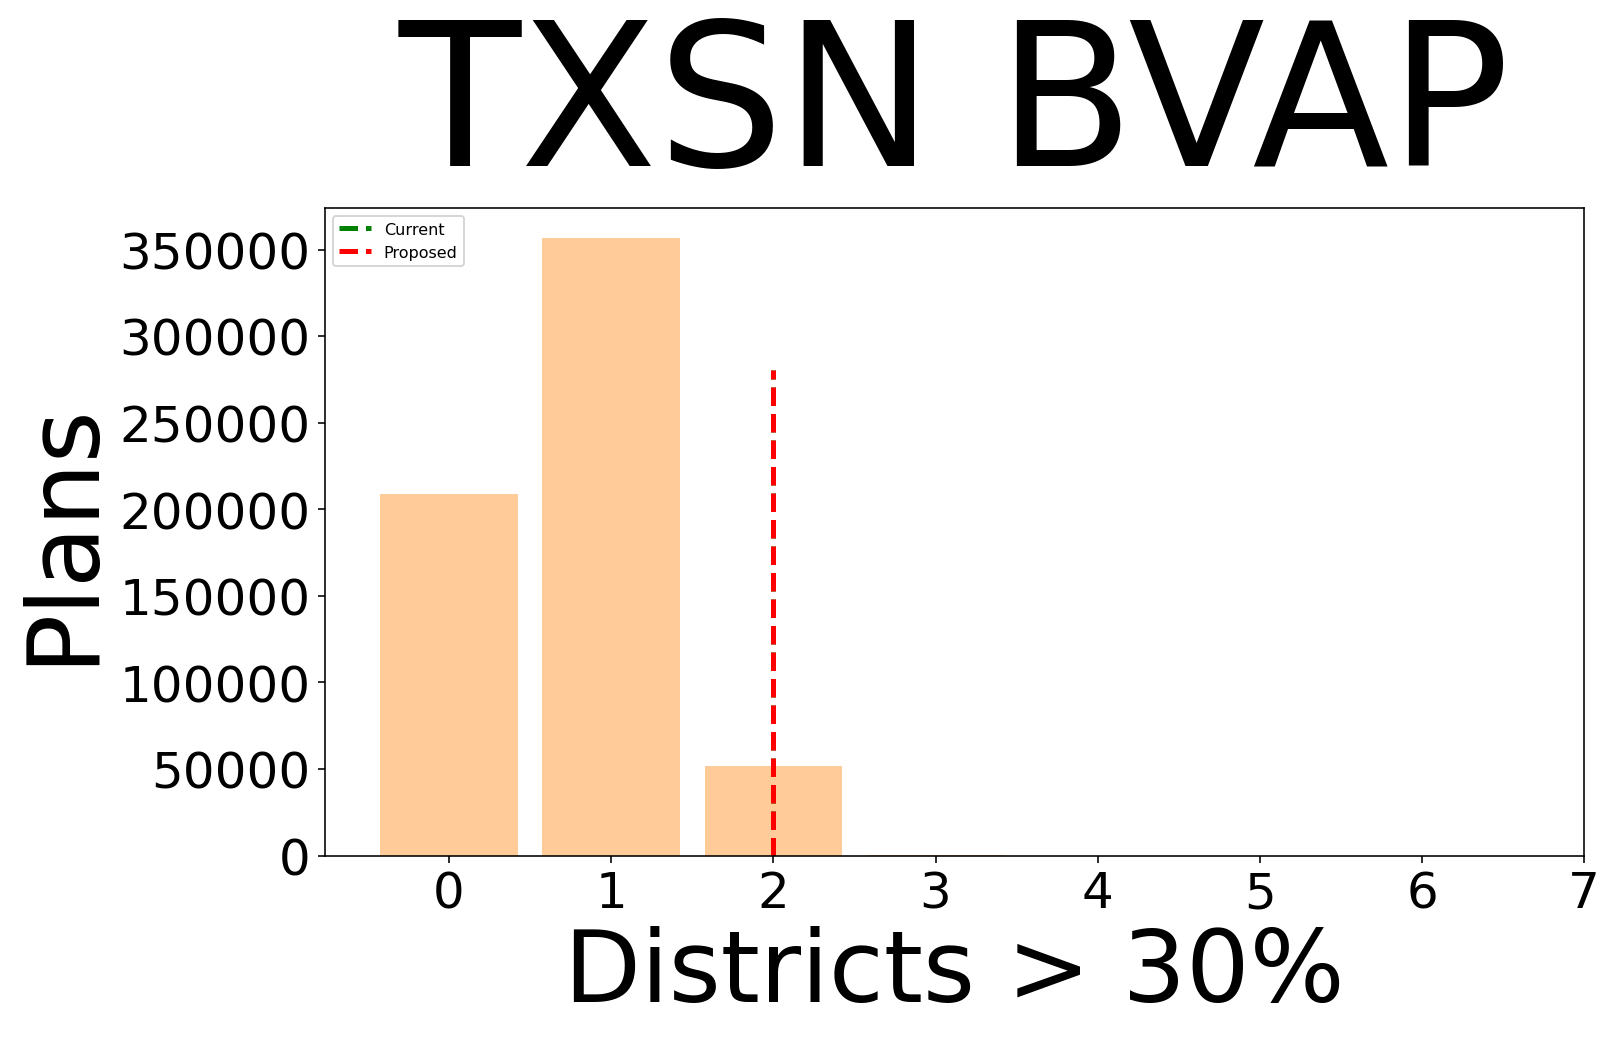

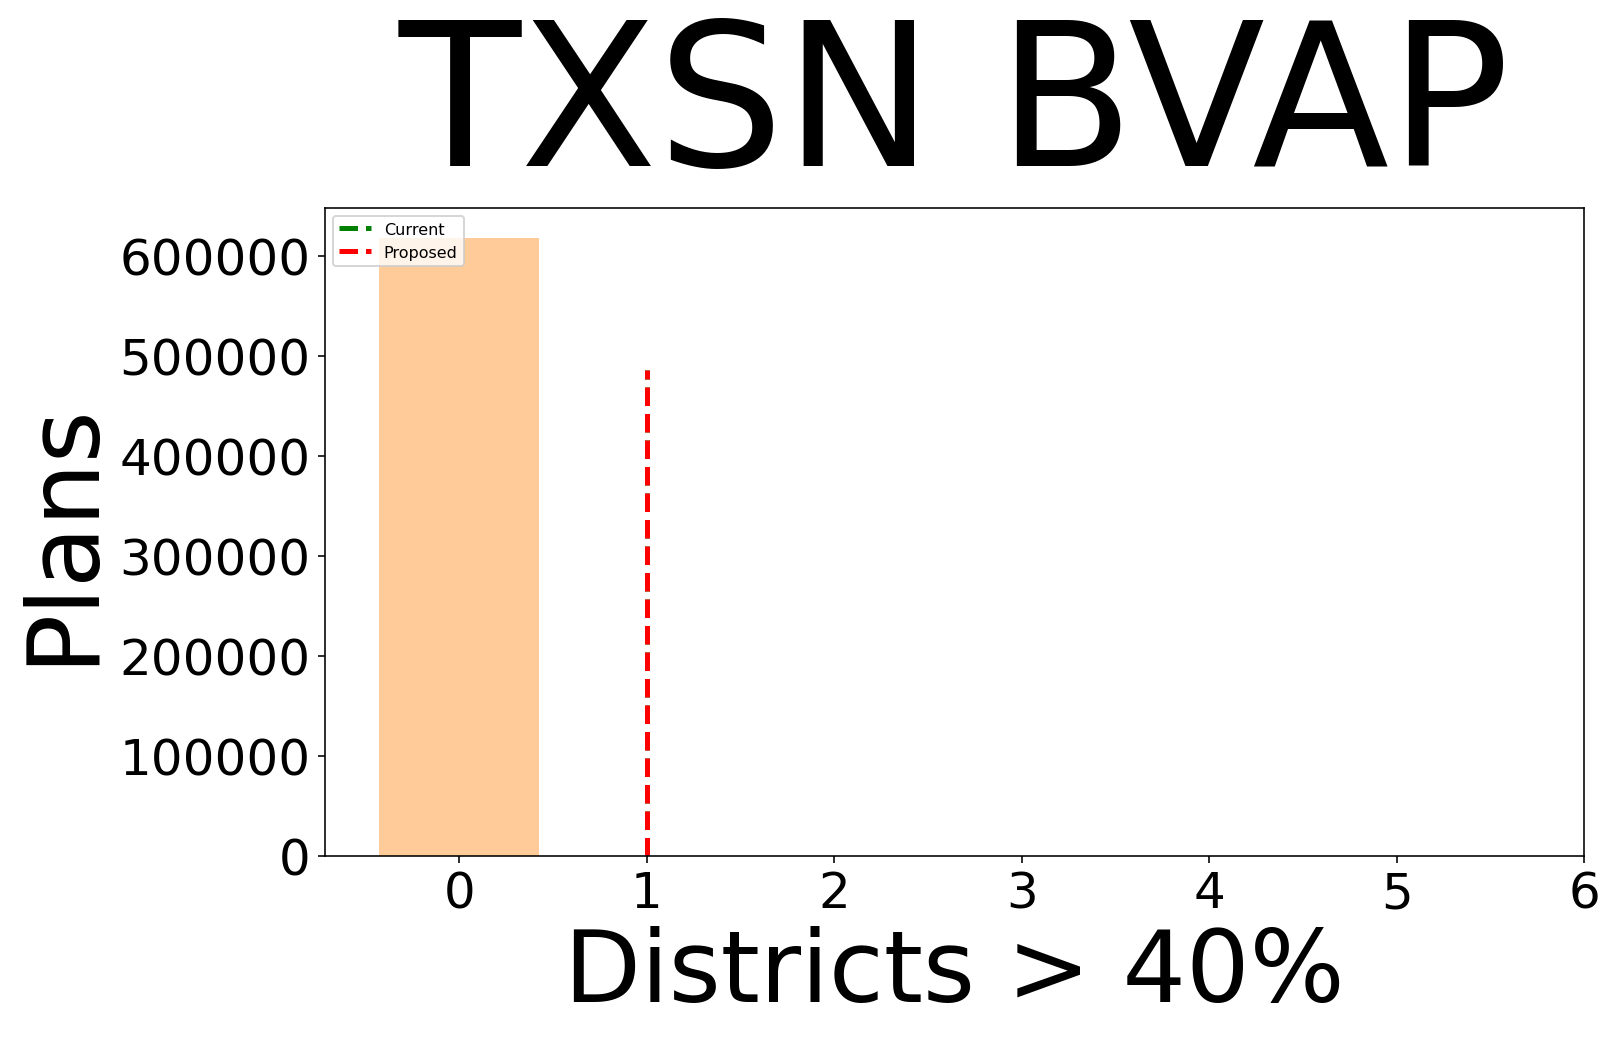

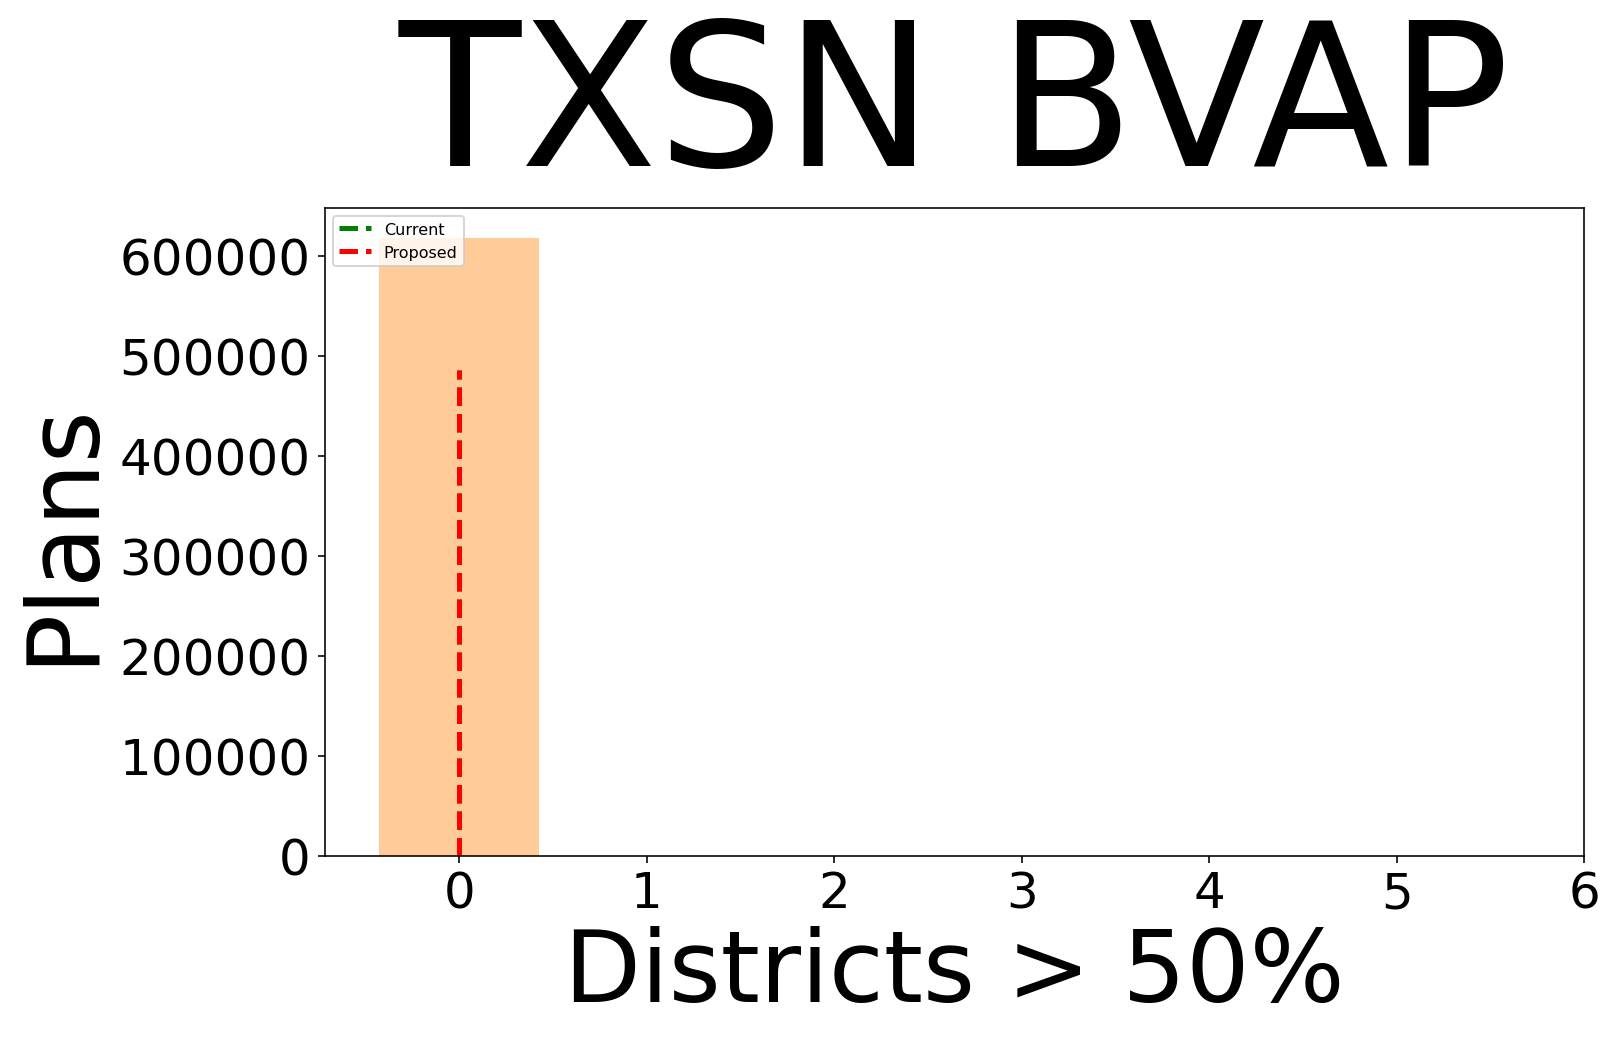

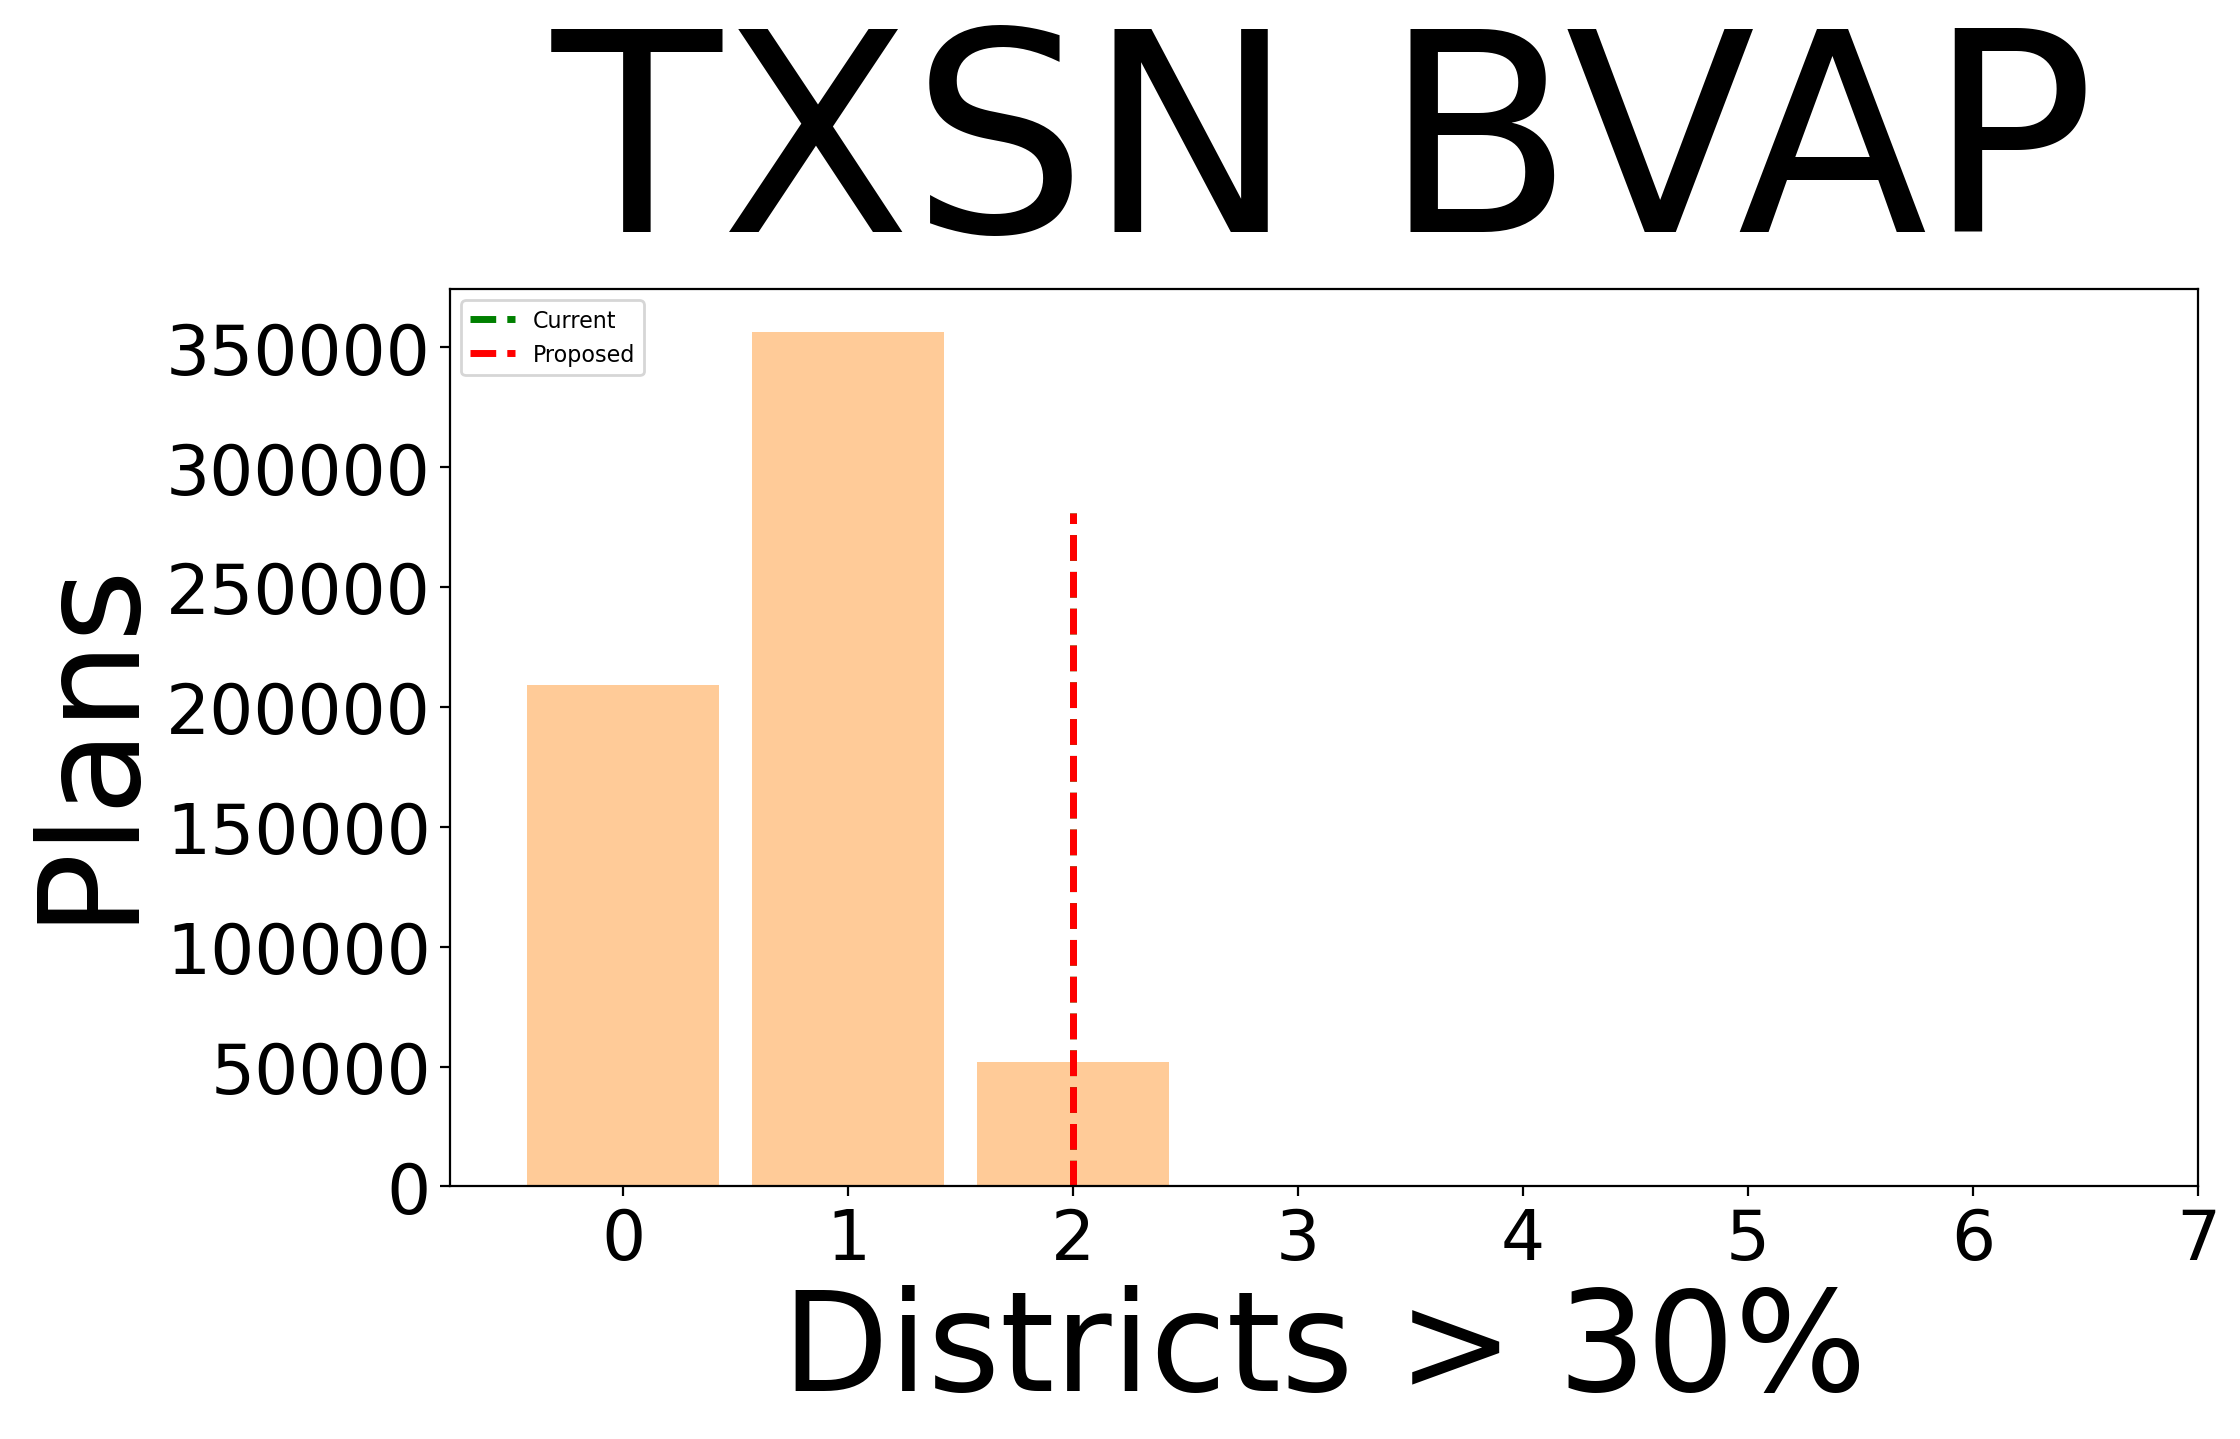

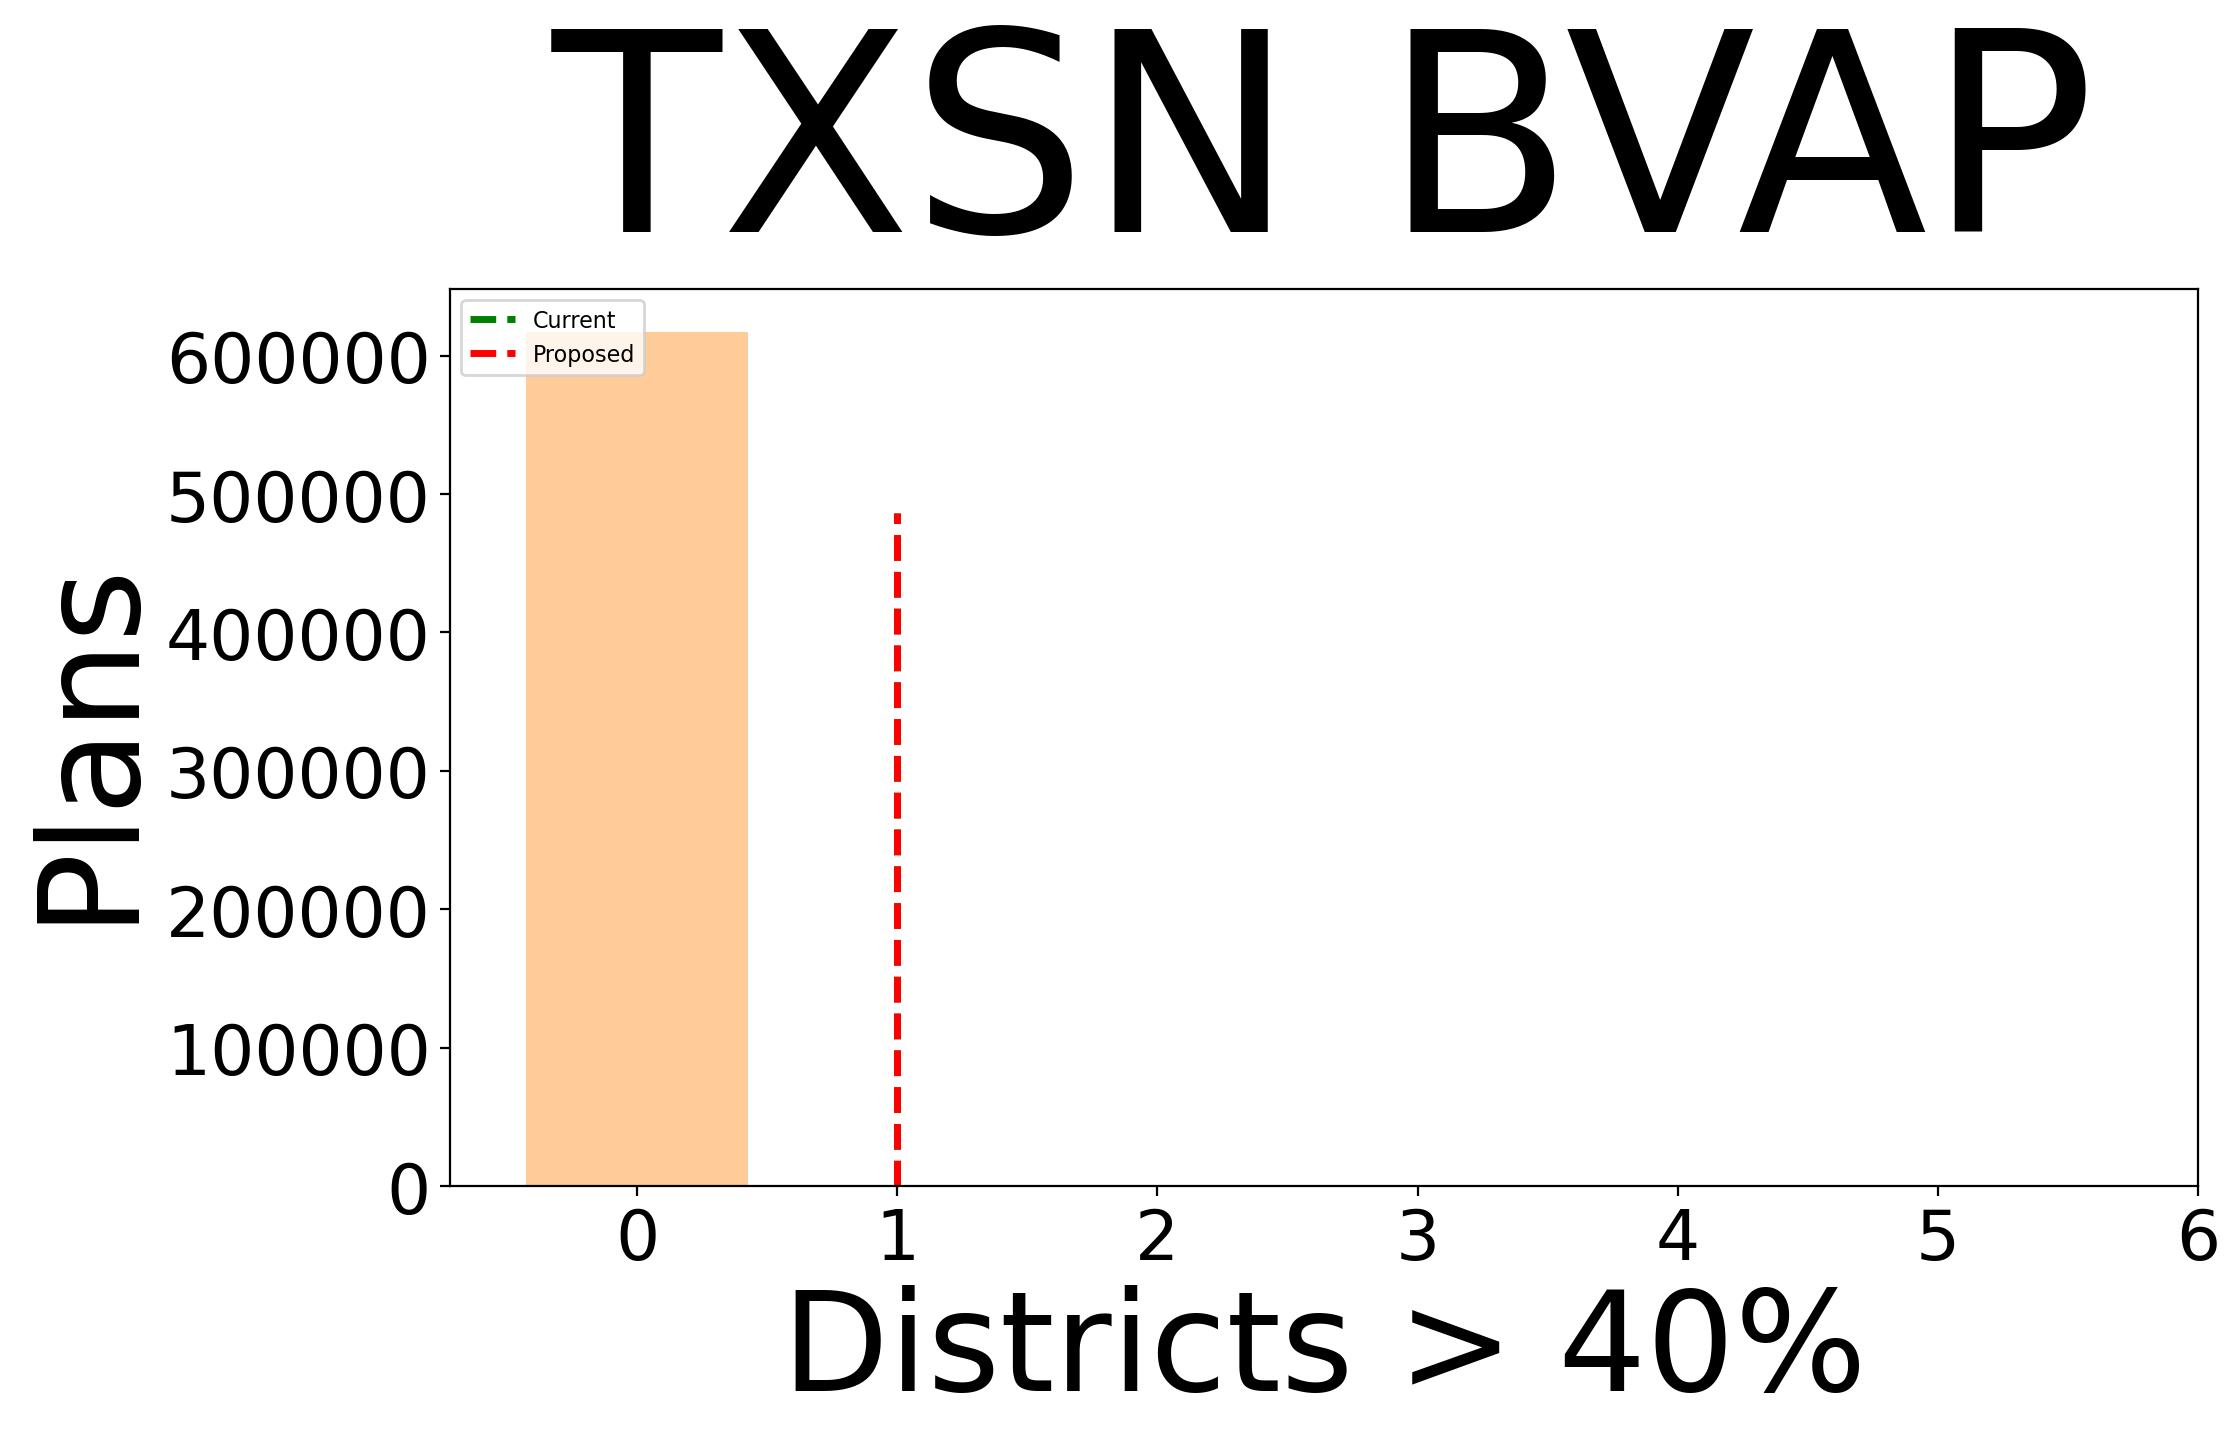

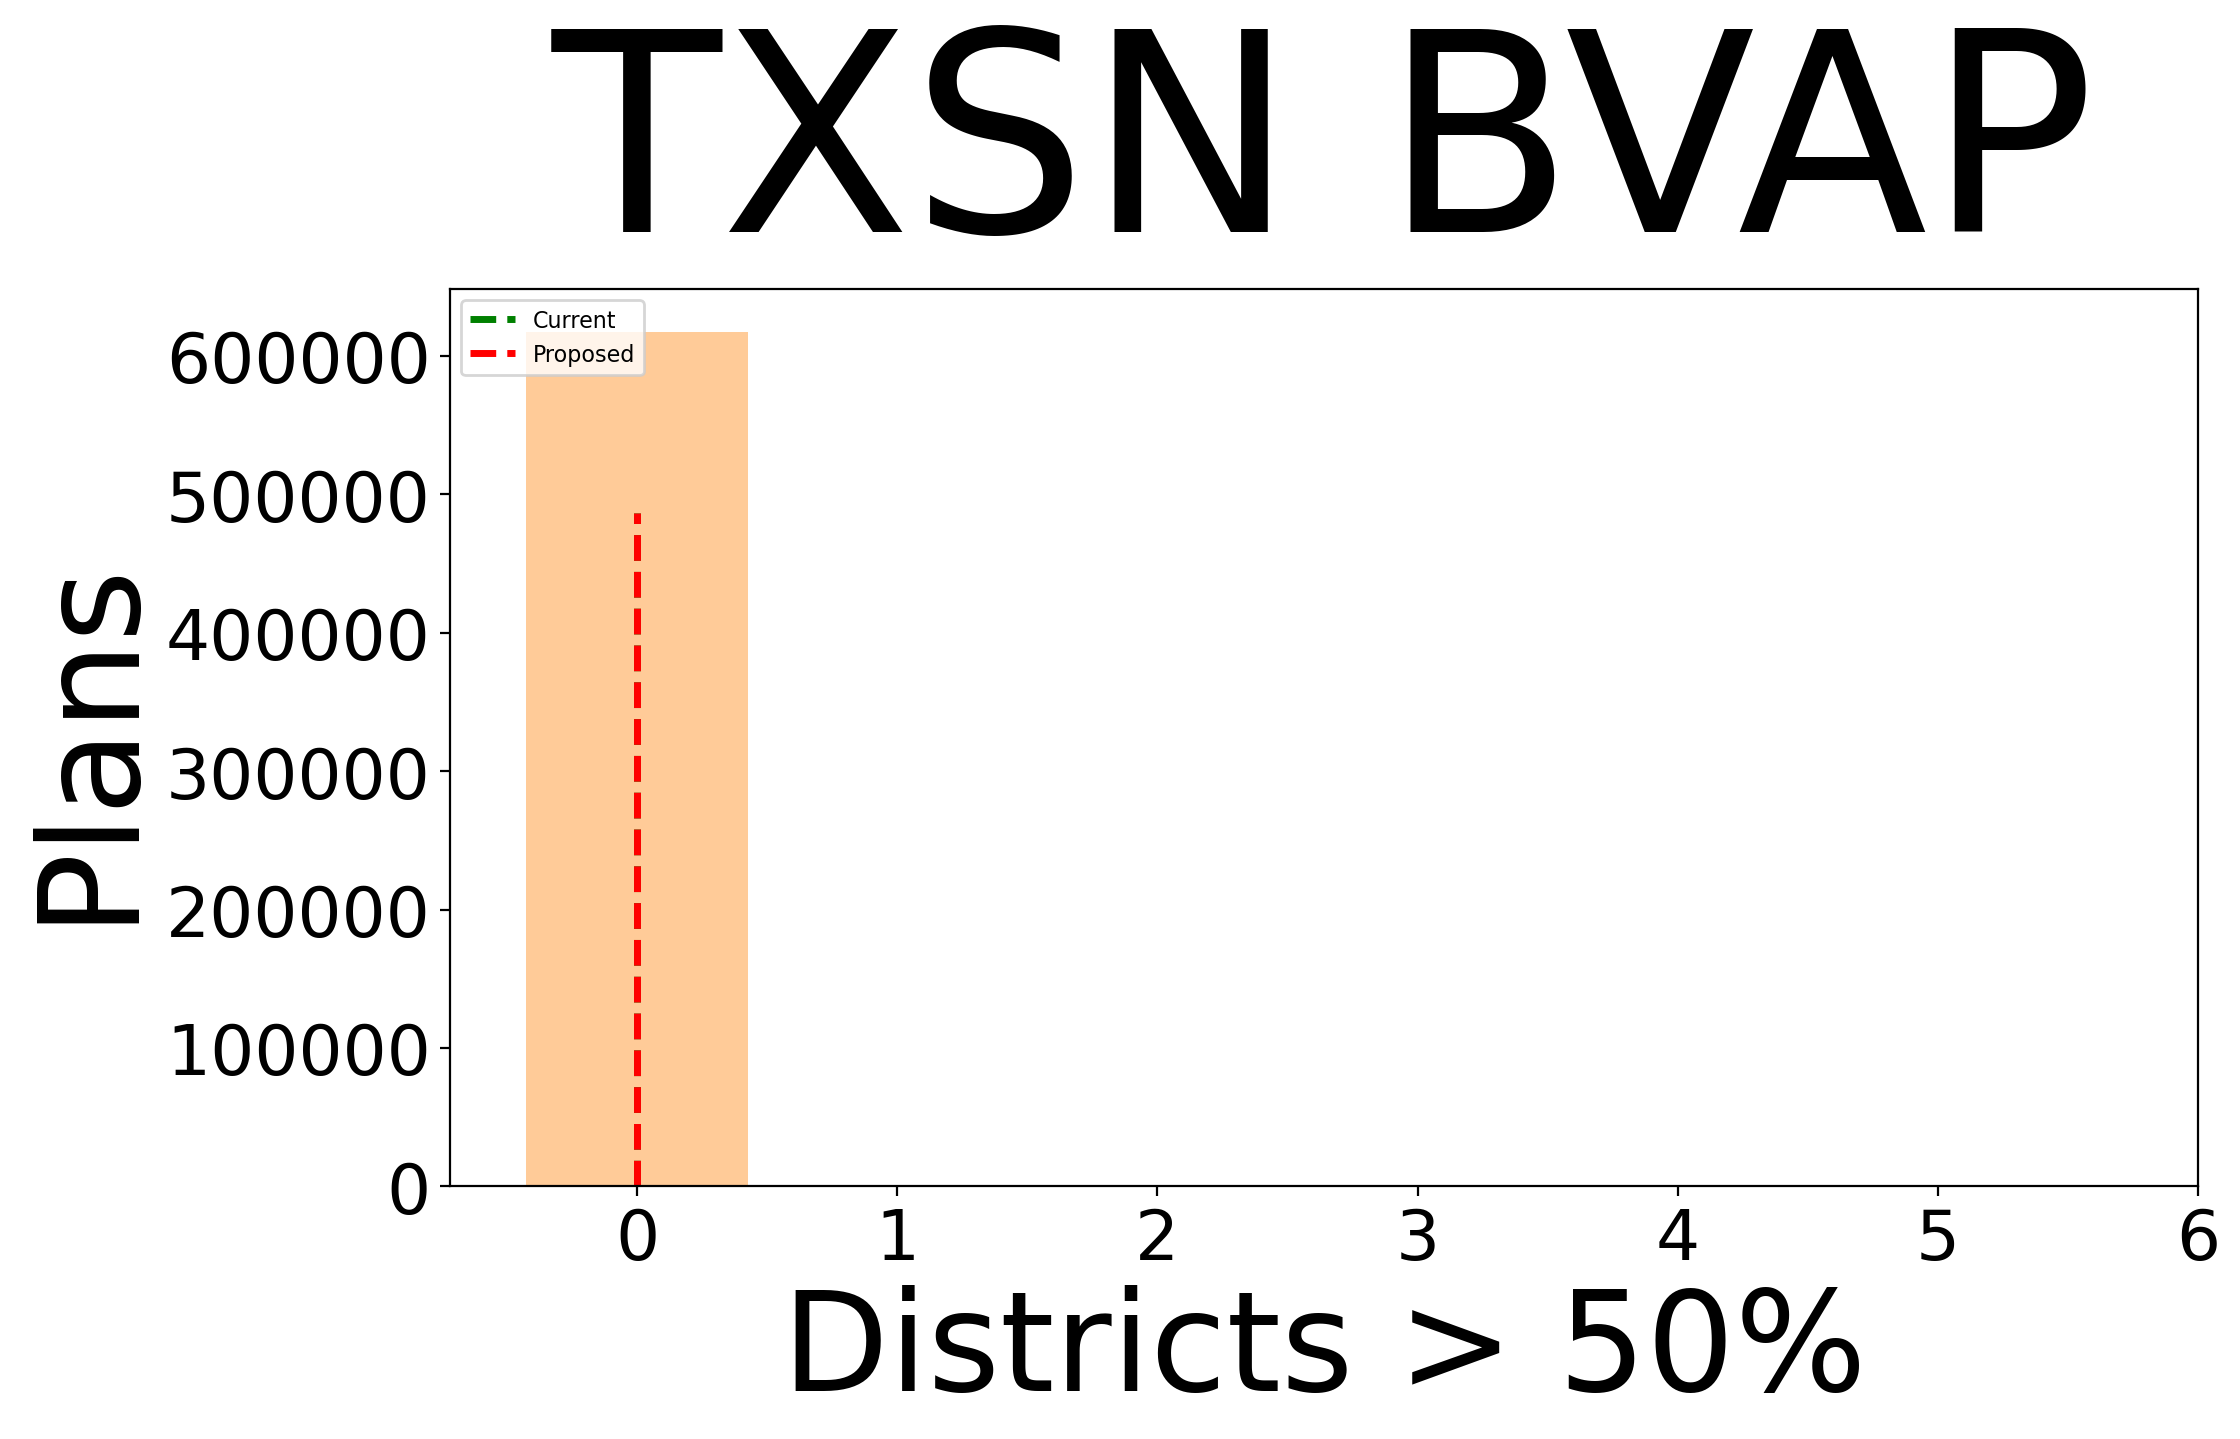

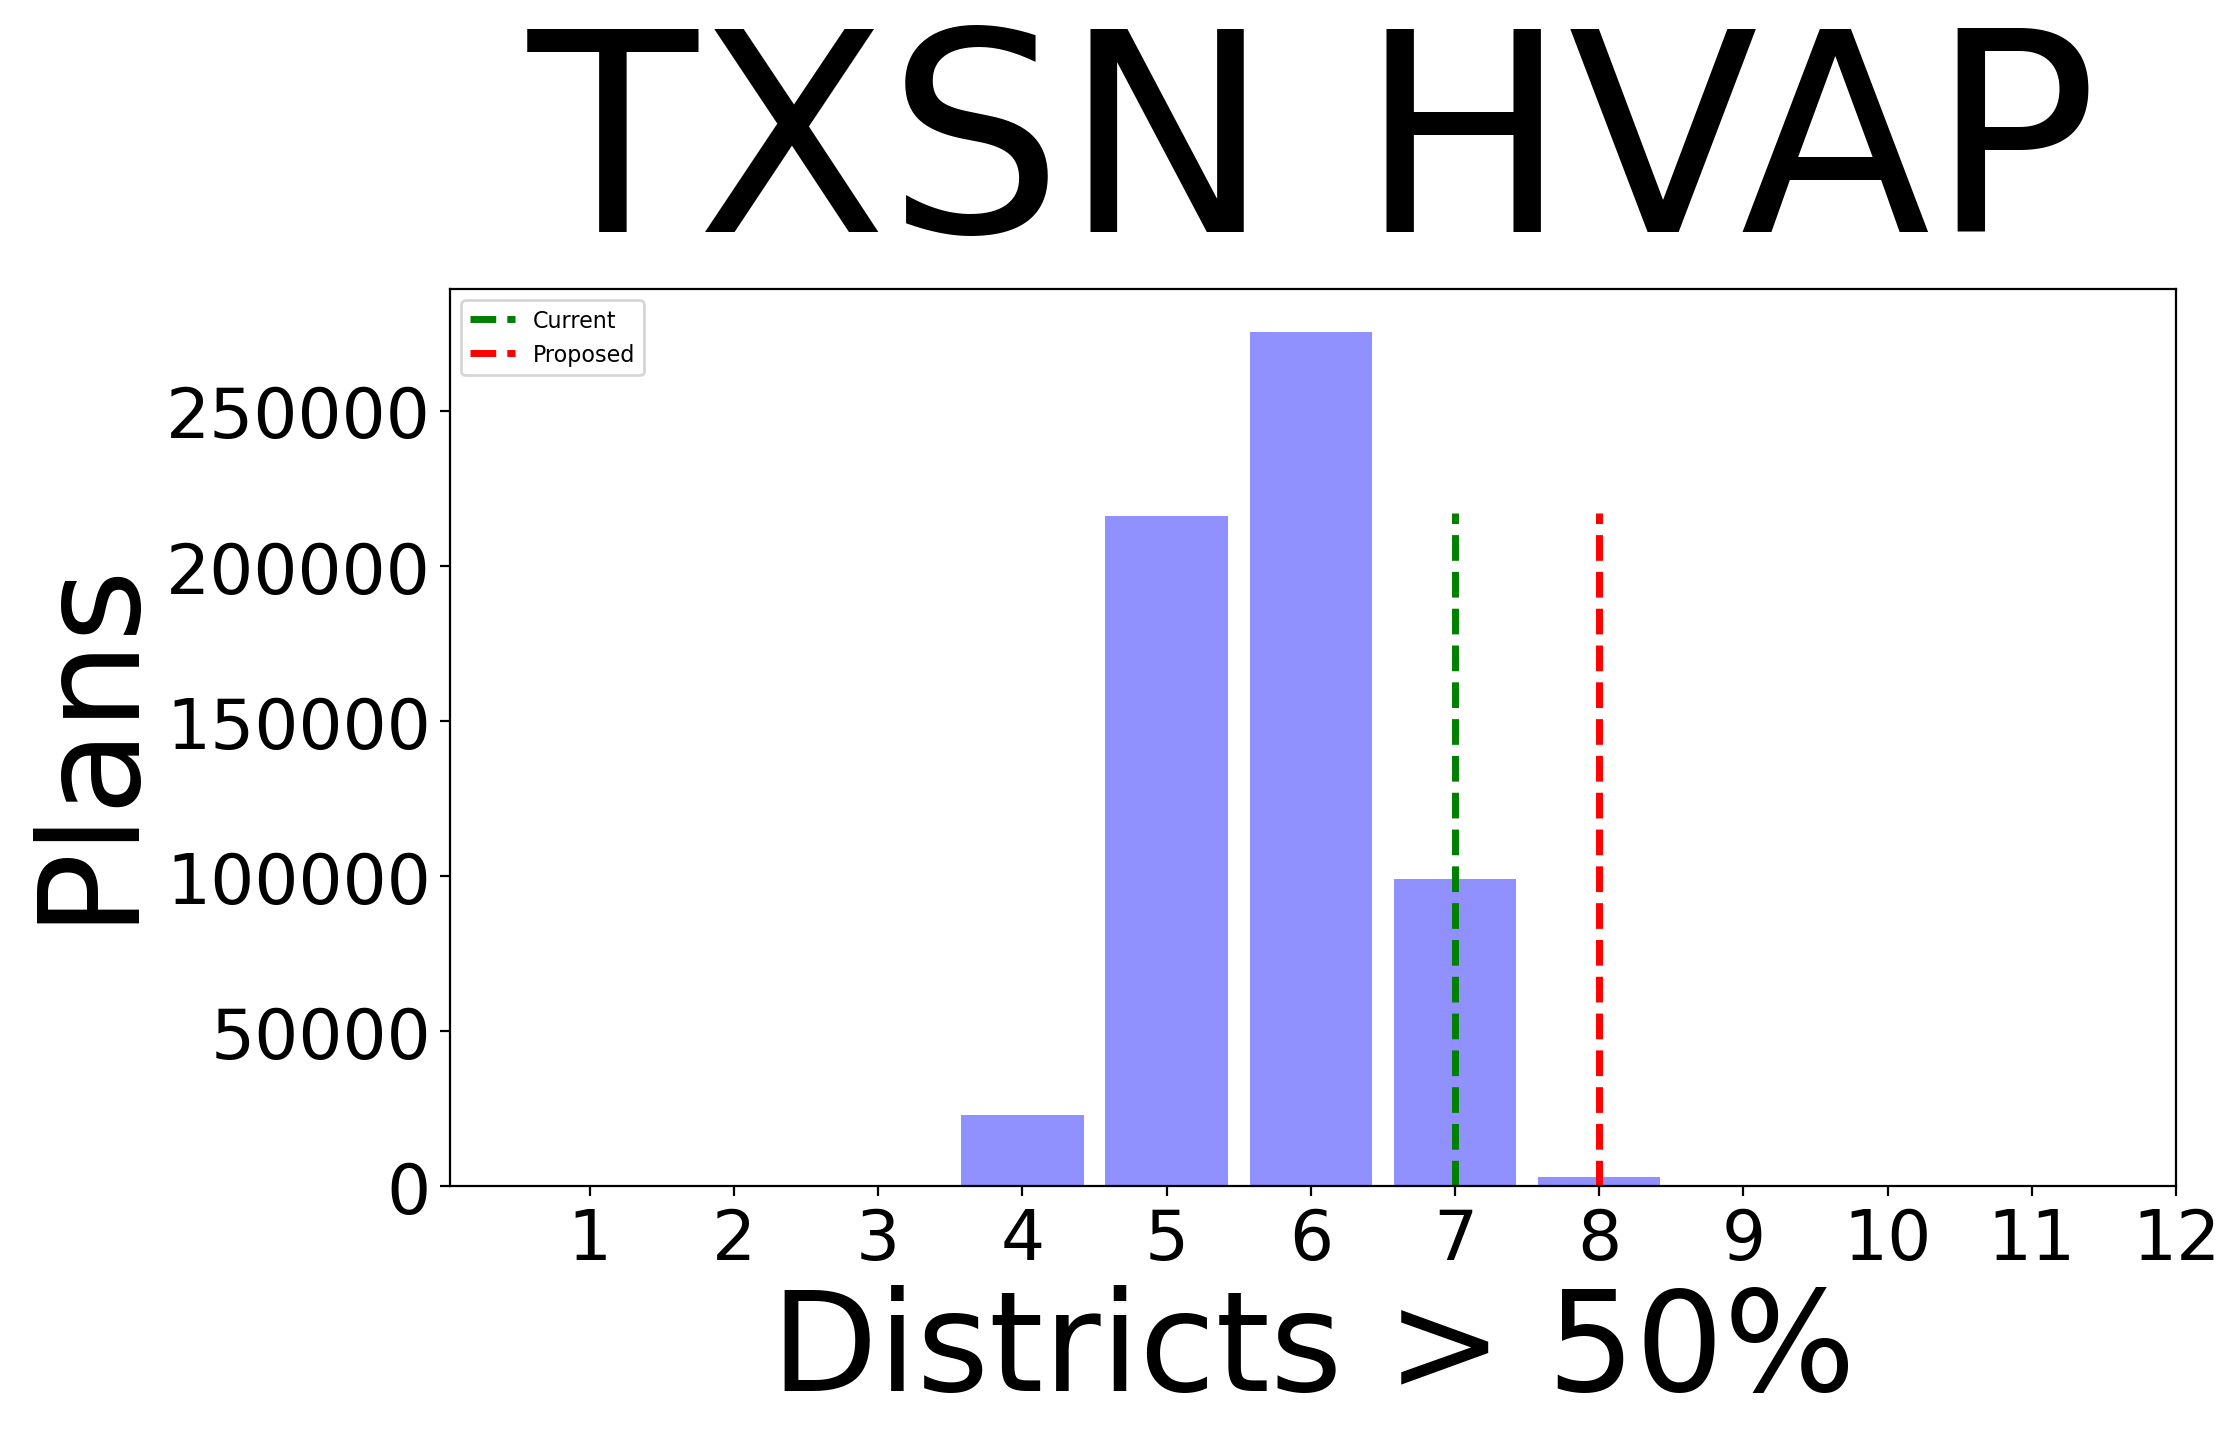

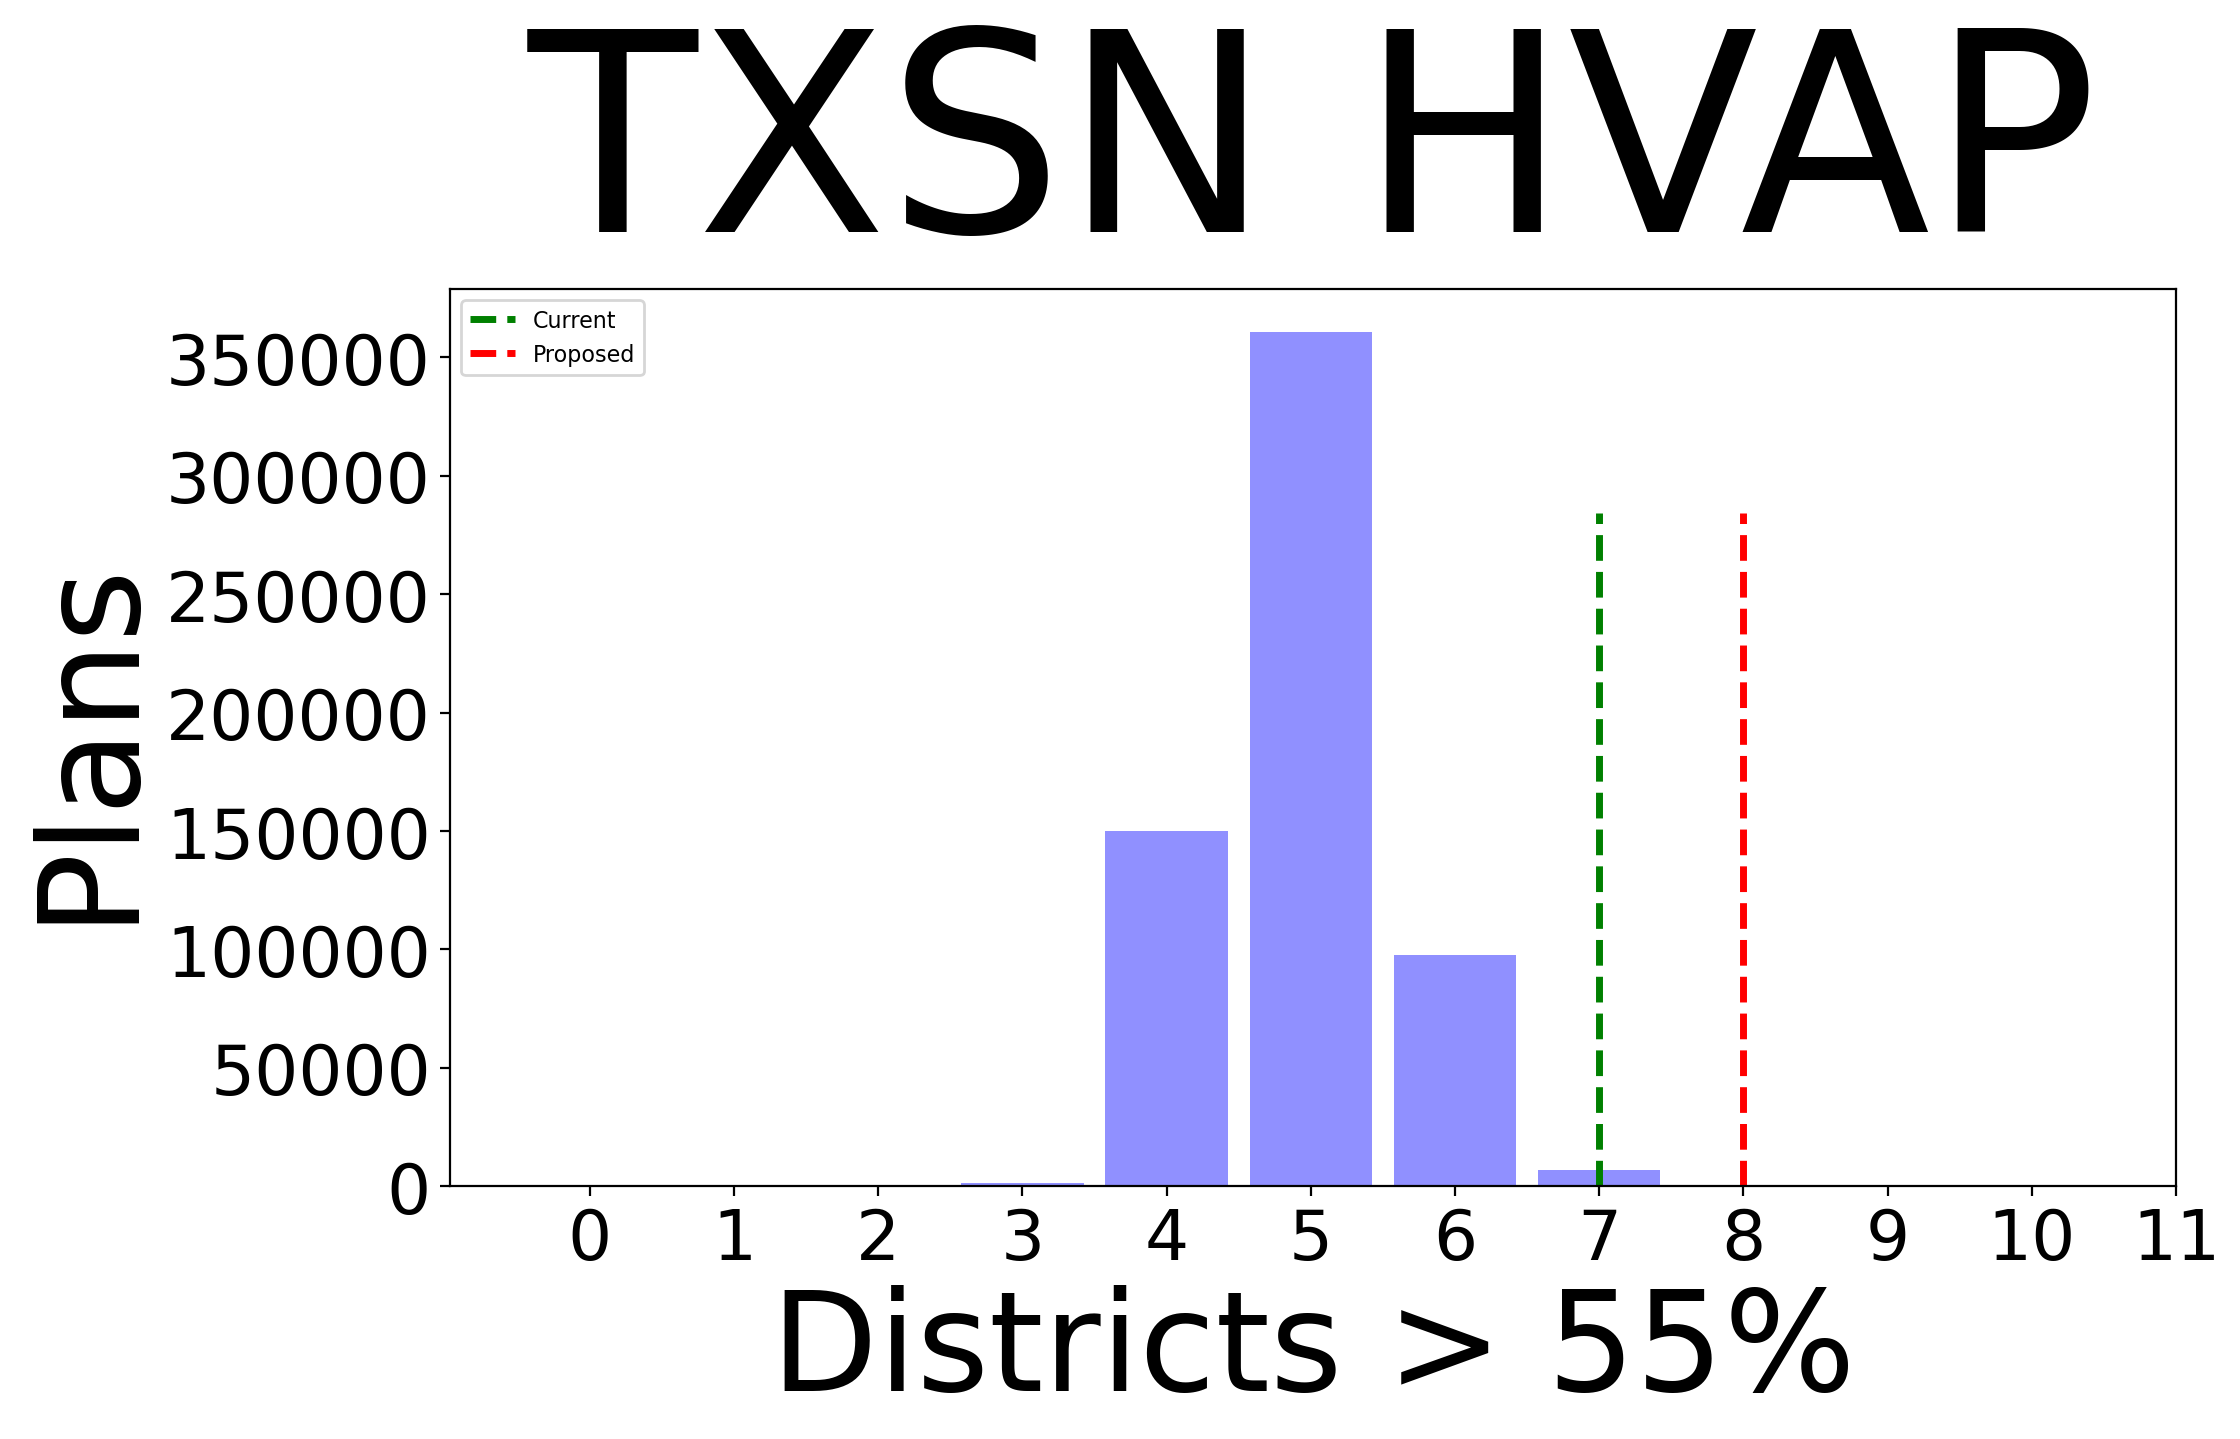

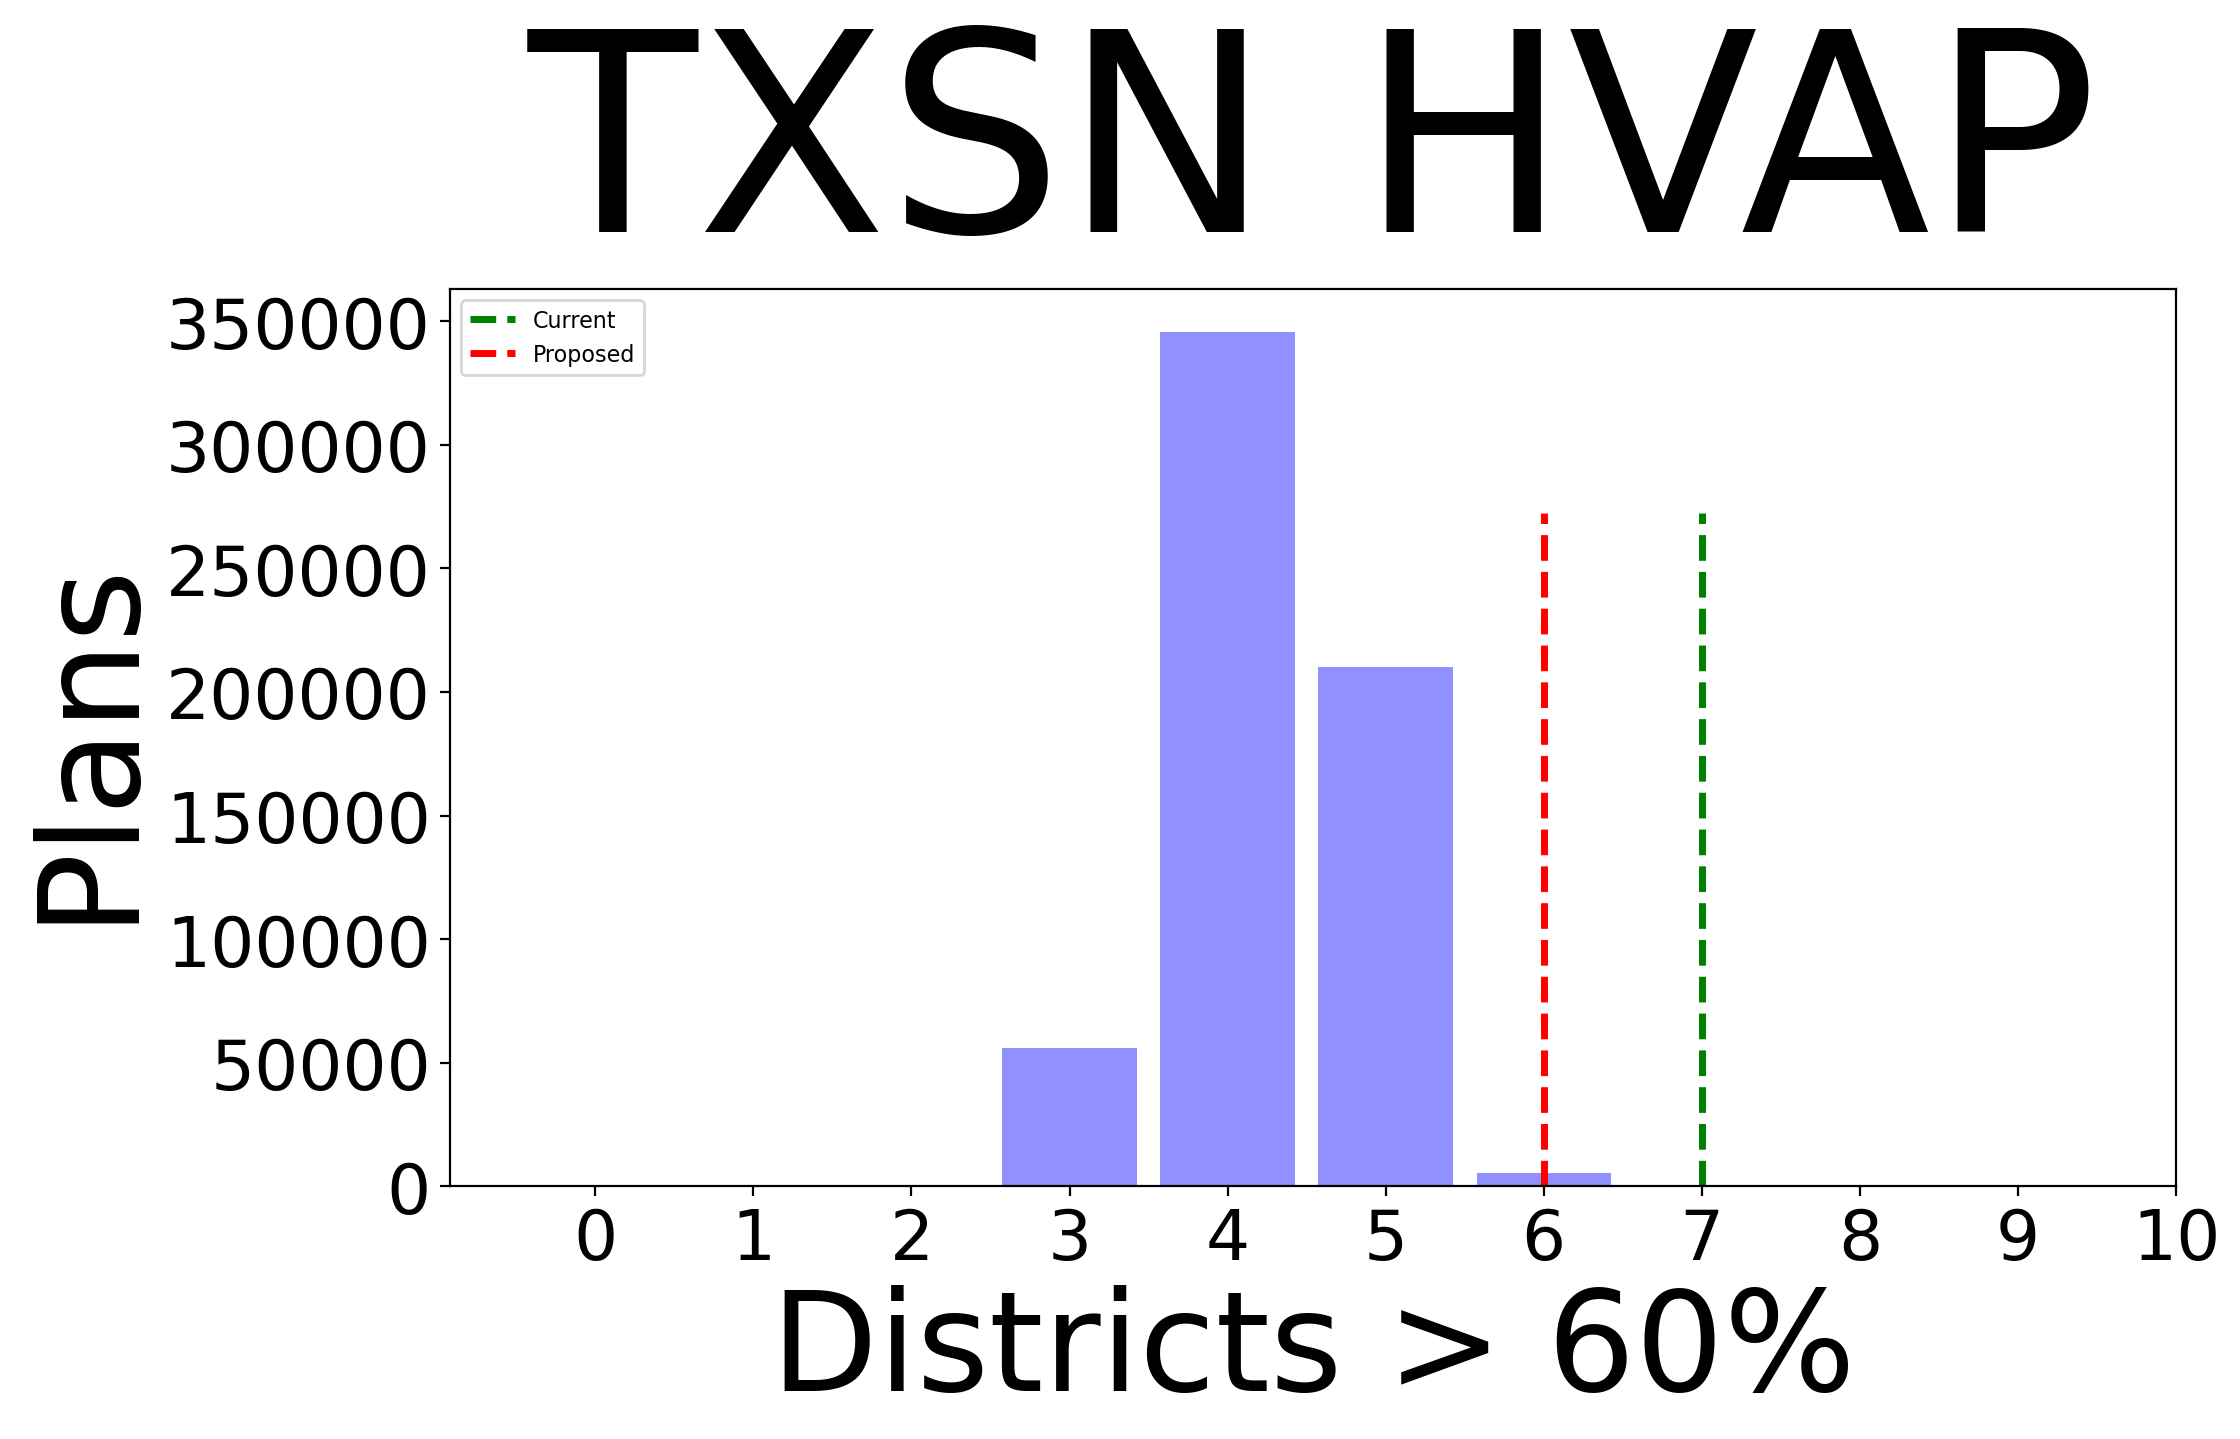

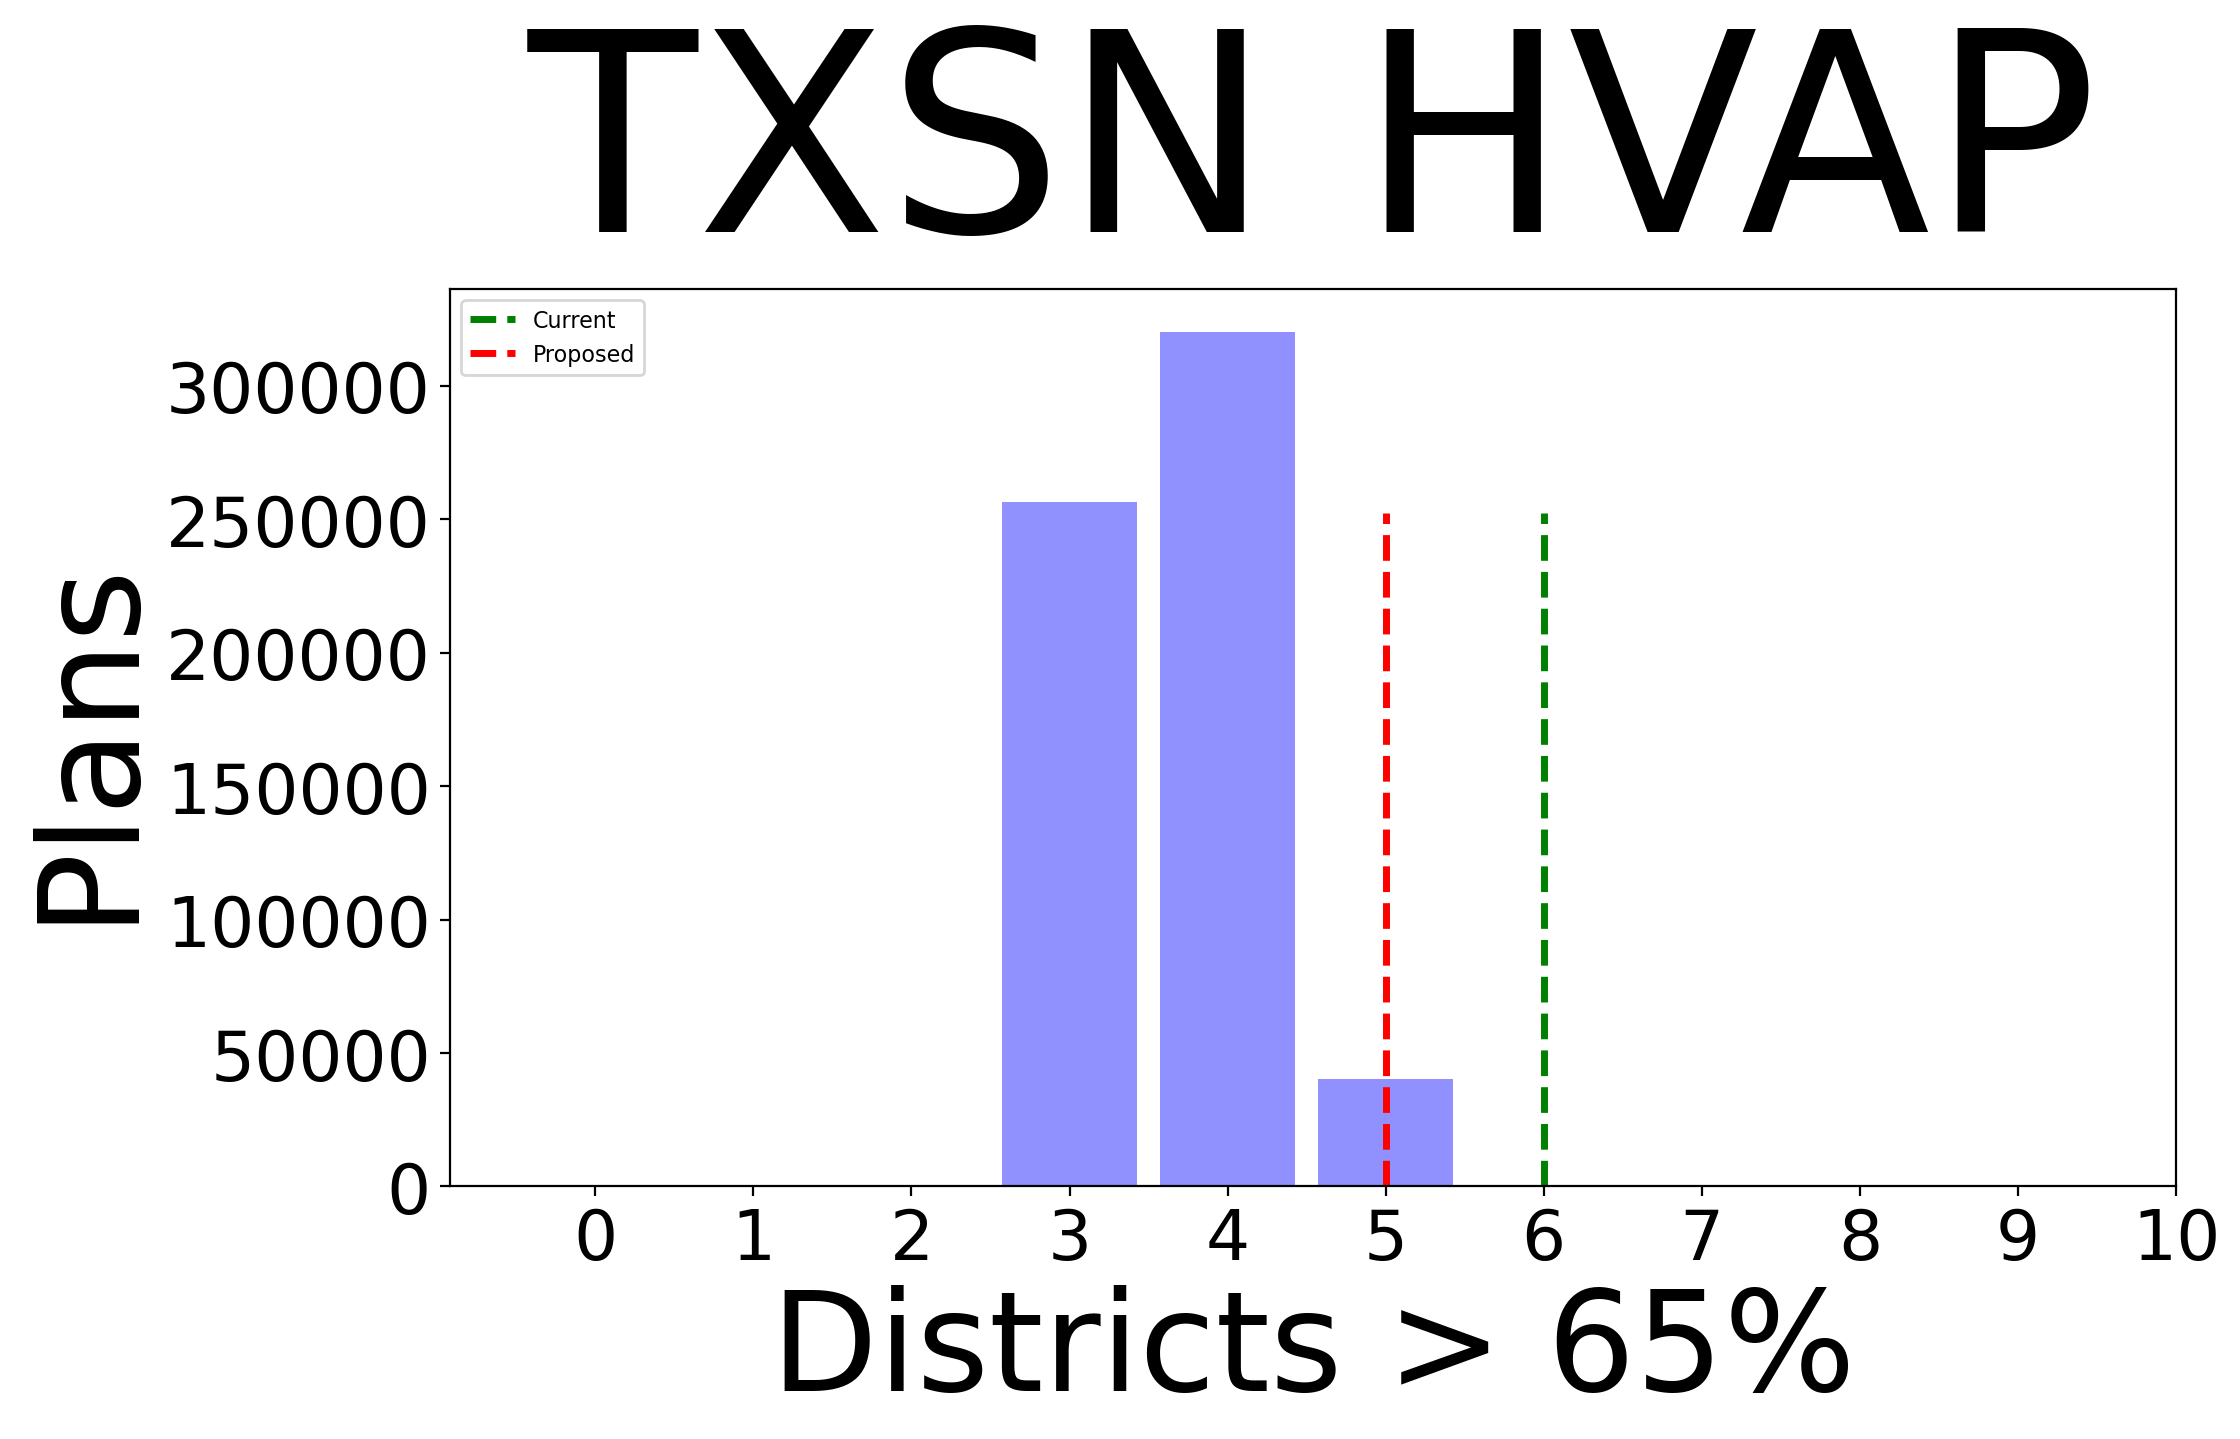

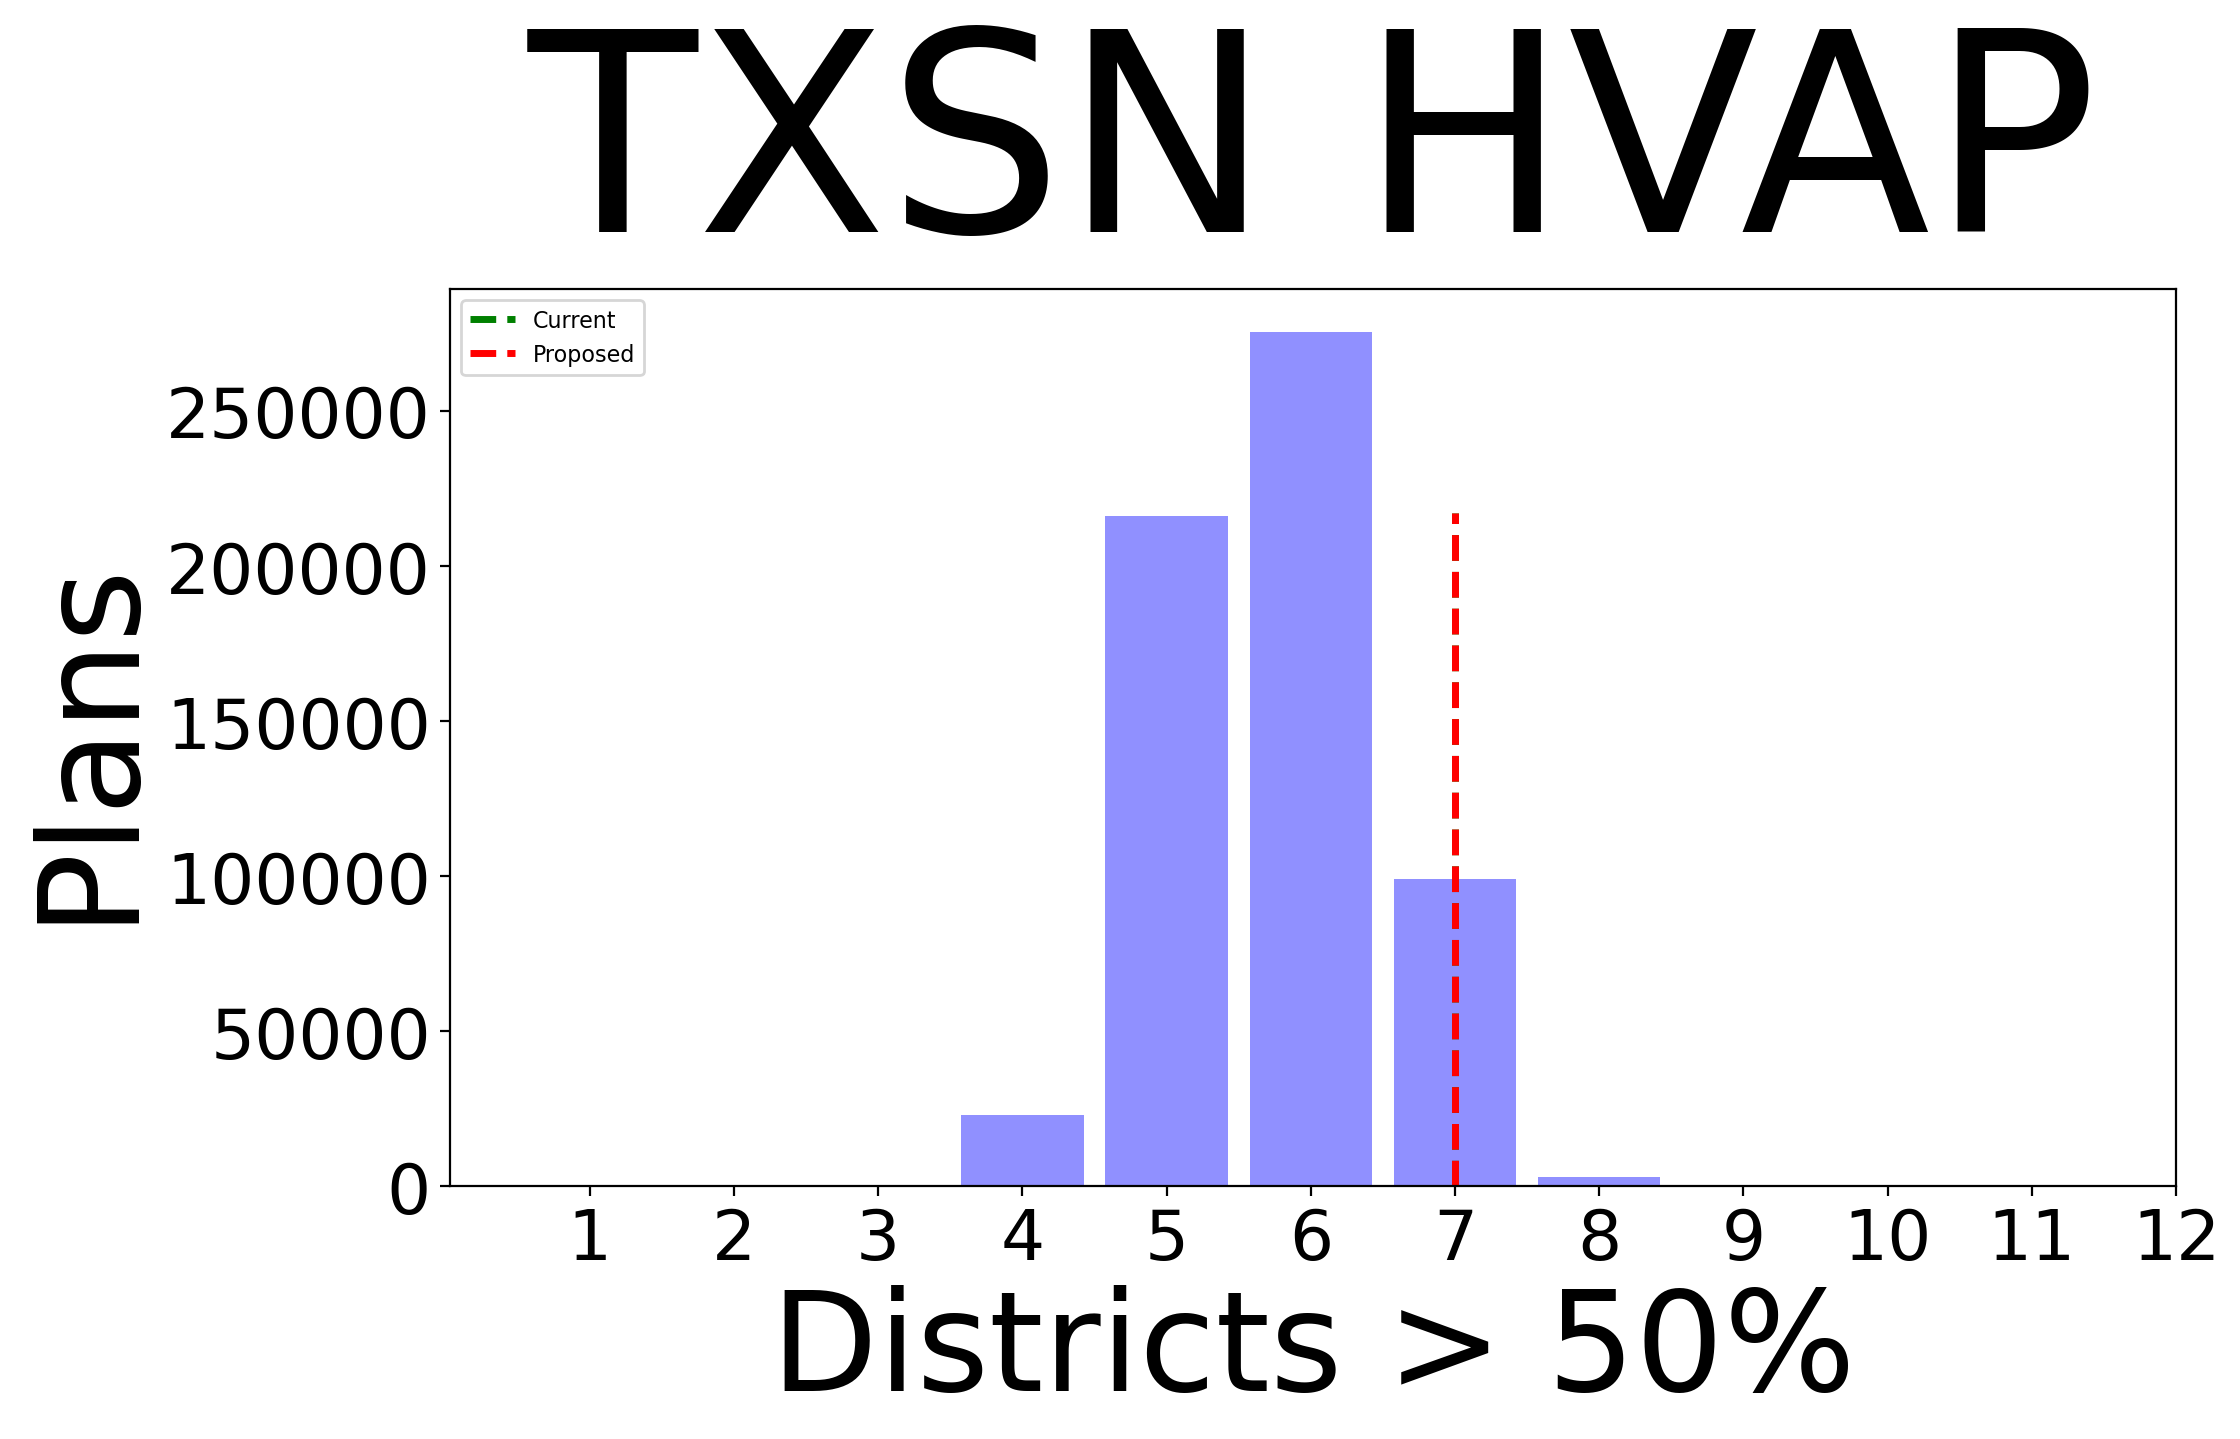

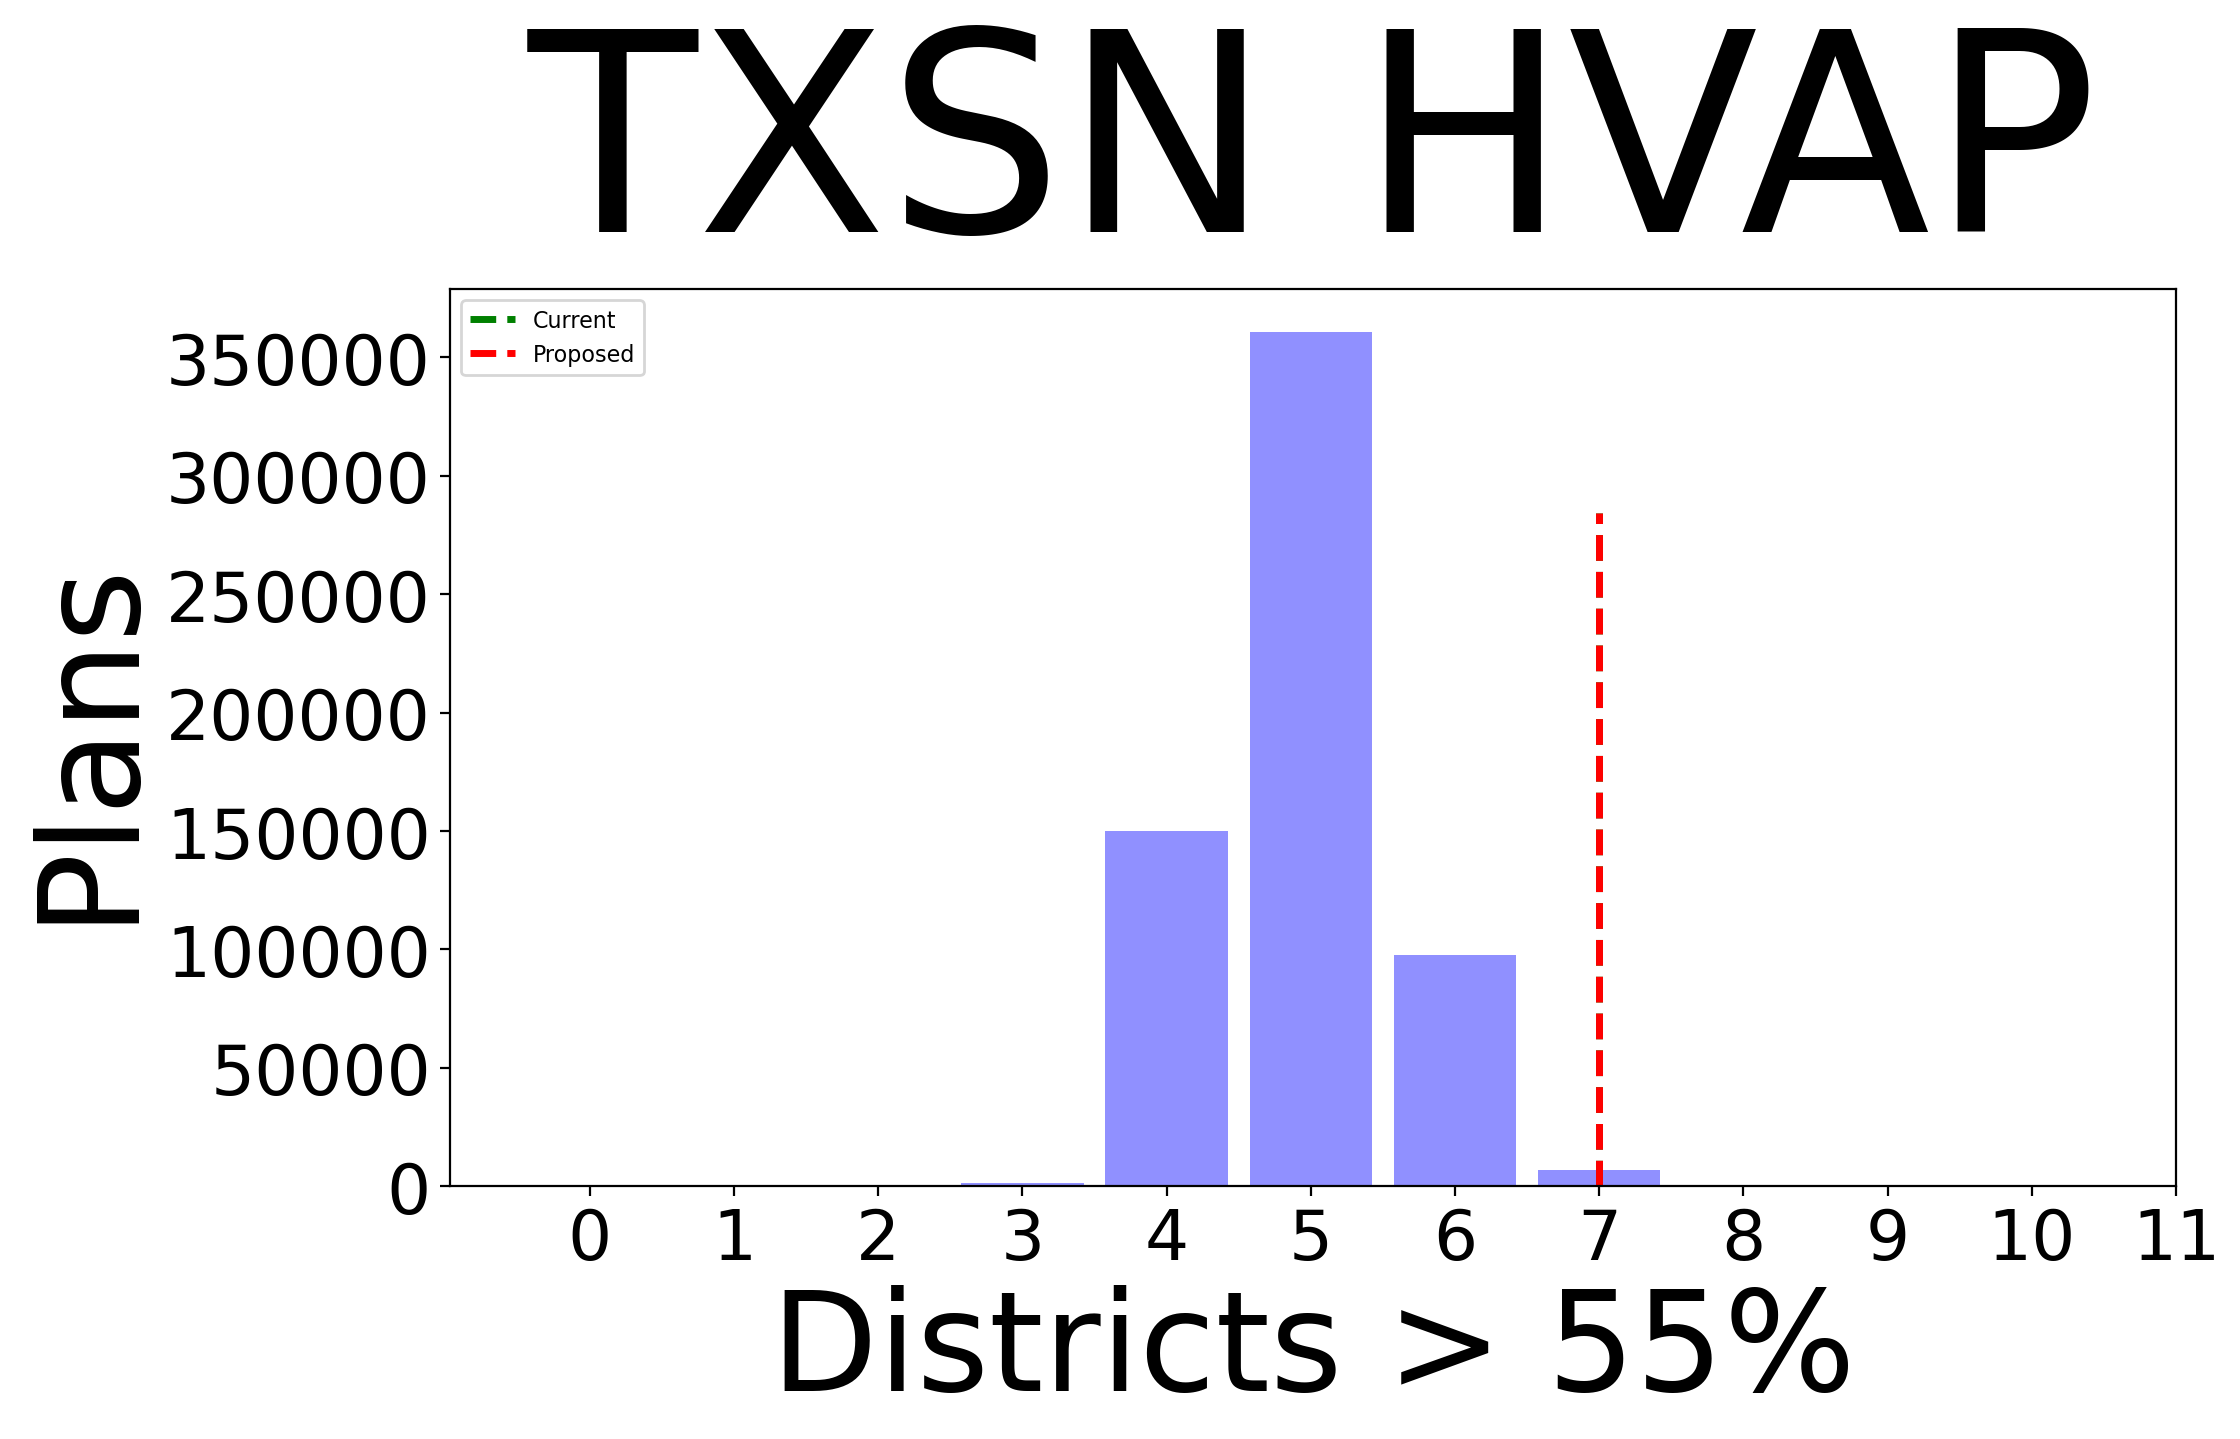

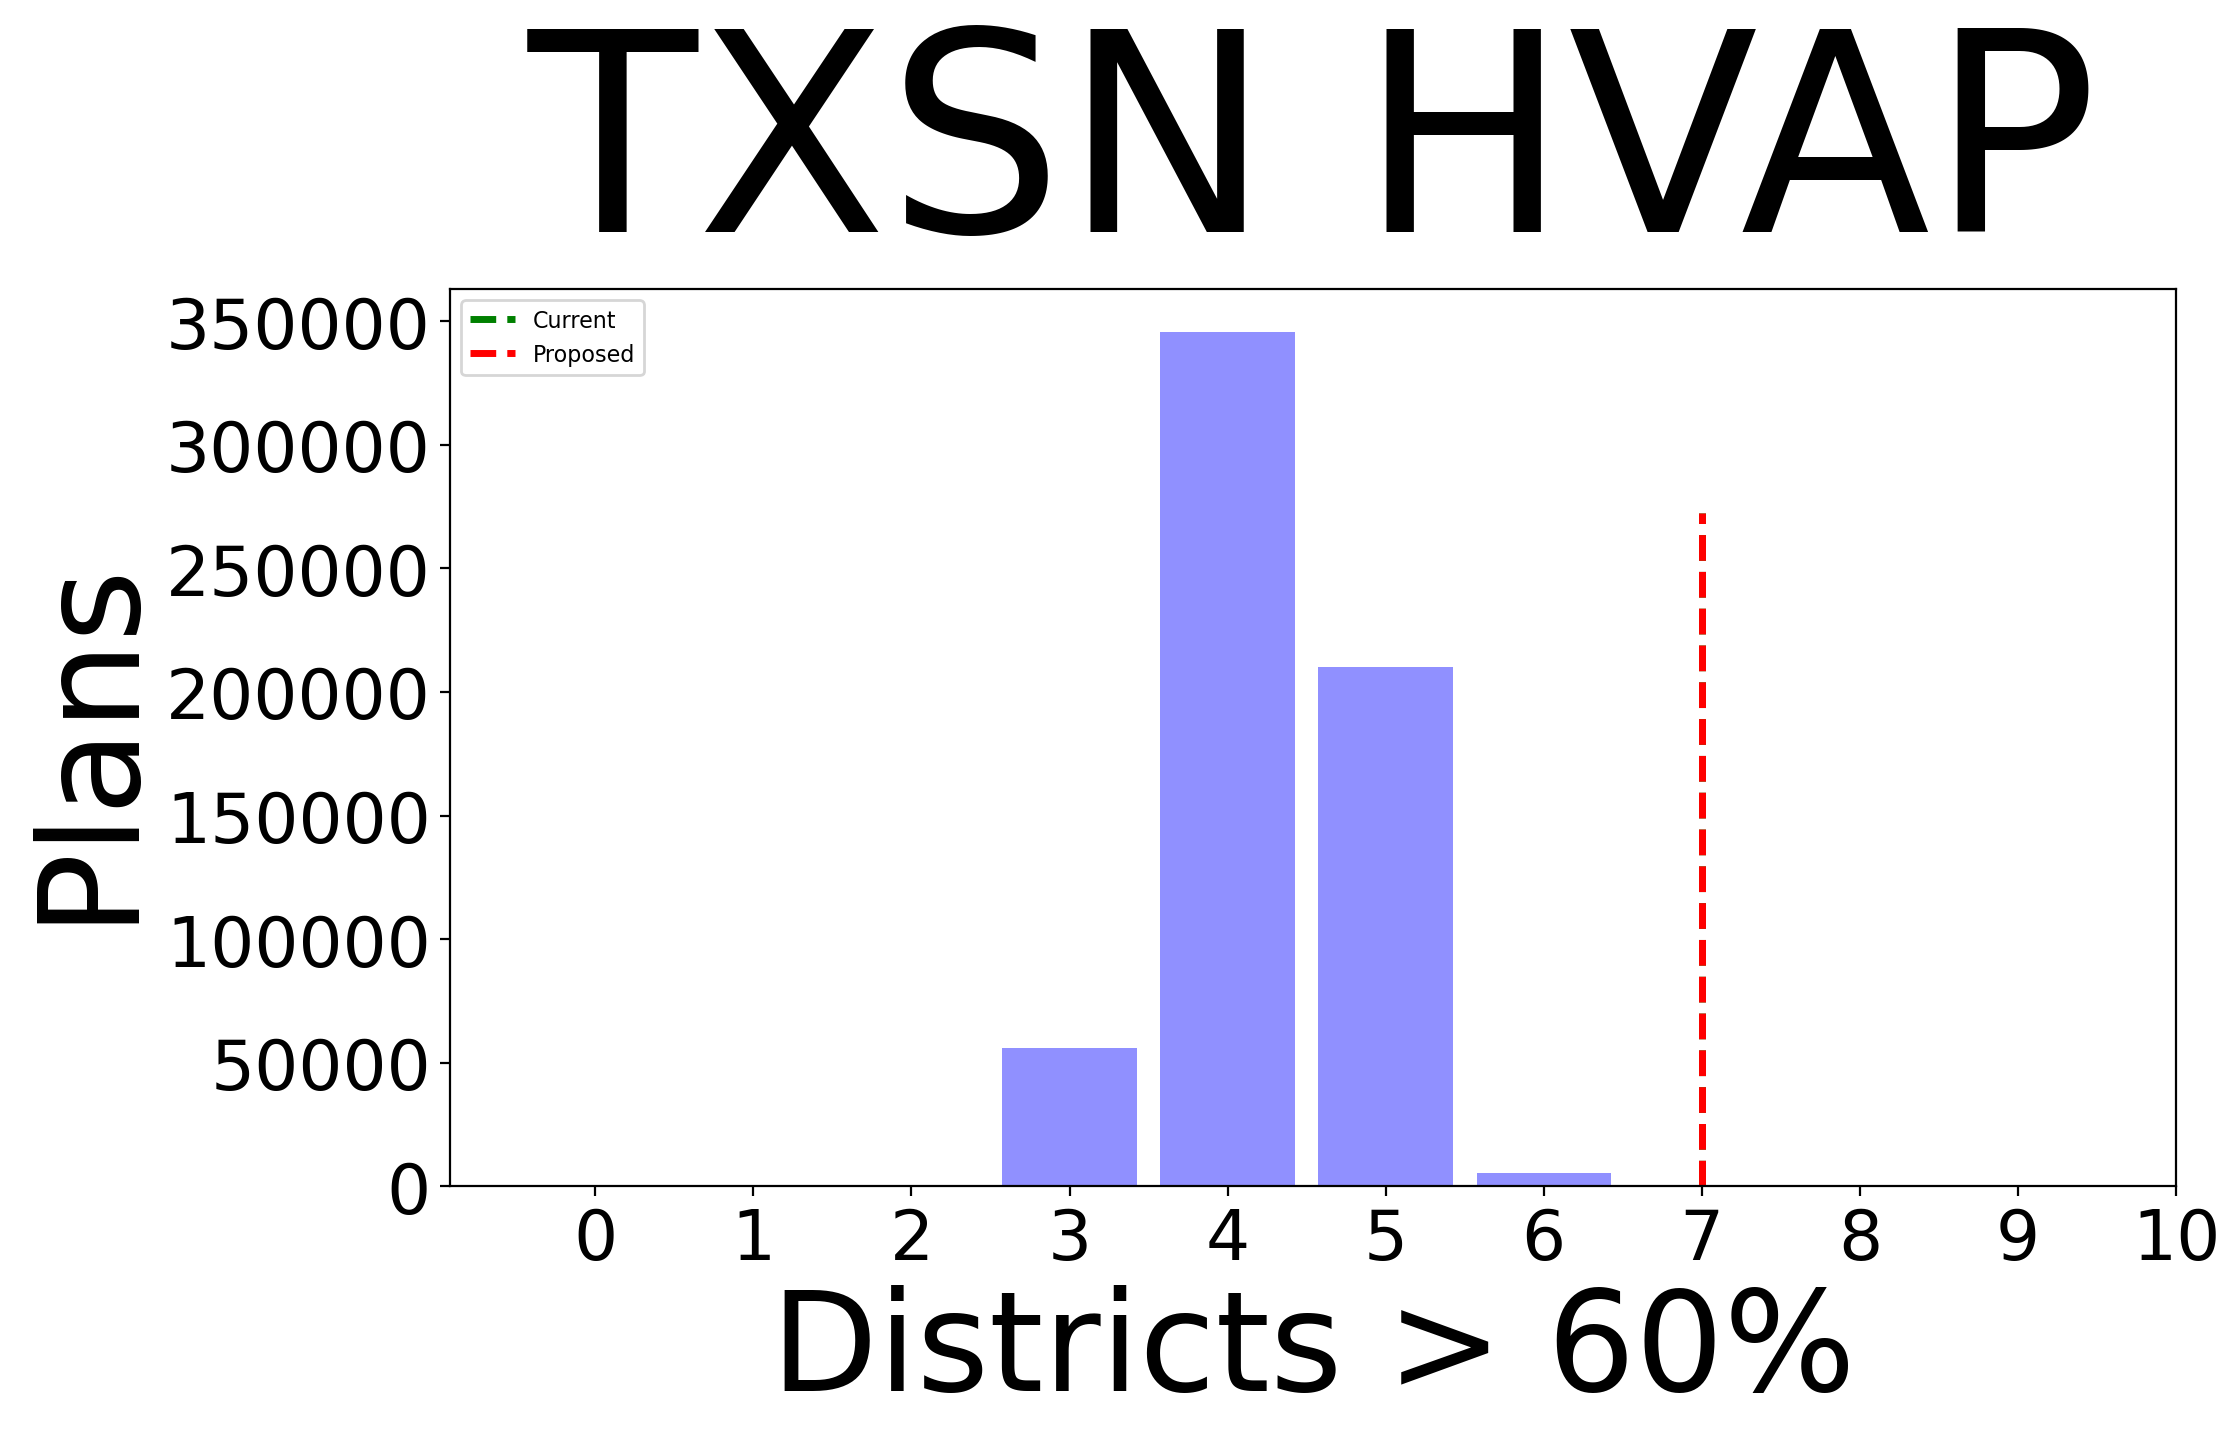

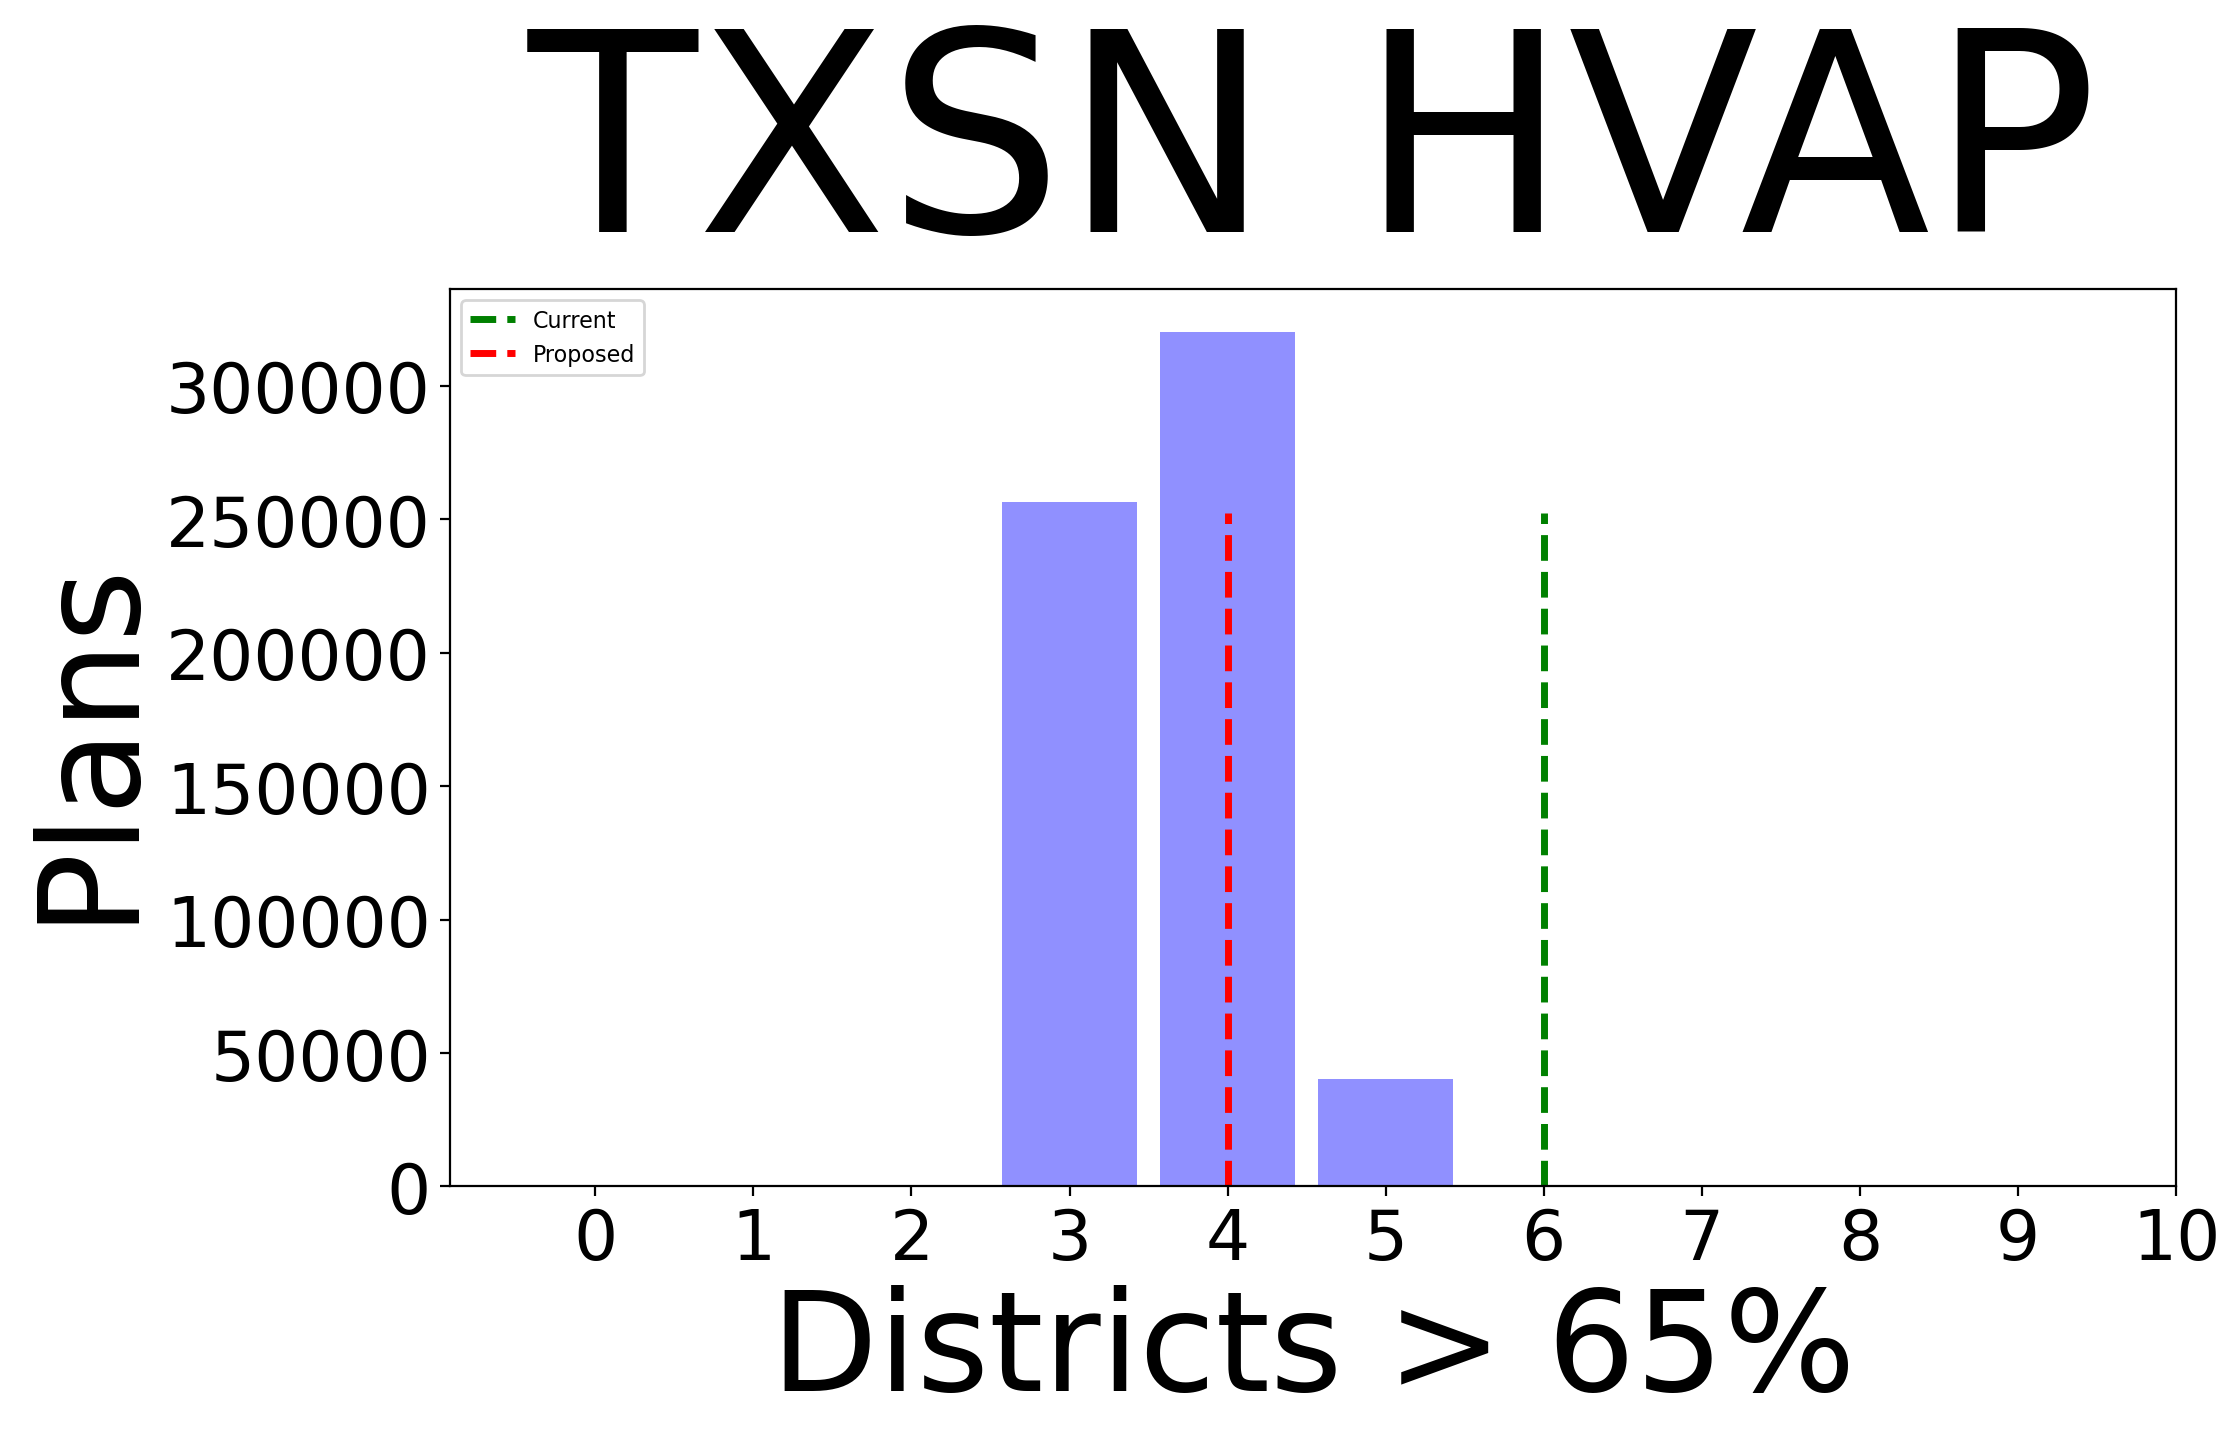

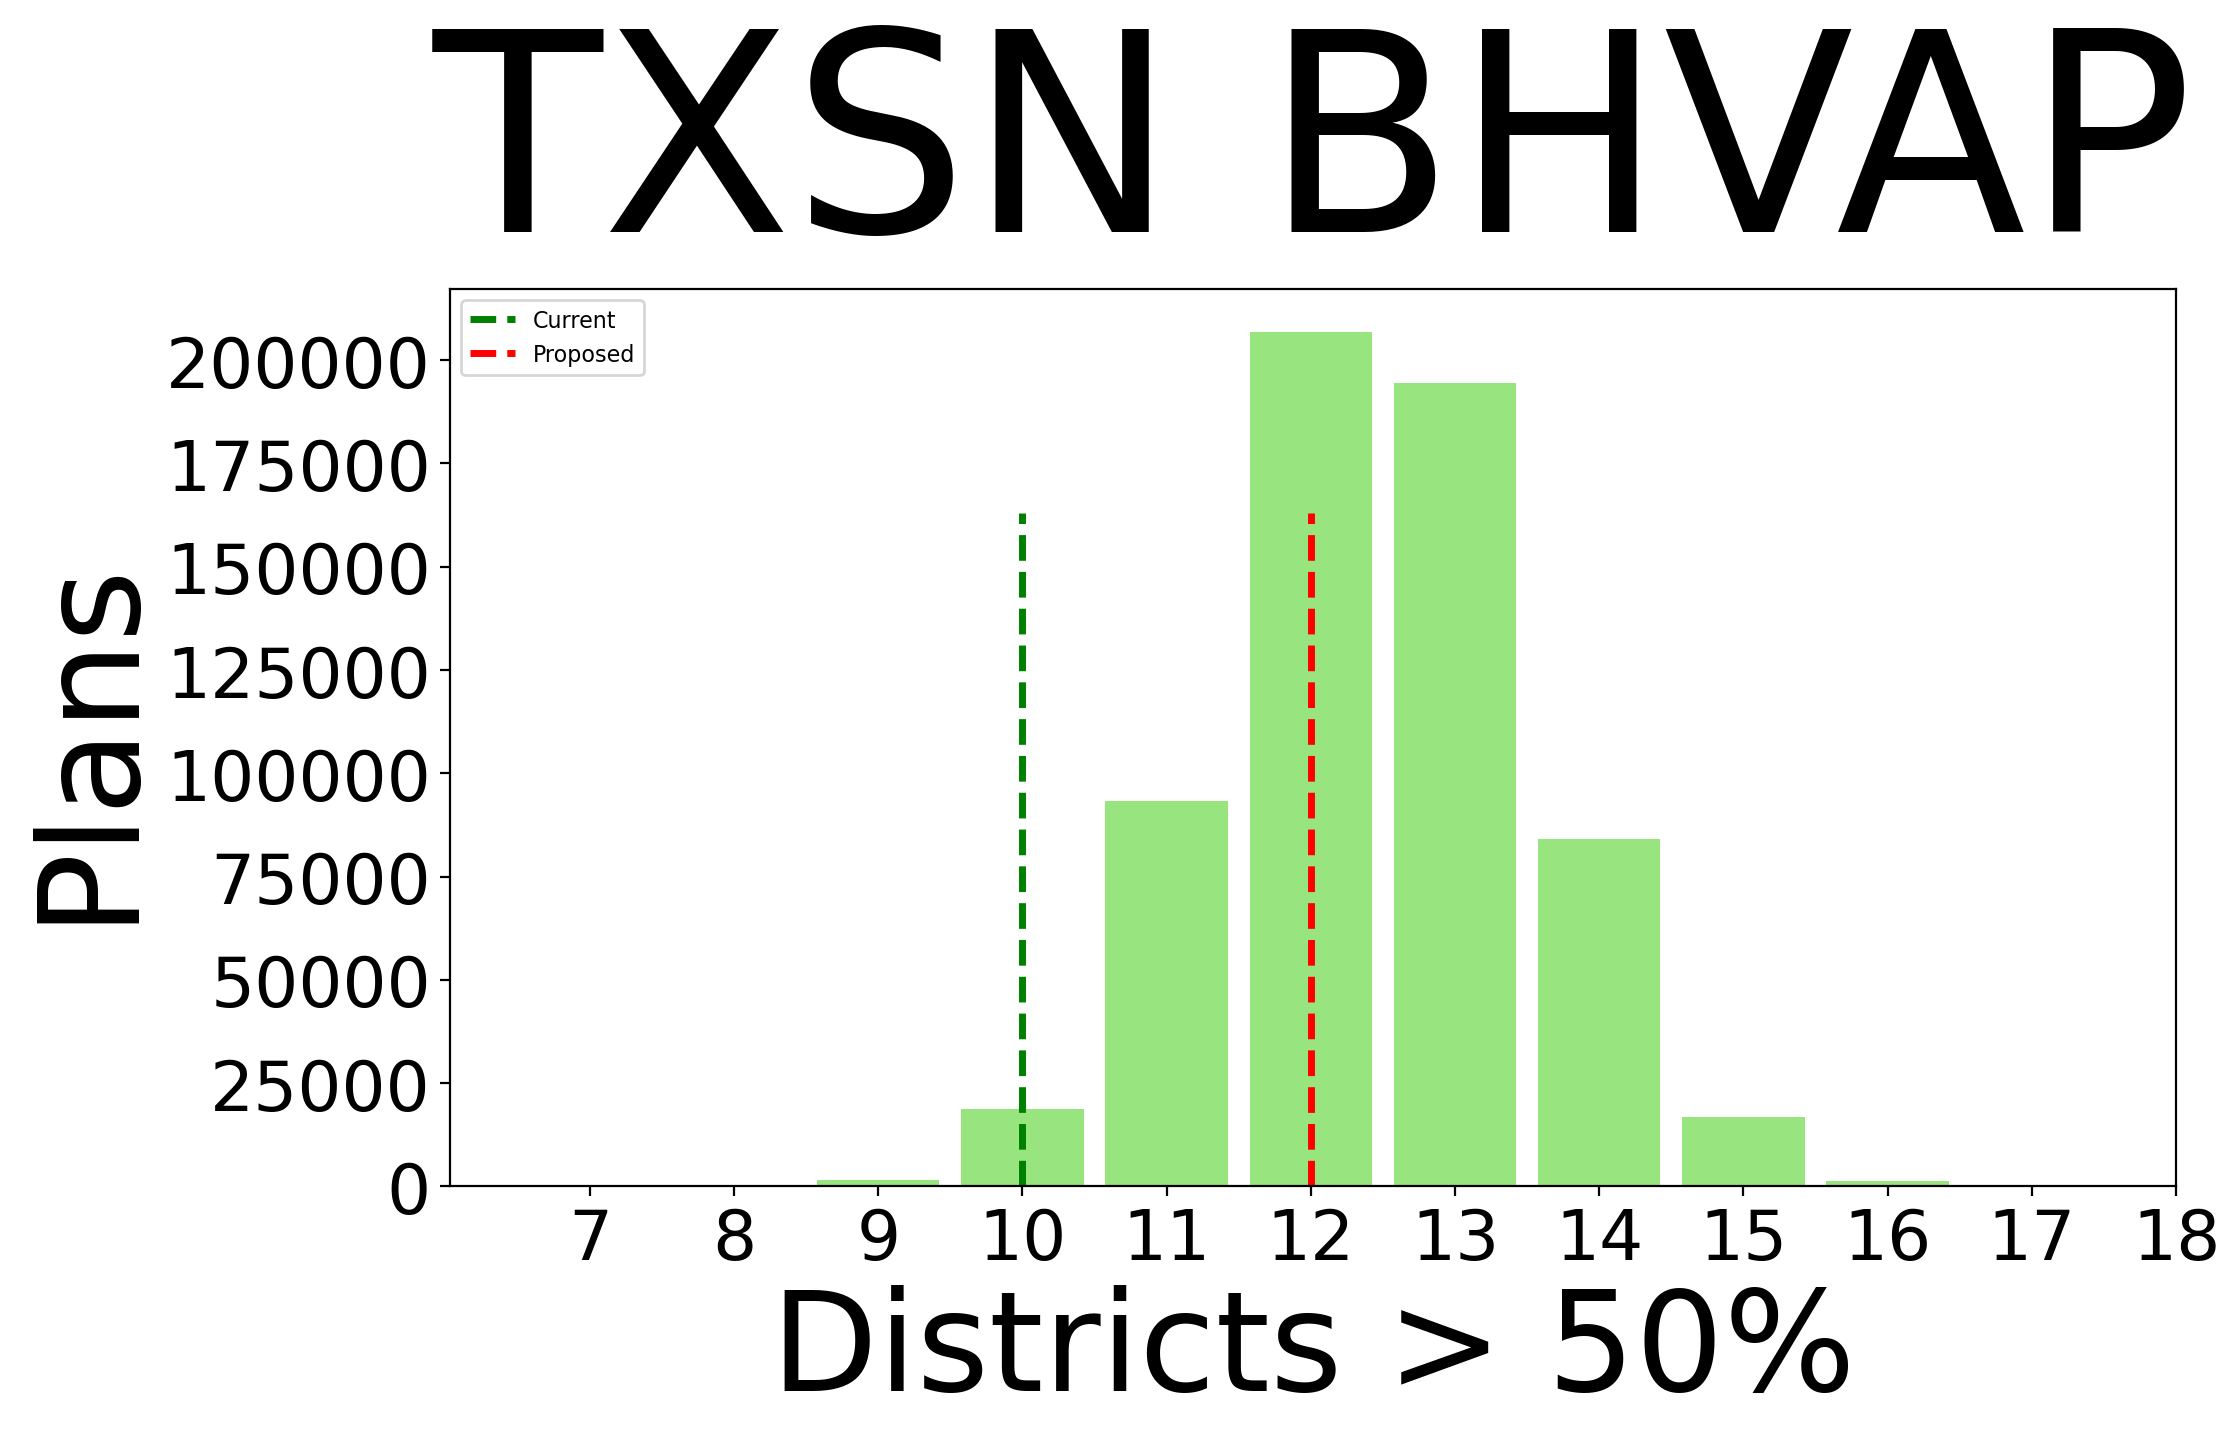

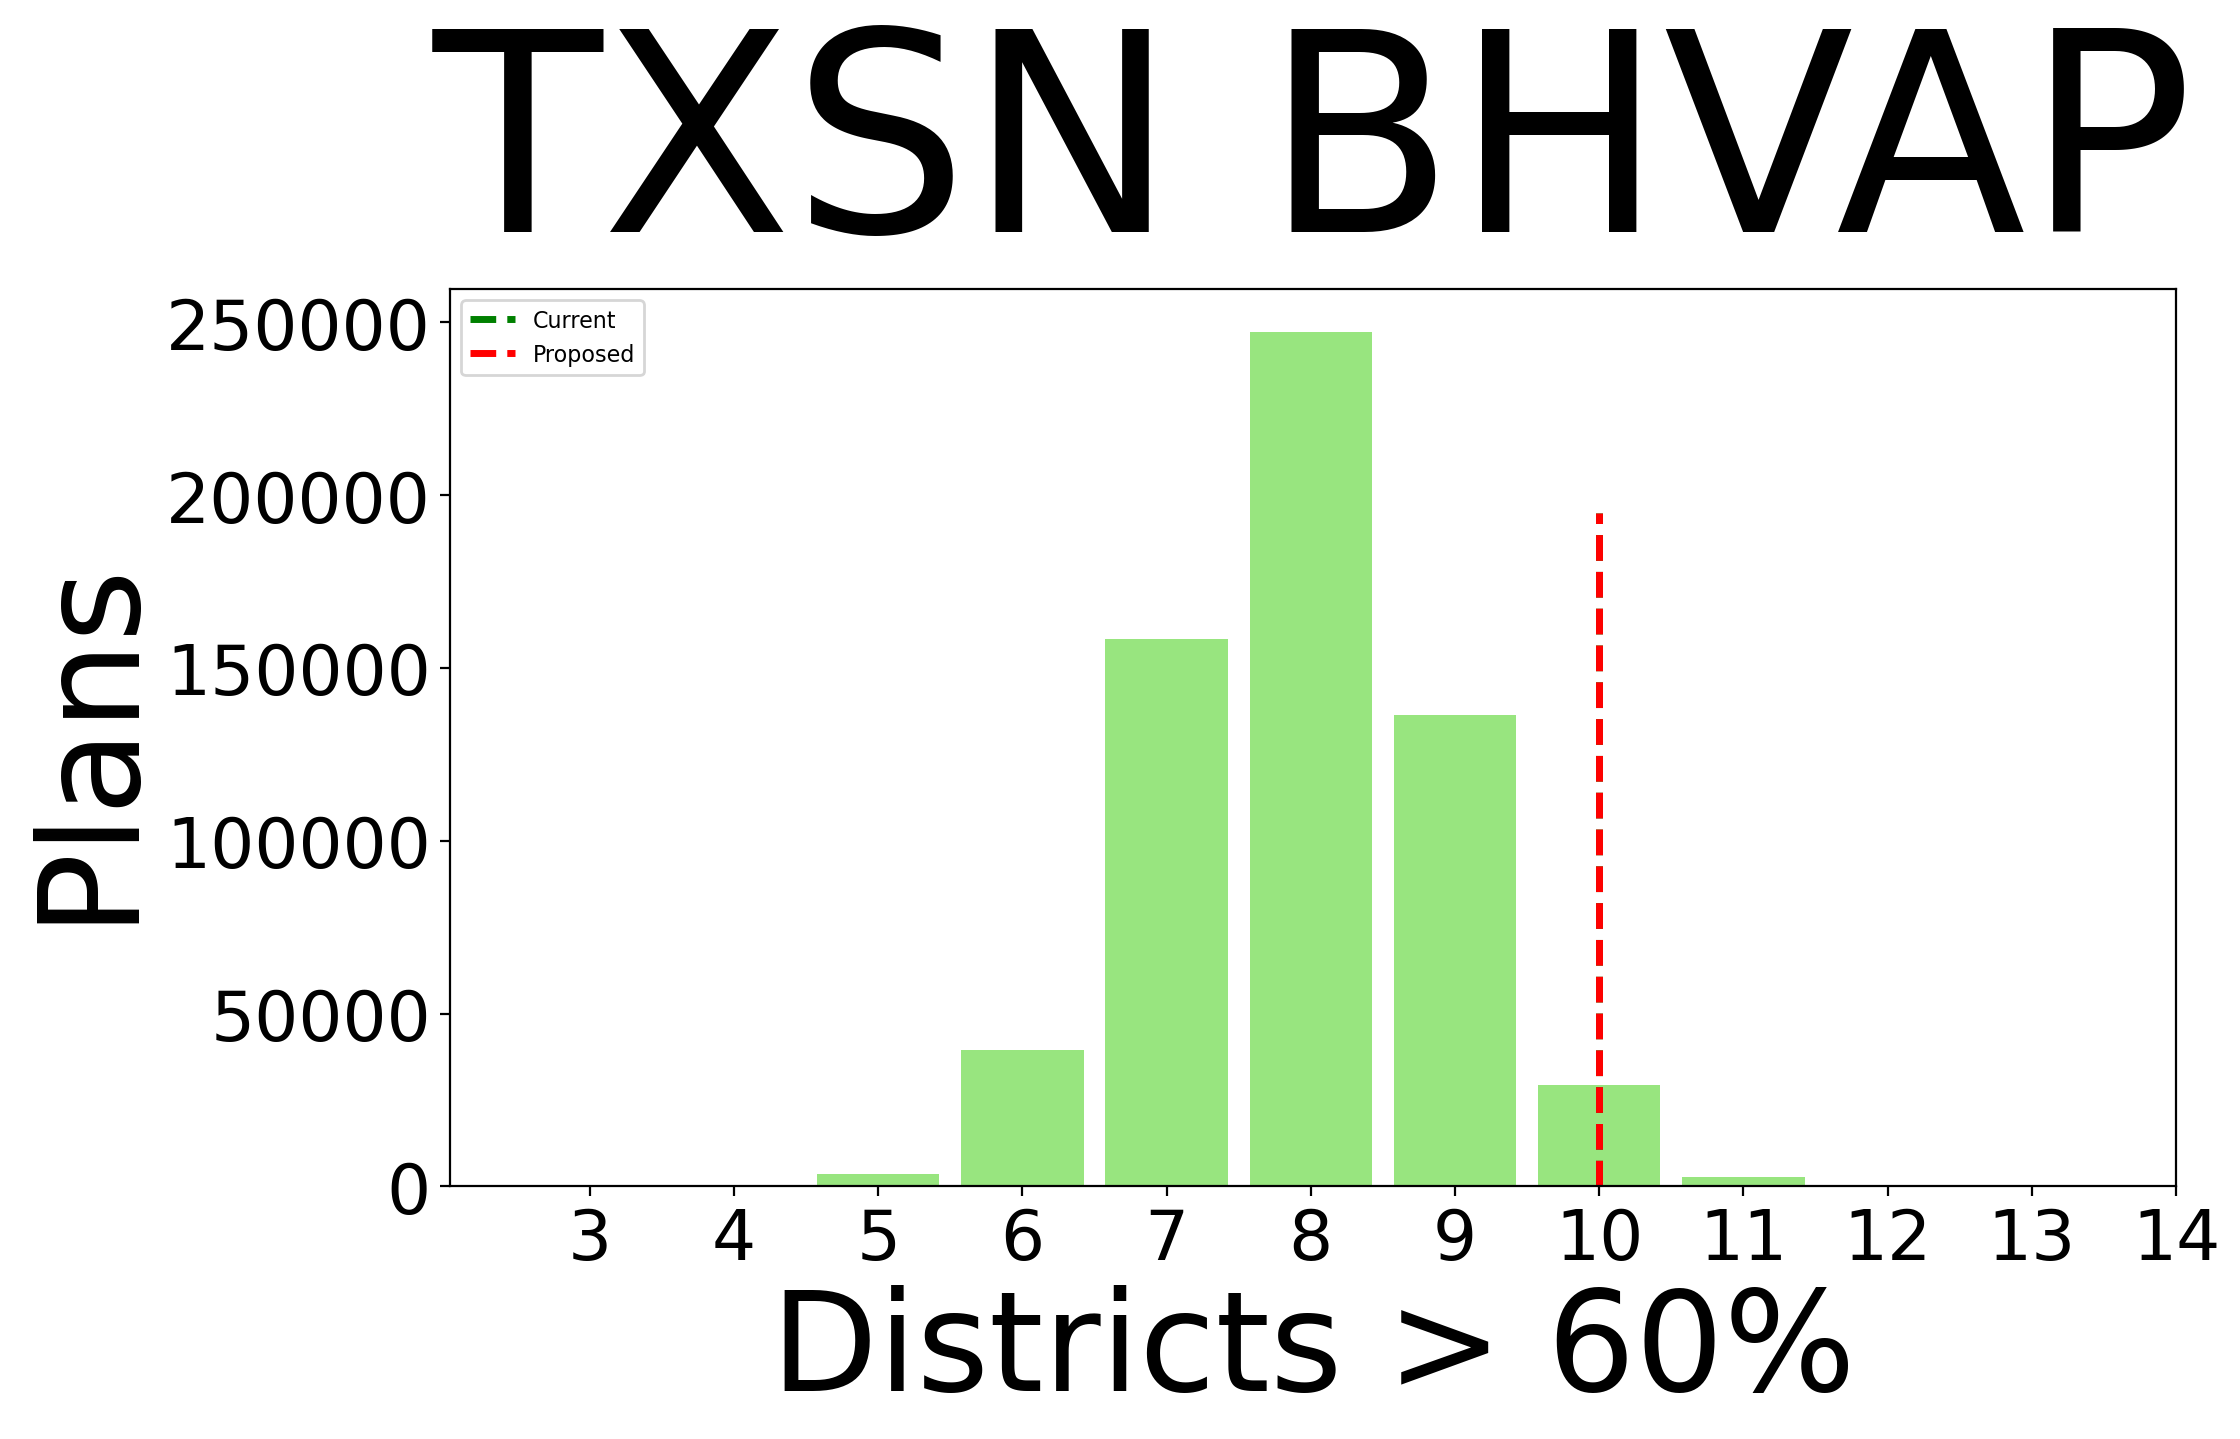

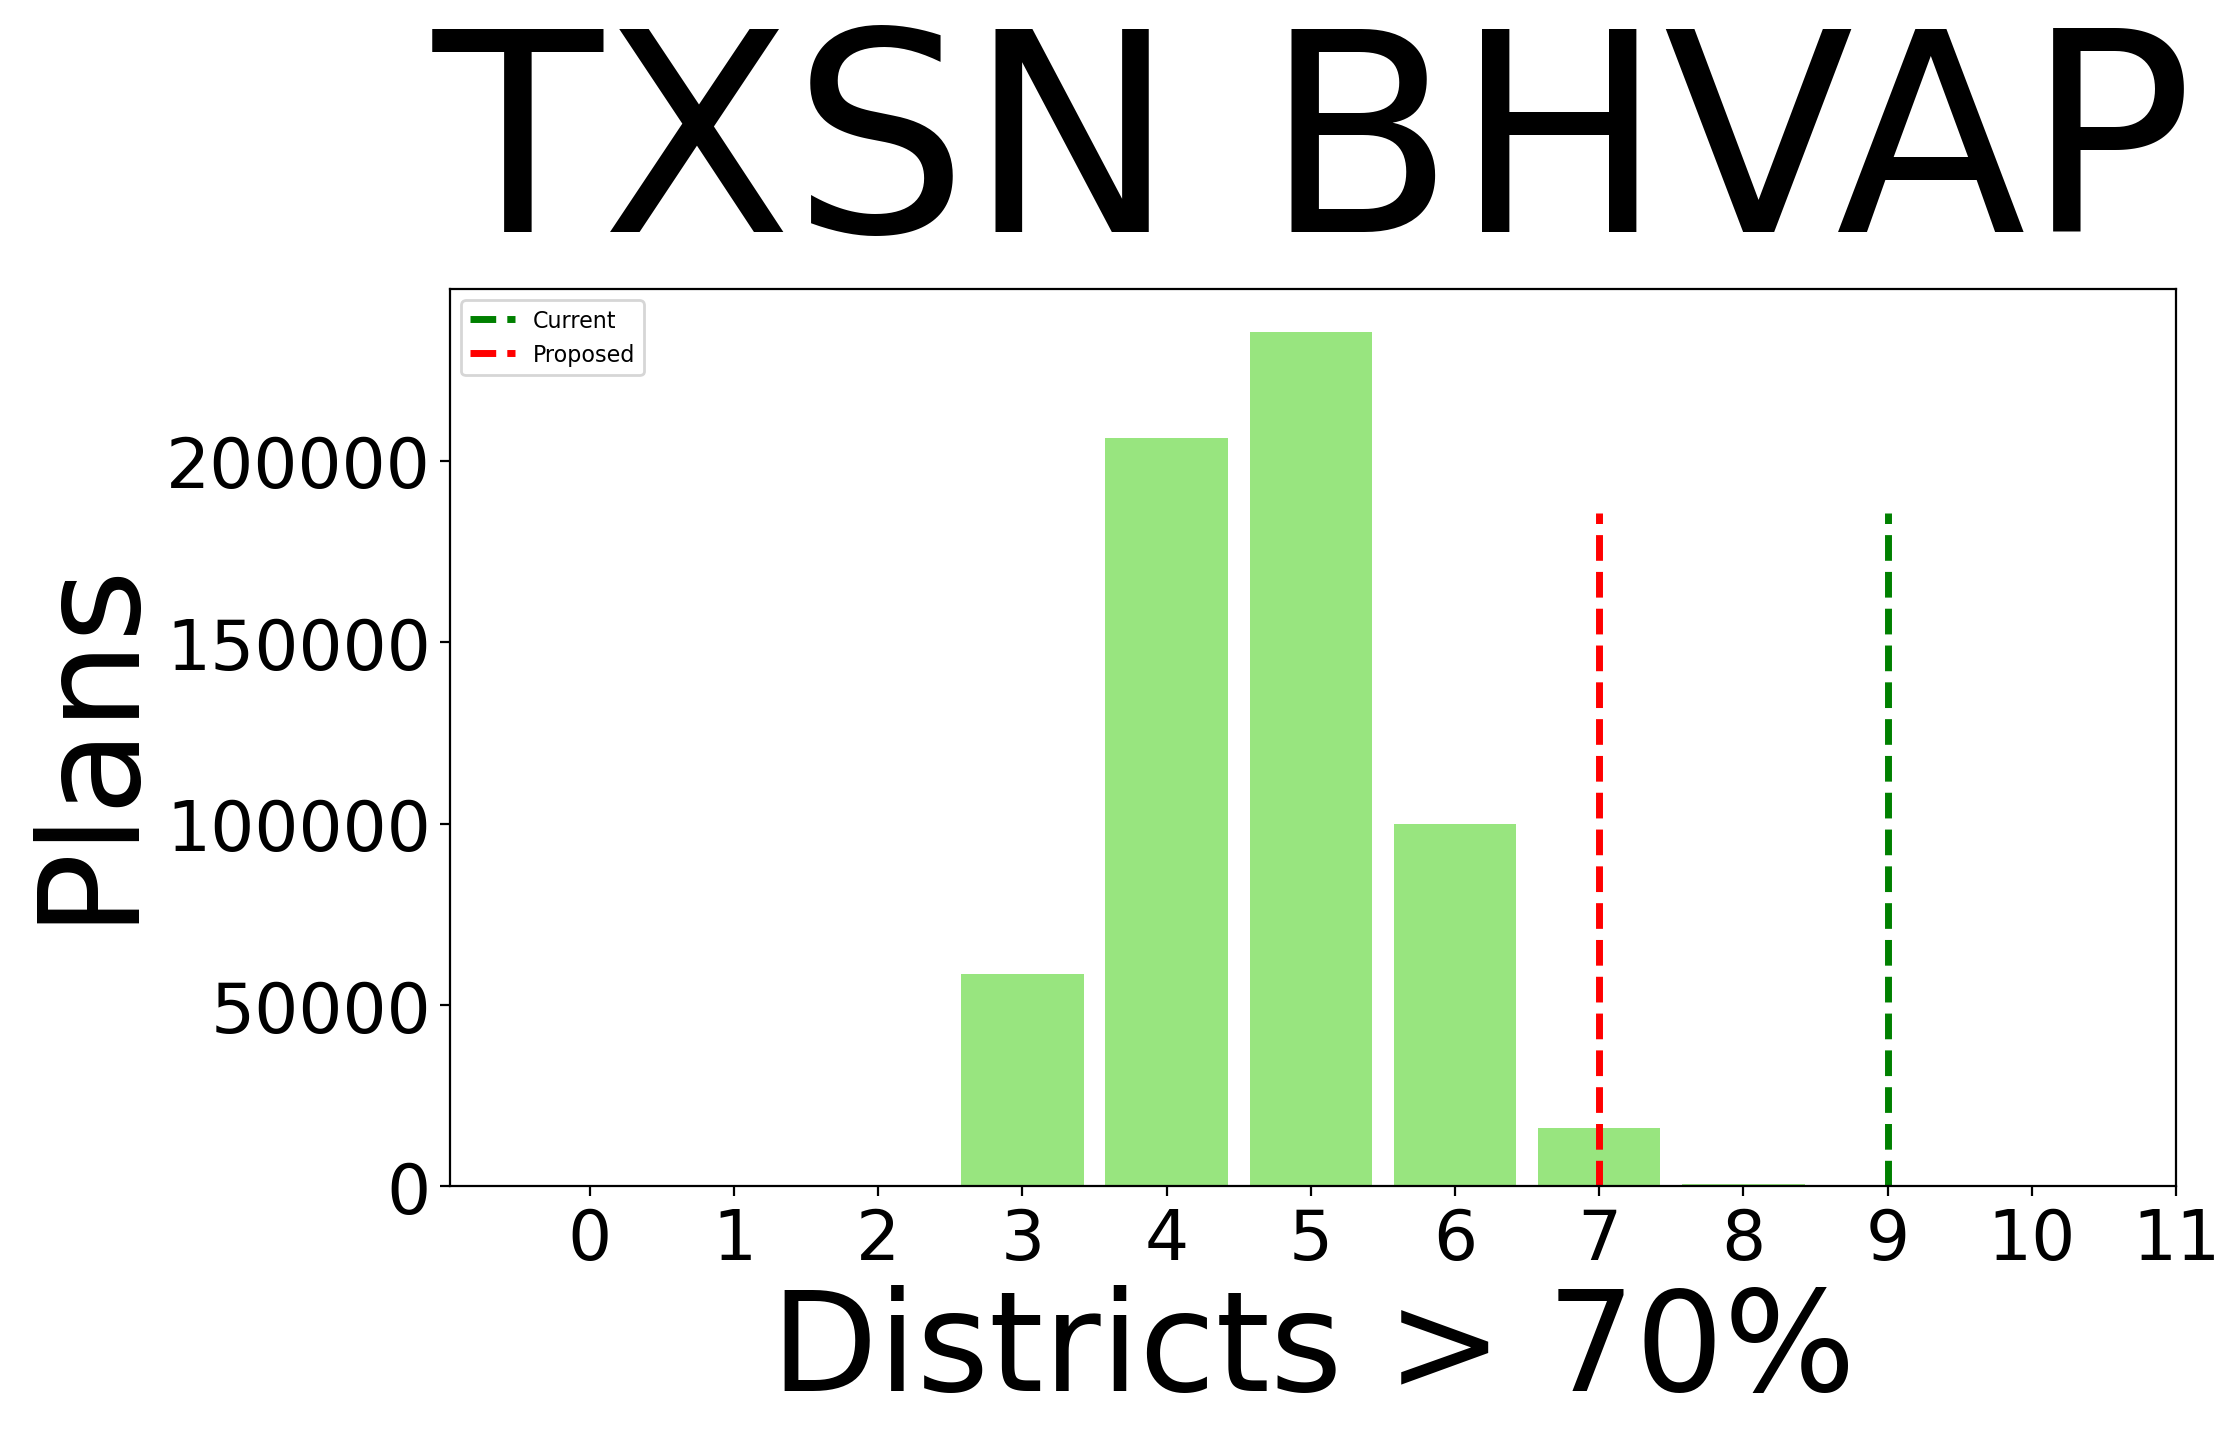

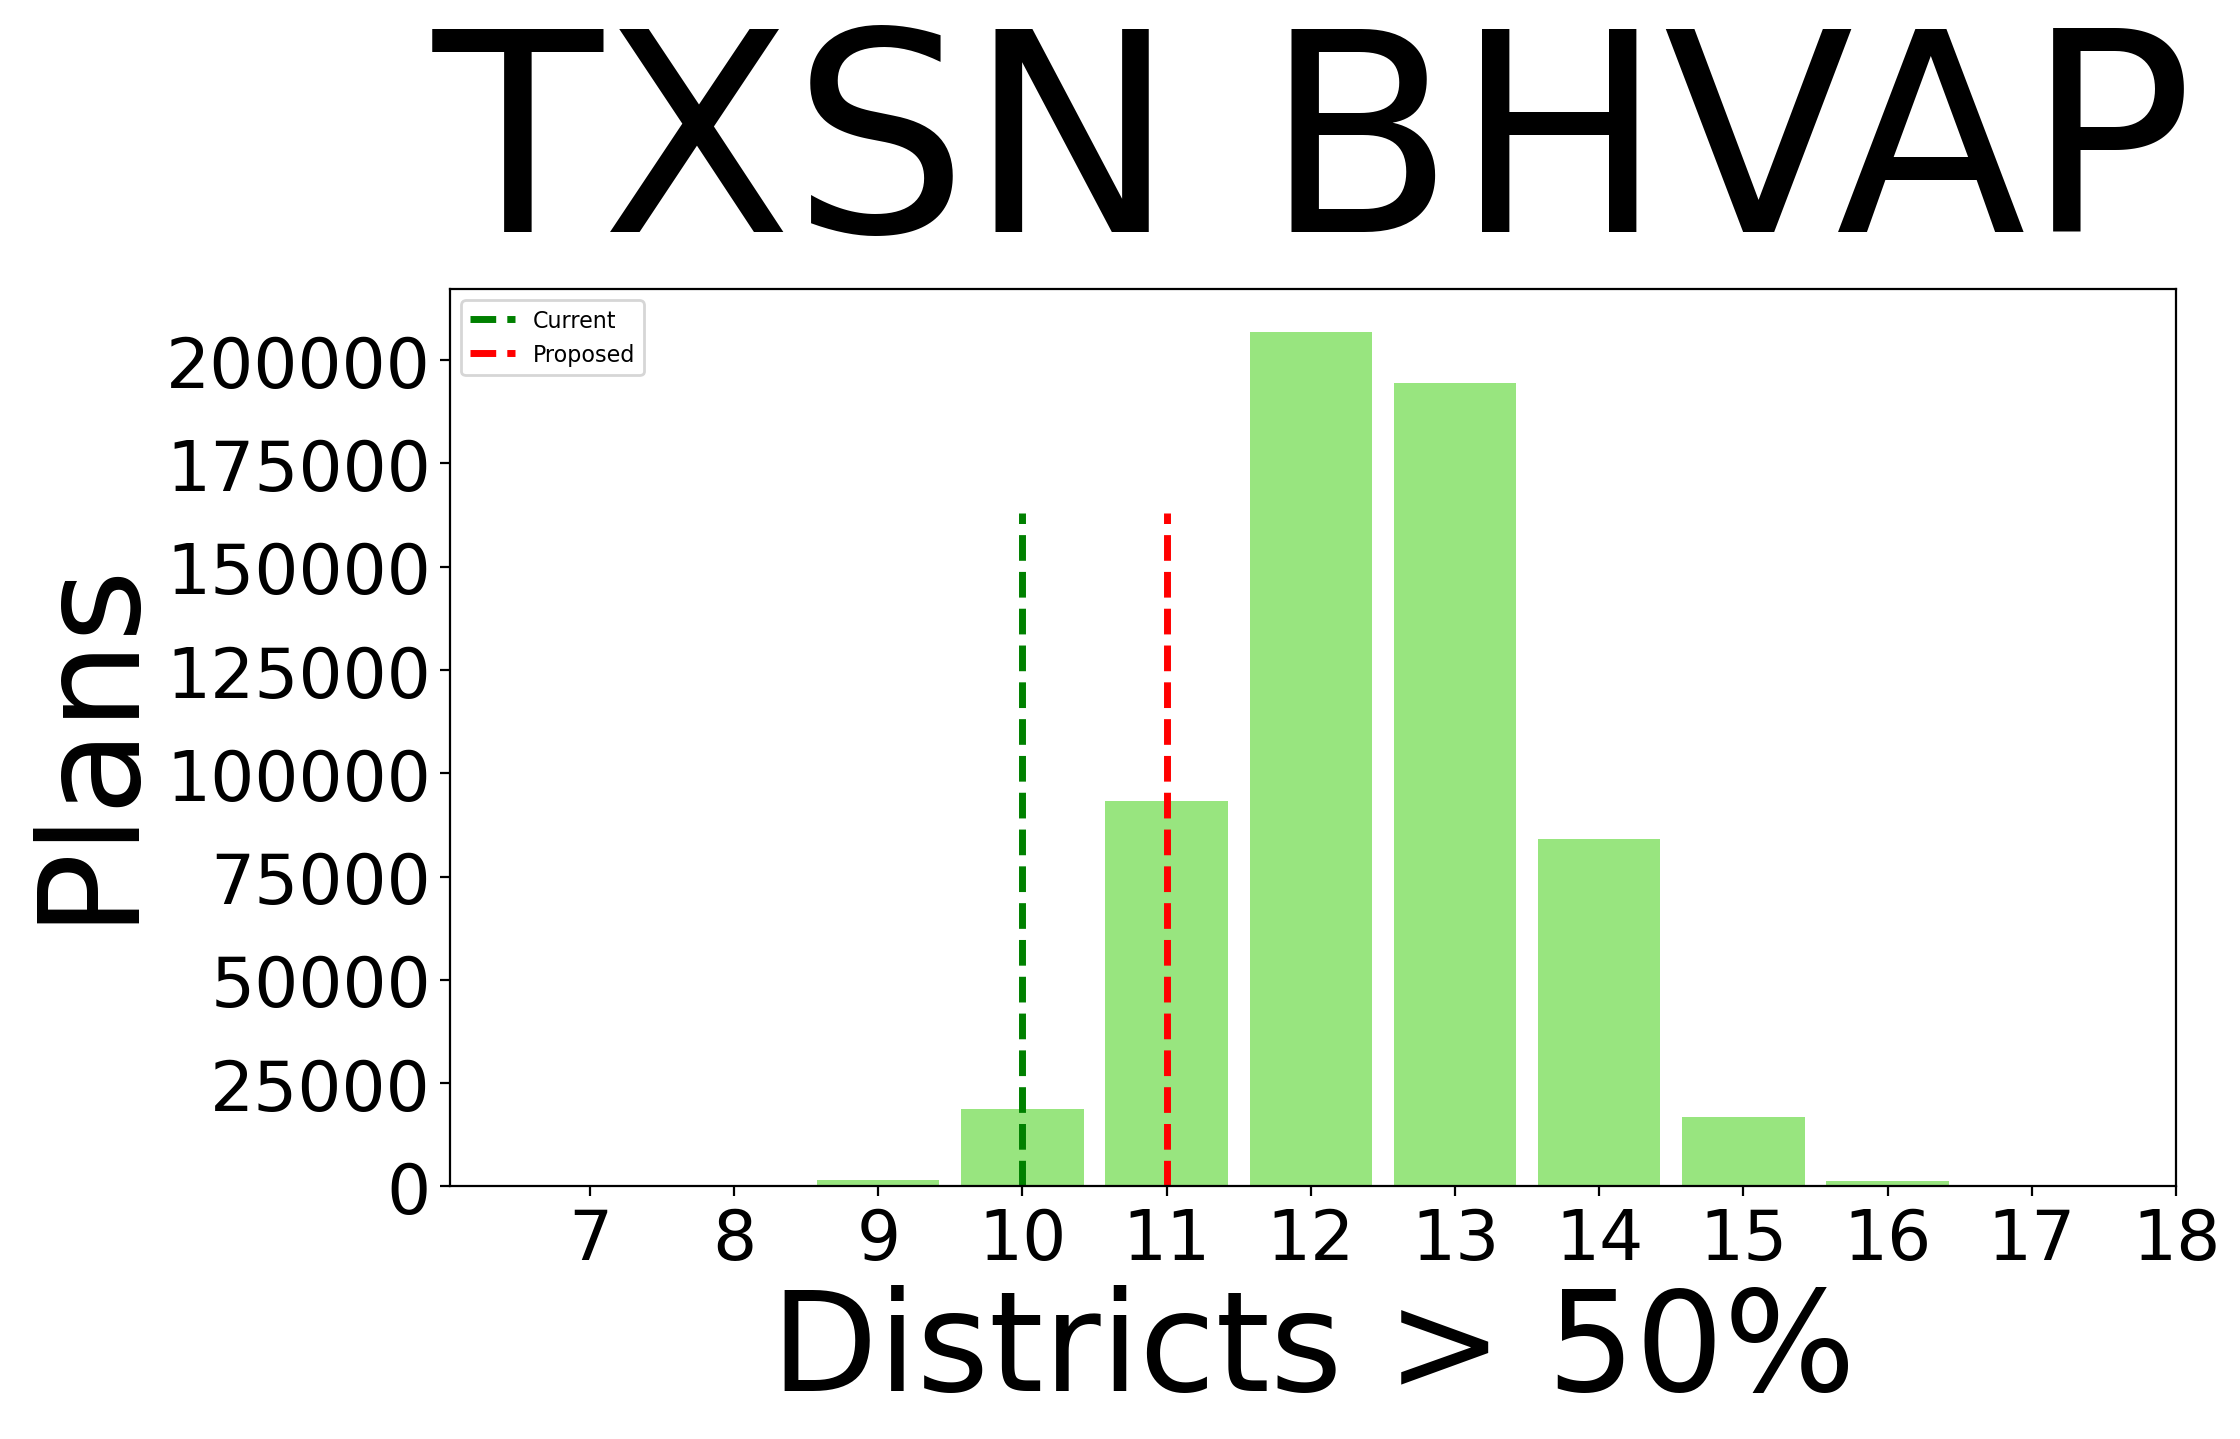

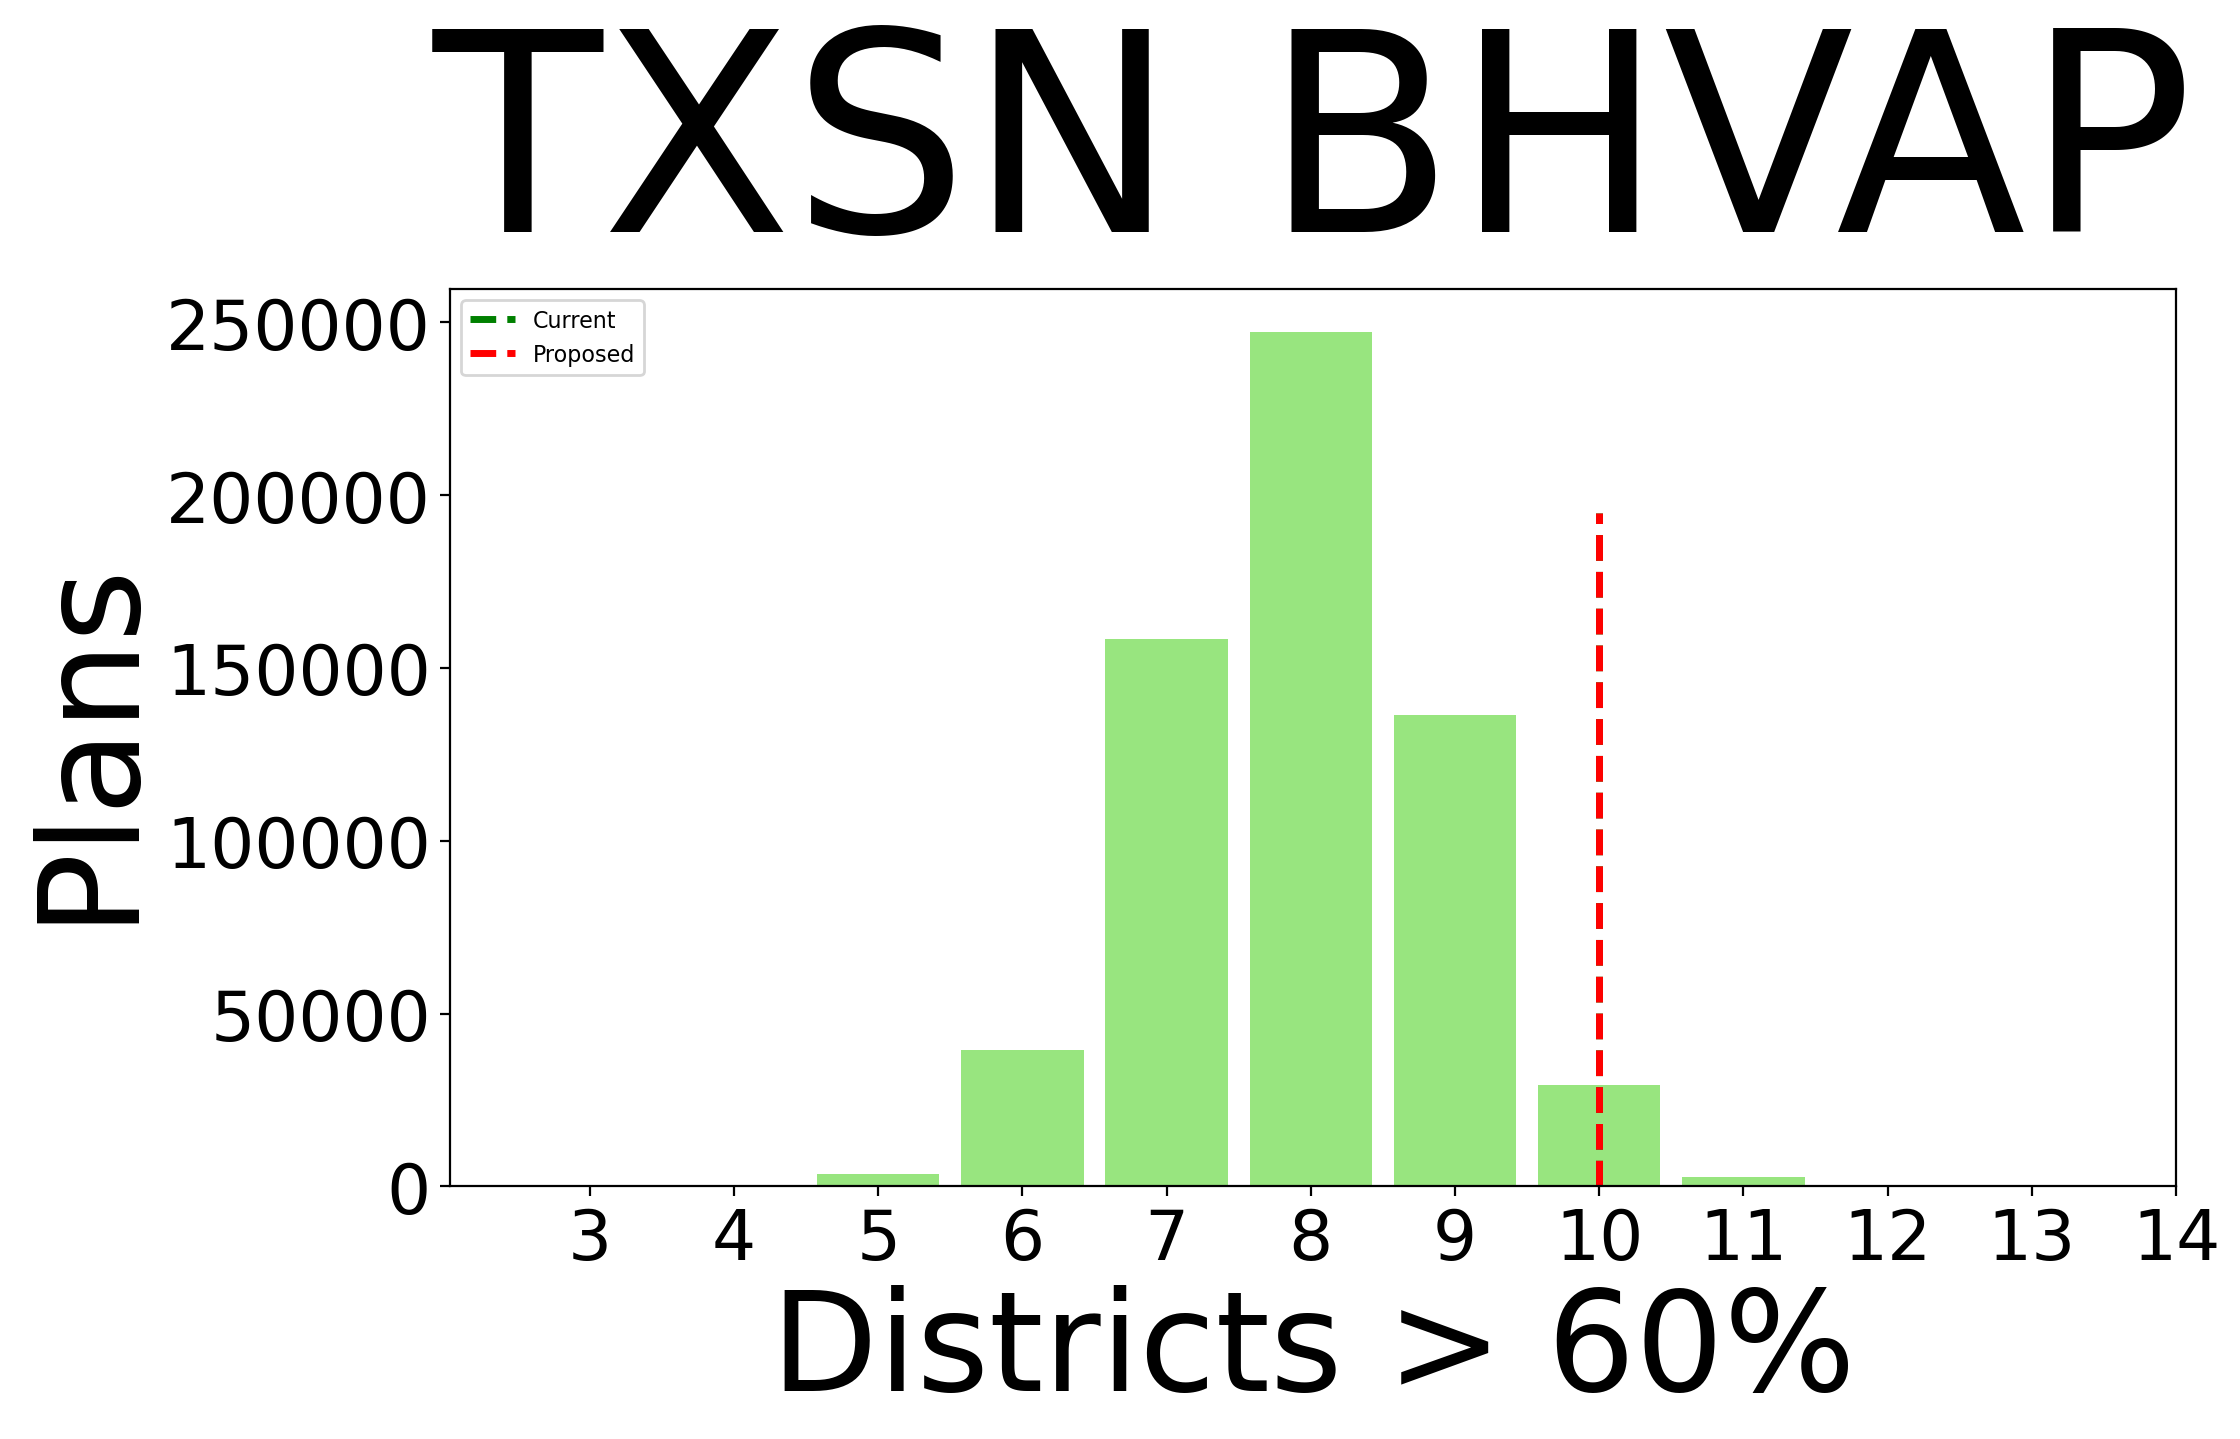

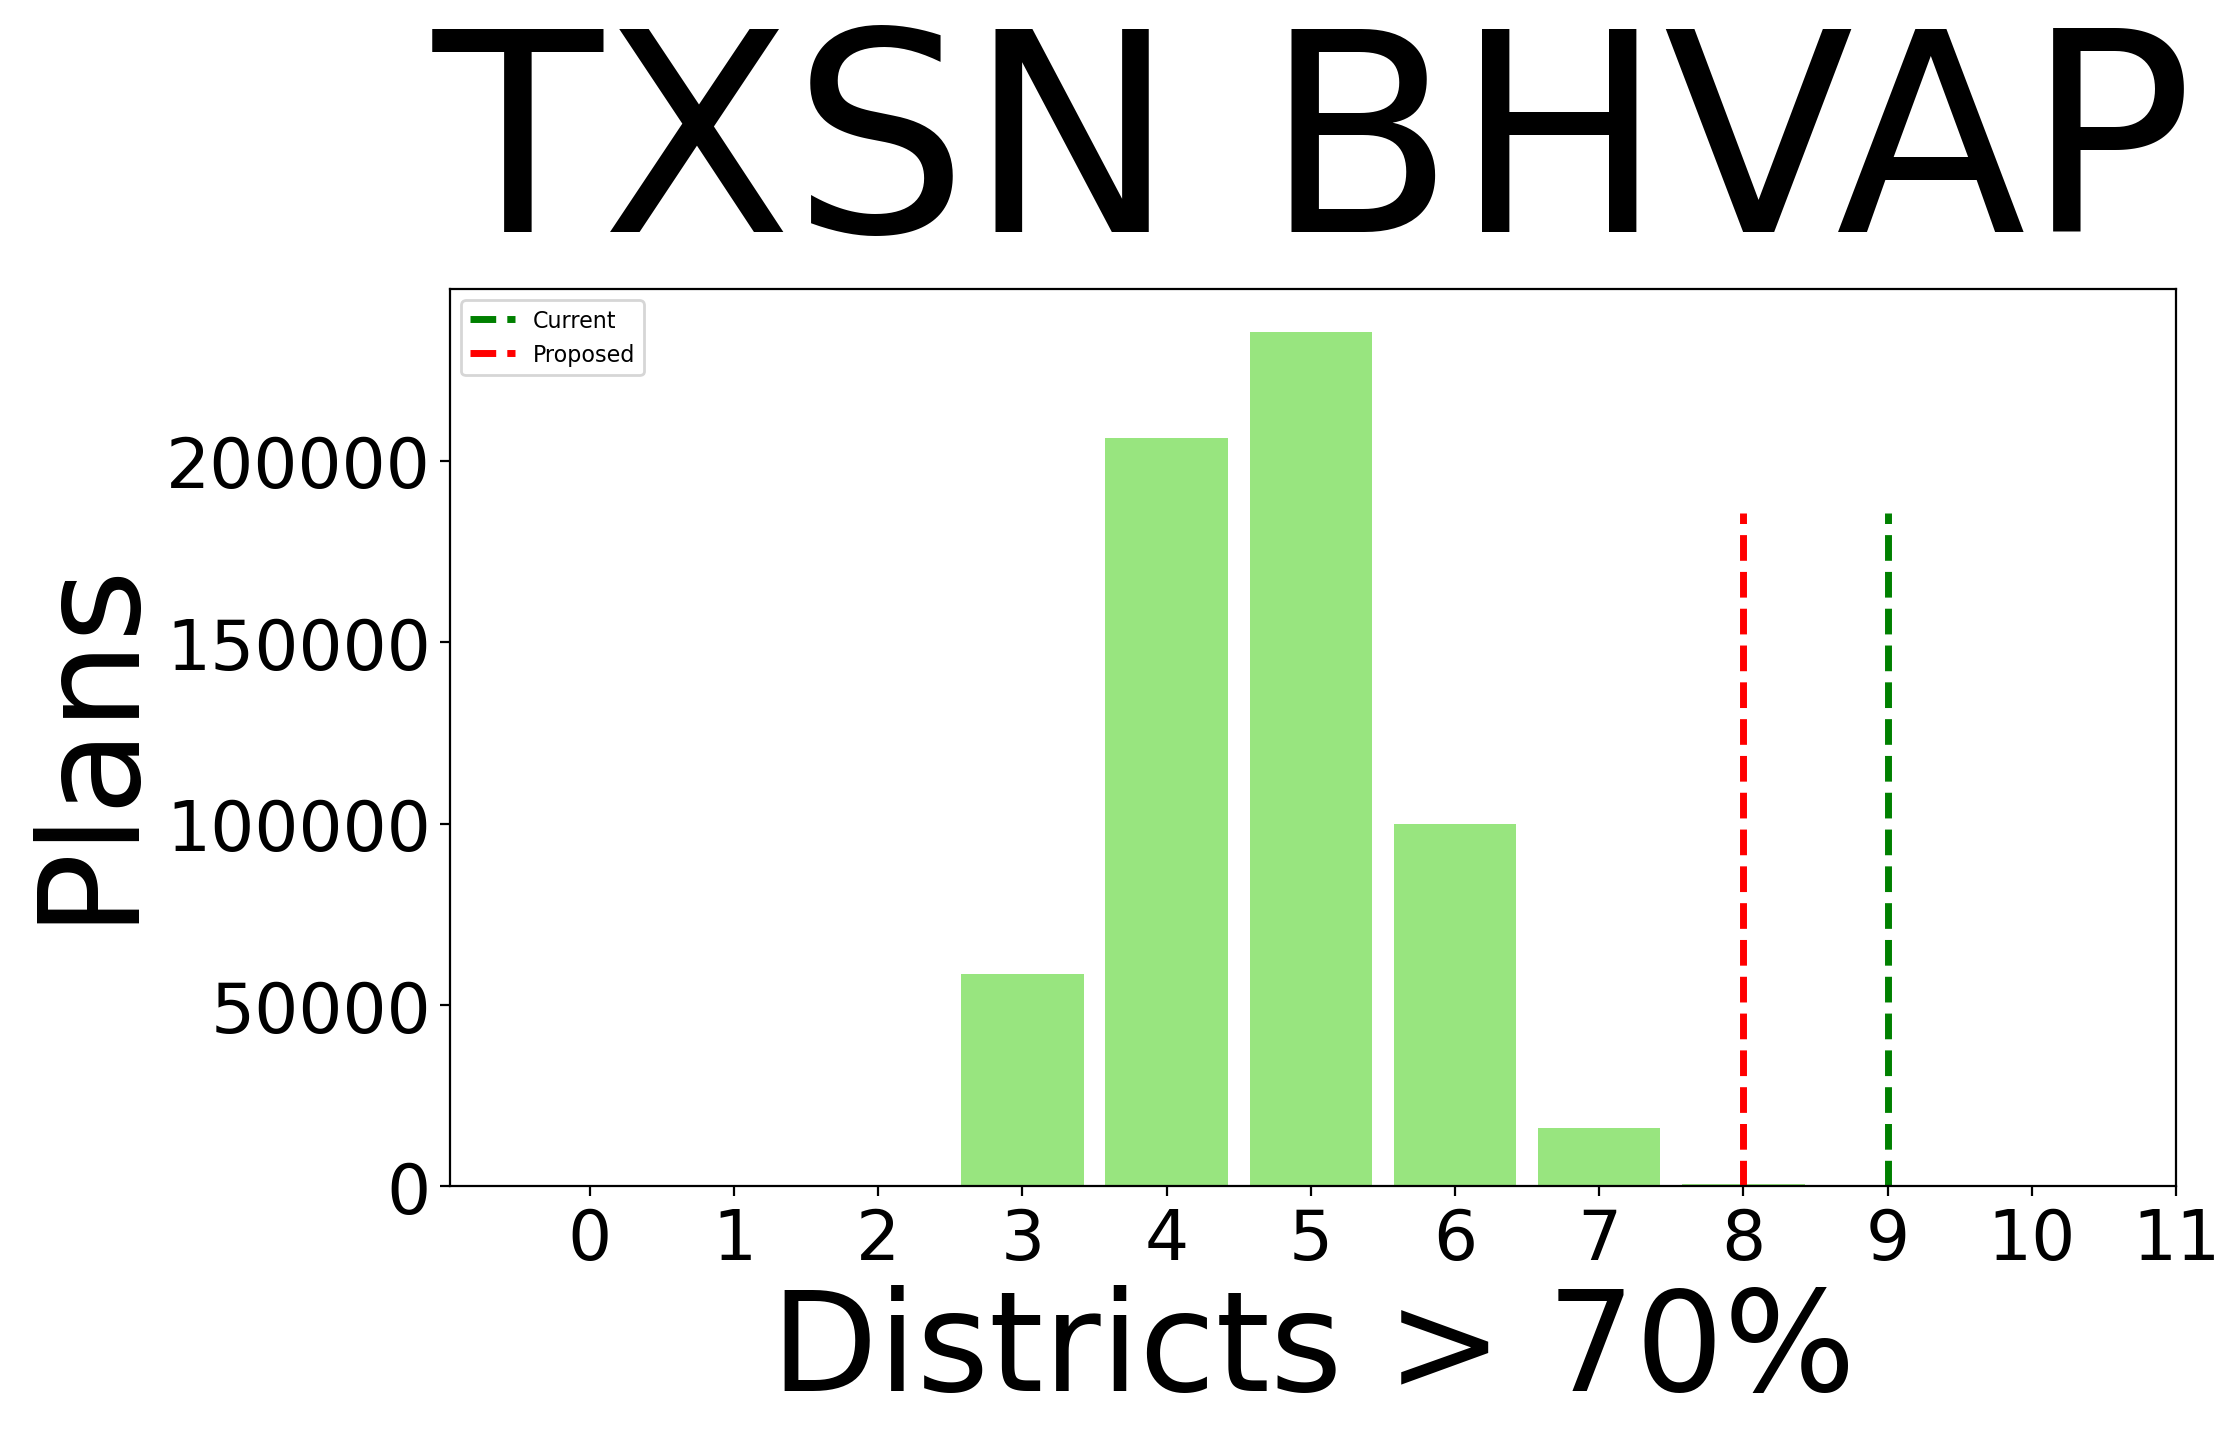

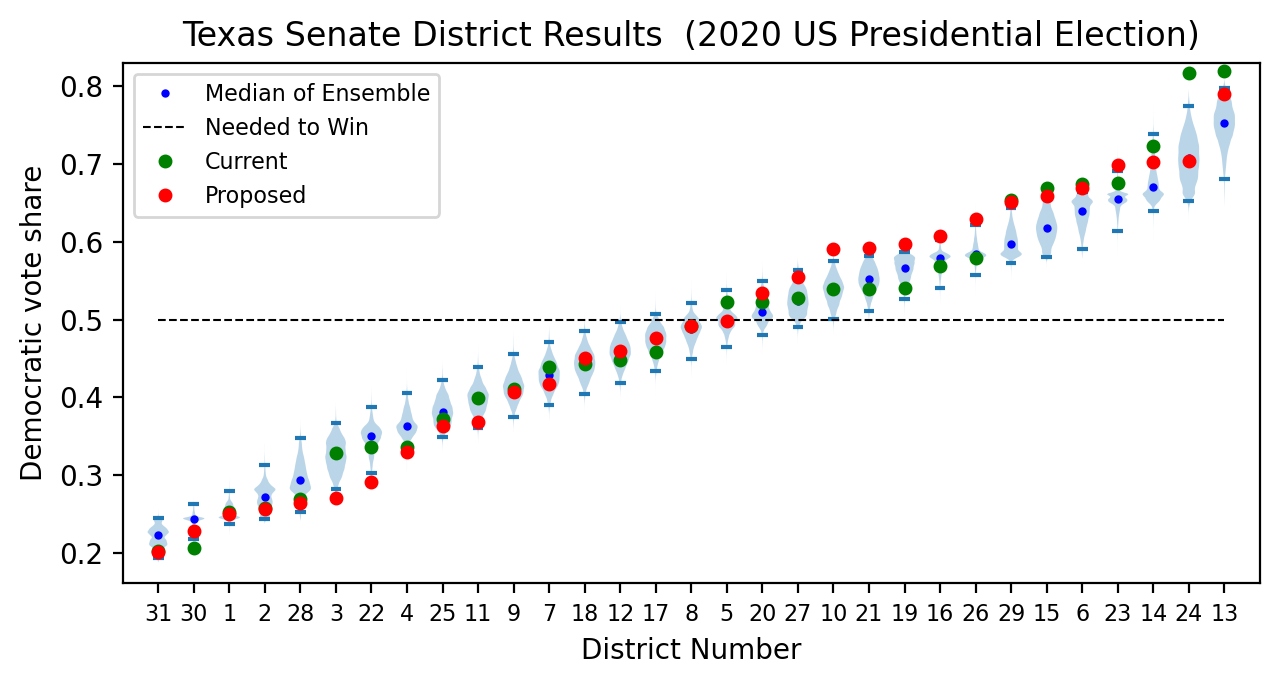

0.1985757095016341


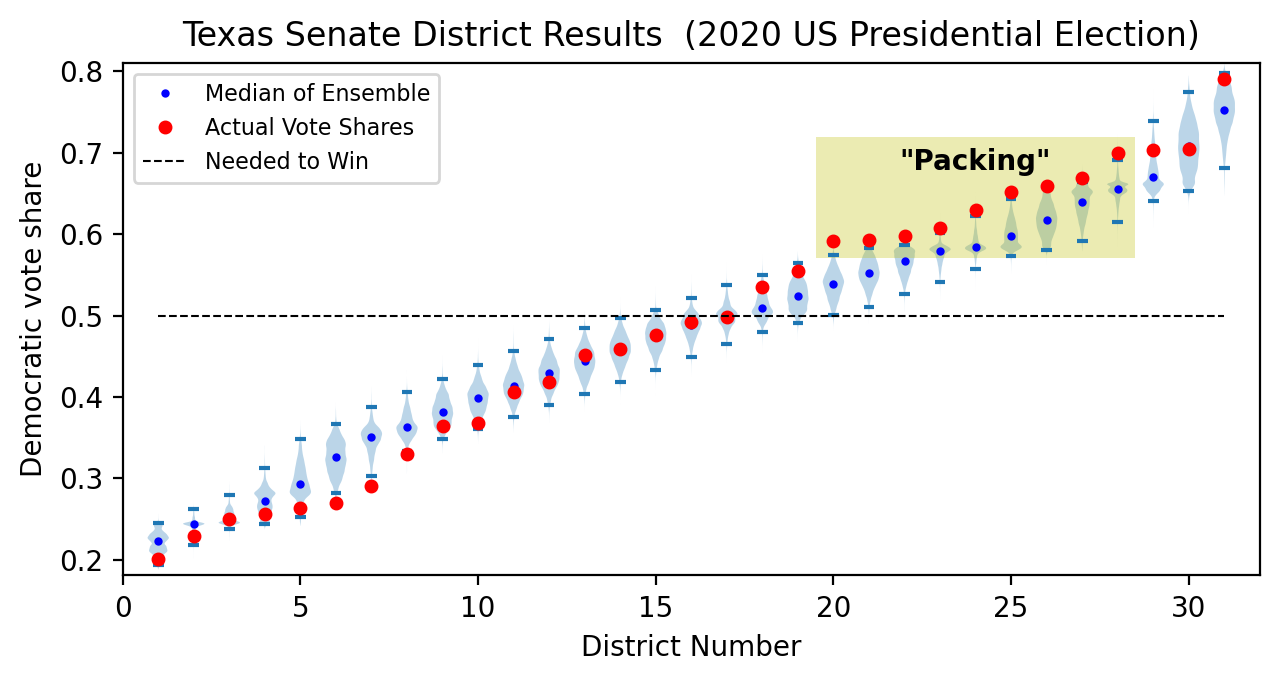

Vote Needed for Majority (D-R) -- Ensemble:   -0.0192
Seats at 50% Voteshare   (D-R) -- Ensemble:       -1
Vote Needed for Majority (D-R) -- Actual:     -0.0160
Seats at 50% Voteshare   (D-R) -- Actual:          0


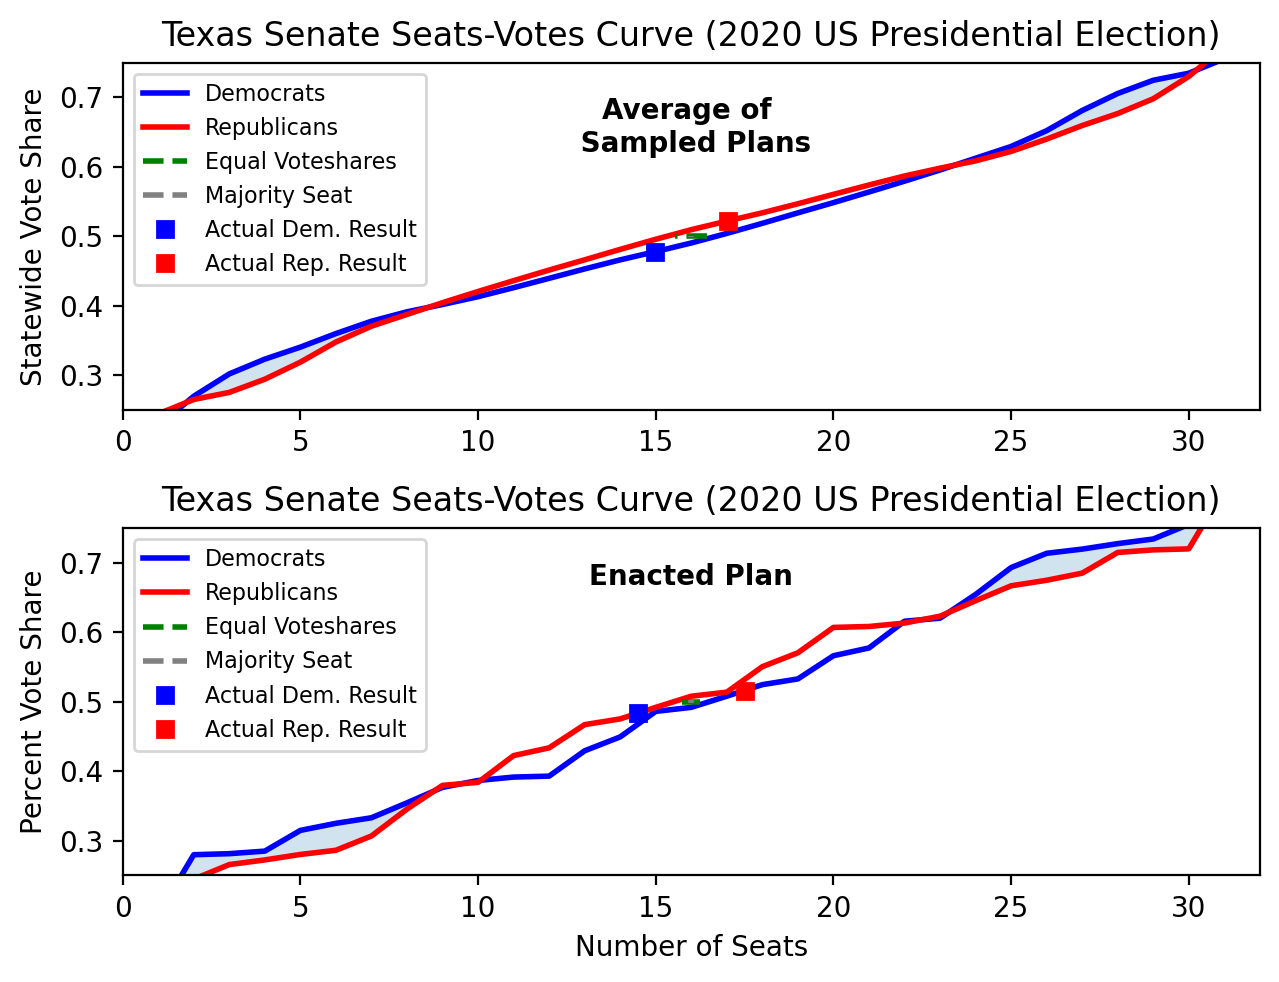

MM Enacted Plan Percentile =  57.26982152085551
[0.49198457 0.50801543]
-0.021444829040816737
PB Enacted Plan Percentile =  41.587487505487864
[16. 15.]
1.0
204728
154343
-9.0


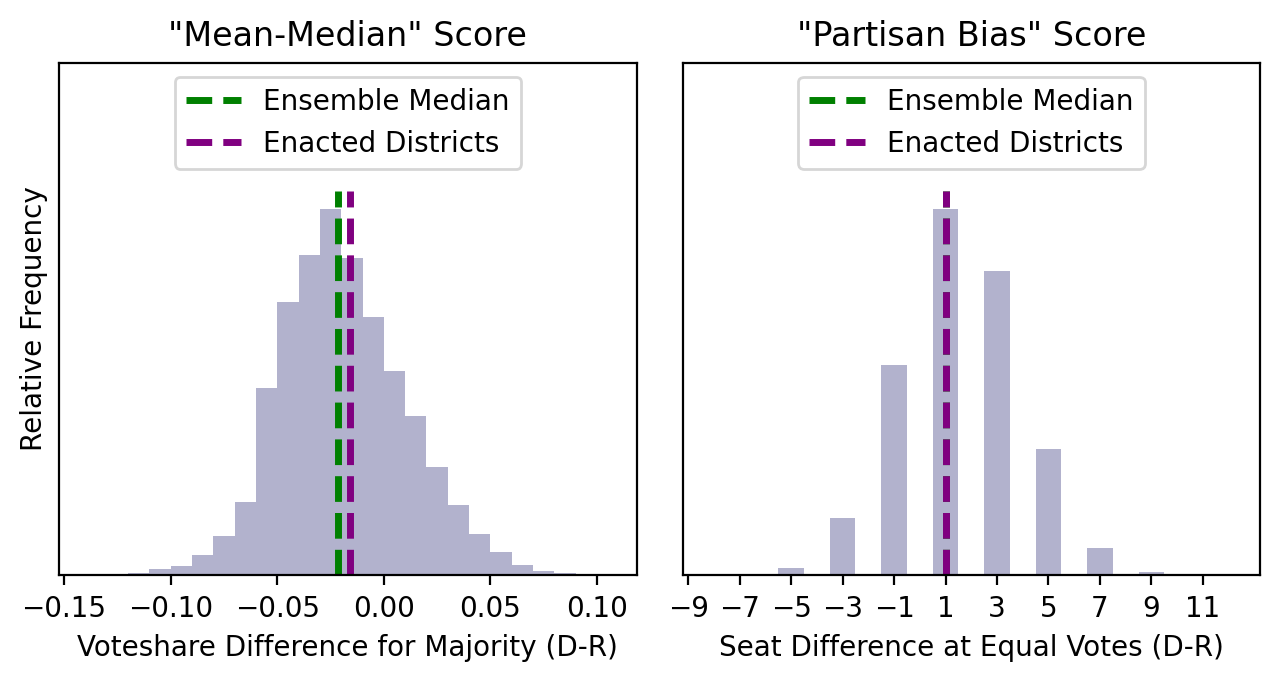

2130
[0.2035845159570924, 0.7903037484969416]
['31', '1', '28', '3', '4', '30', '22', '18', '24', '5', '25', '11', '17', '7', '10', '2', '9', '8', '12', '27', '20', '19', '21', '16', '15', '26', '29', '6', '14', '23', '13']


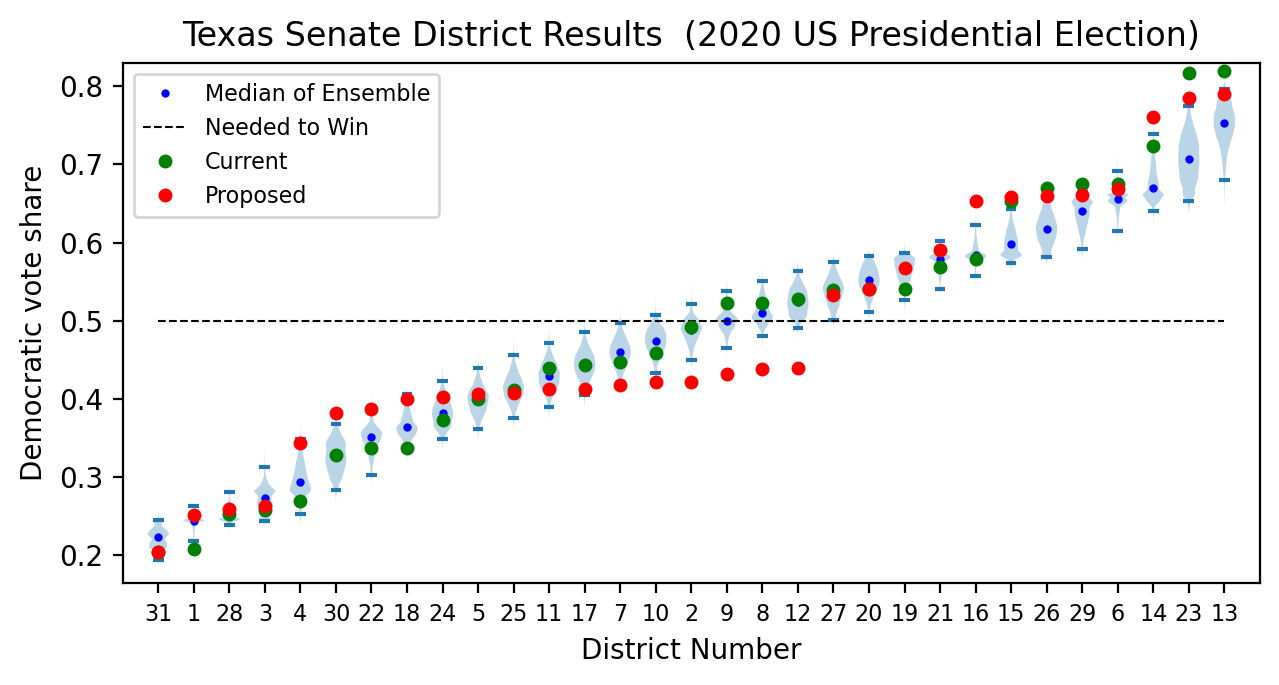

0.15896784134520808


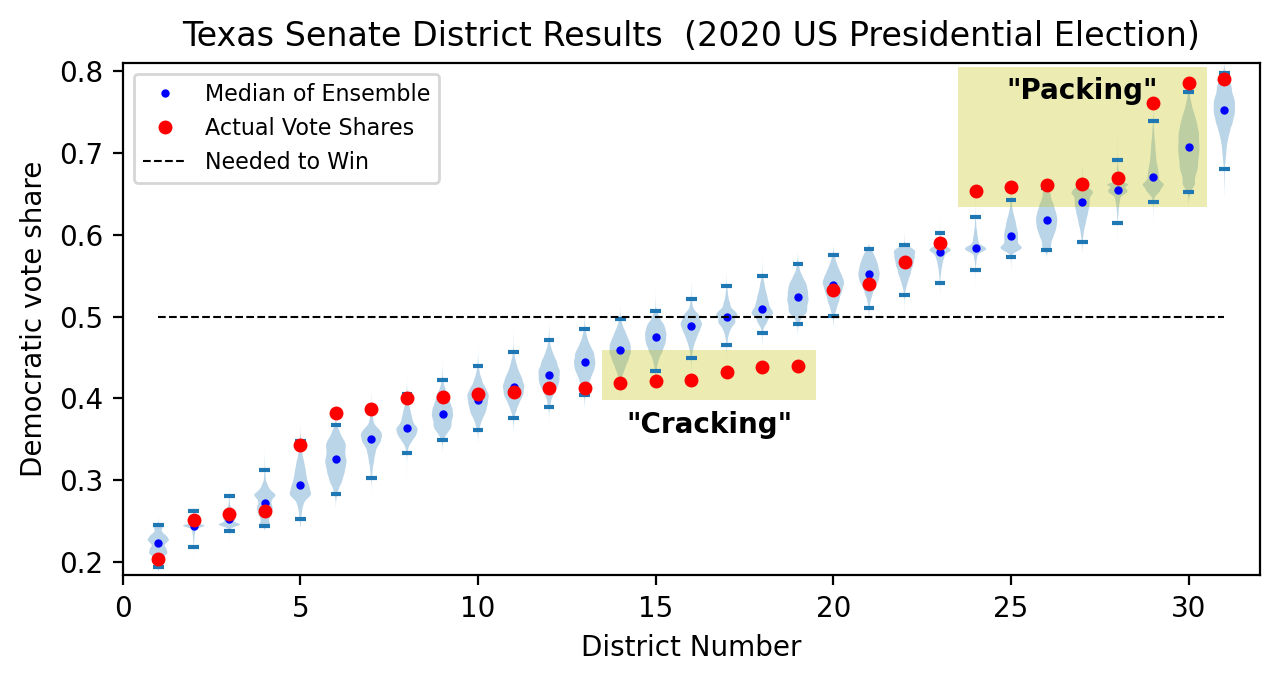

Vote Needed for Majority (D-R) -- Ensemble:   -0.0192
Seats at 50% Voteshare   (D-R) -- Ensemble:       -1
Vote Needed for Majority (D-R) -- Actual:     0.1219
Seats at 50% Voteshare   (D-R) -- Actual:          6


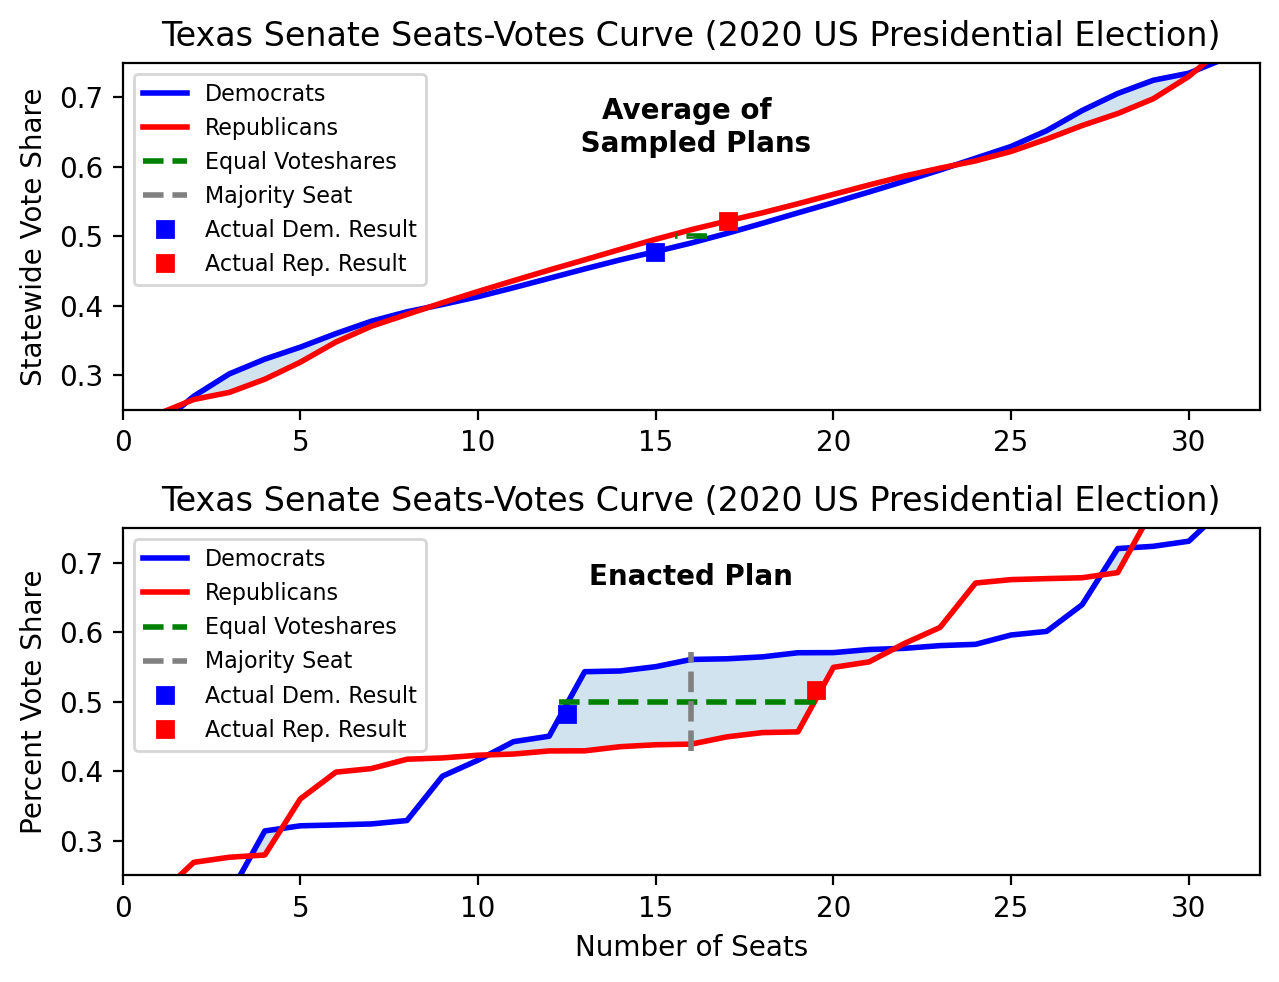

MM Enacted Plan Percentile =  100.0
[0.56095686 0.43904314]
-0.021444829040816737
PB Enacted Plan Percentile =  0.020655433350991705
[12. 19.]
1.0
218
18
-9.0


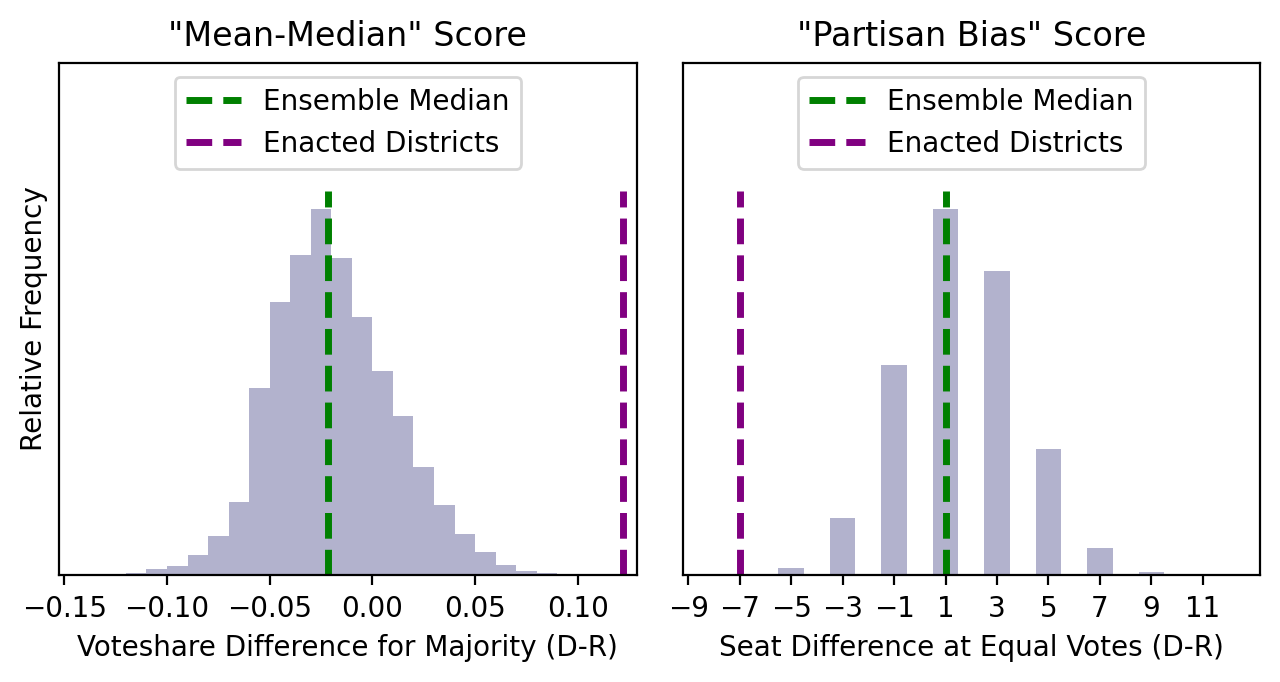

SEN20
31 districts
617270 plans
2129
[0.19064968796219472, 0.7763032658844043]
['31', '30', '1', '28', '2', '3', '22', '4', '25', '11', '9', '7', '18', '12', '17', '8', '5', '20', '27', '16', '10', '19', '21', '26', '15', '29', '6', '14', '23', '24', '13']


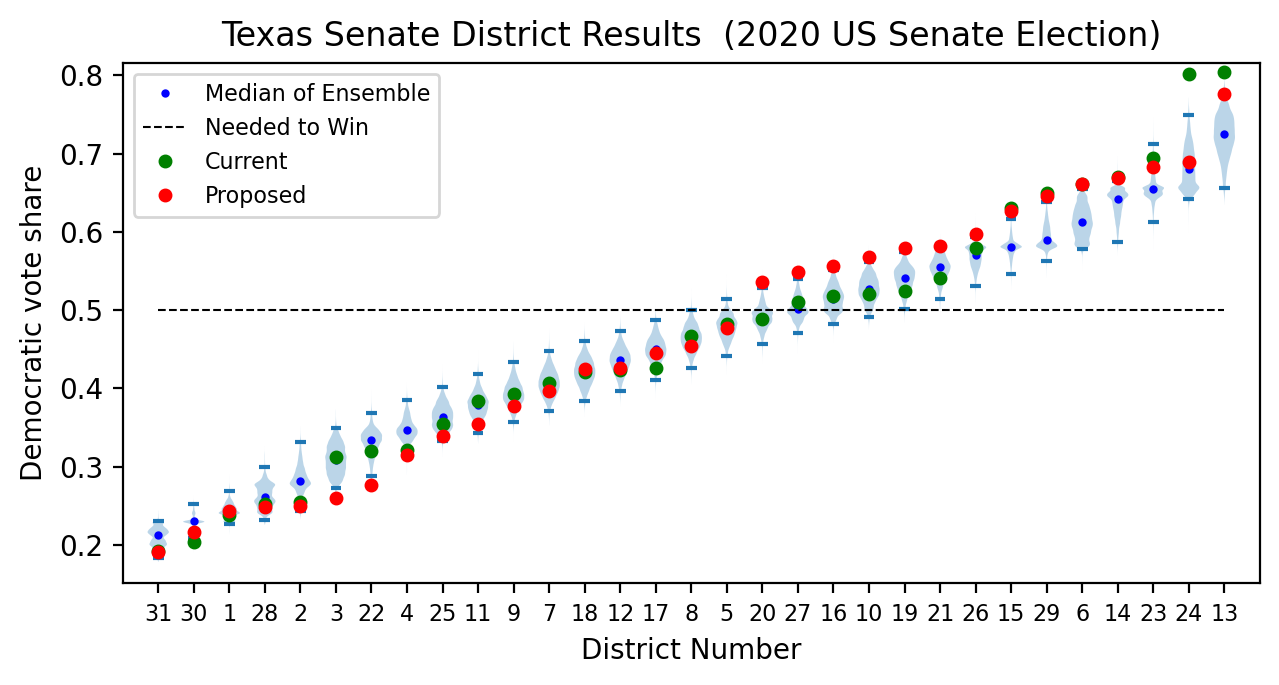

0.22087474007833896


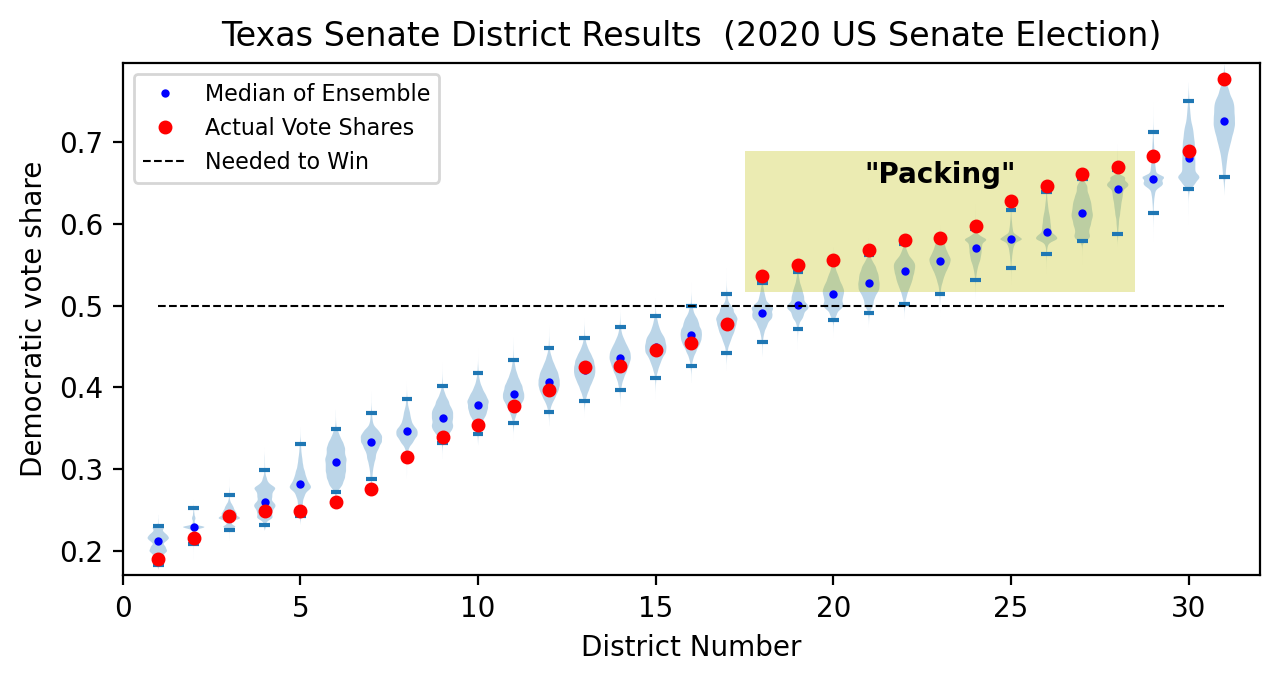

Vote Needed for Majority (D-R) -- Ensemble:   -0.0128
Seats at 50% Voteshare   (D-R) -- Ensemble:        0
Vote Needed for Majority (D-R) -- Actual:     0.0225
Seats at 50% Voteshare   (D-R) -- Actual:          0


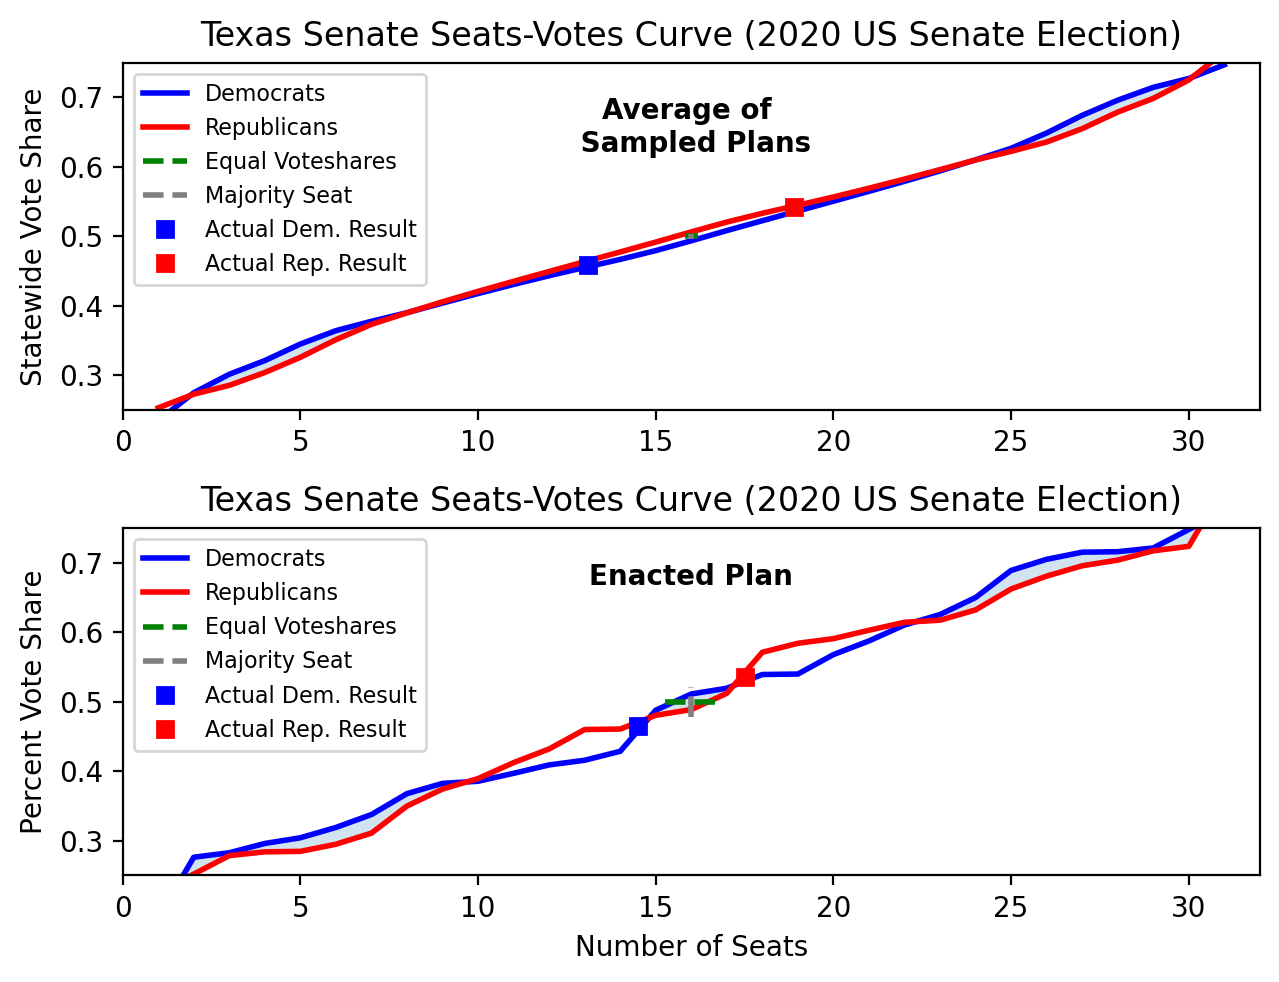

MM Enacted Plan Percentile =  85.53423050815606
[0.5112292 0.4887708]
-0.012478520652433822
PB Enacted Plan Percentile =  22.756212425336685
[15. 16.]
1.0
155006
62964
-9.0


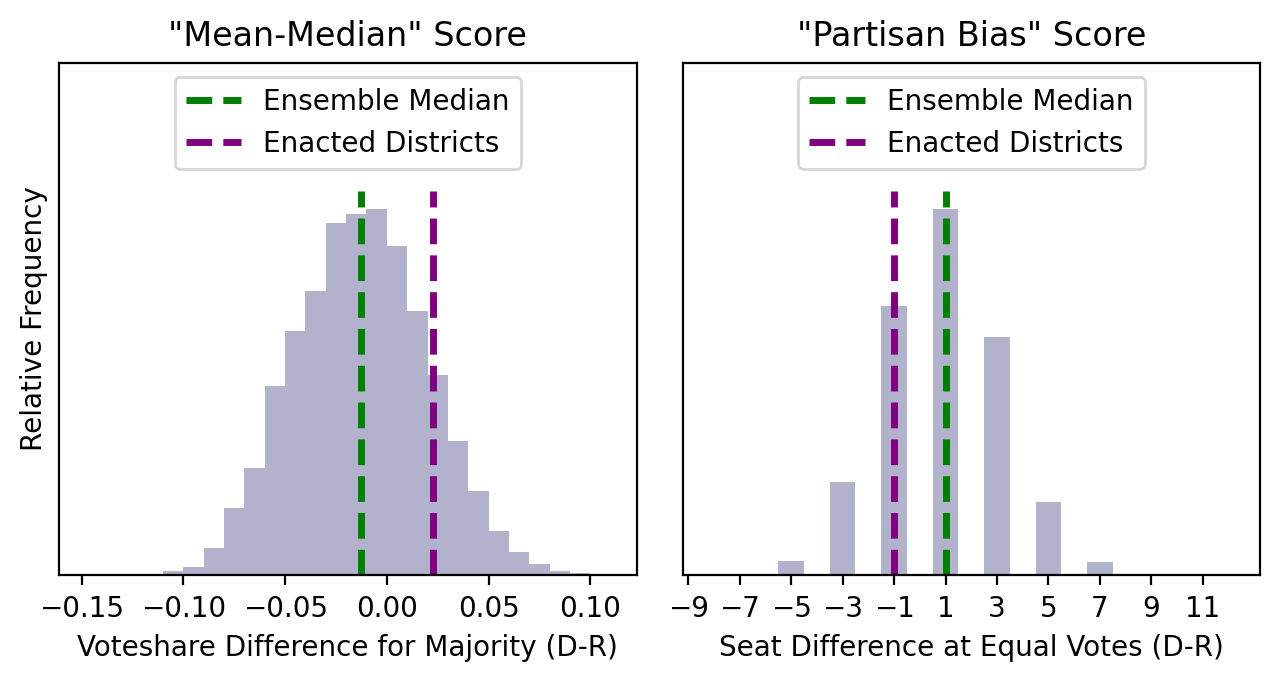

2130
[0.19309211871685458, 0.7763032658844043]
['31', '28', '1', '3', '4', '30', '22', '25', '18', '17', '24', '5', '7', '11', '12', '2', '10', '8', '9', '27', '20', '19', '21', '16', '15', '26', '29', '6', '14', '23', '13']


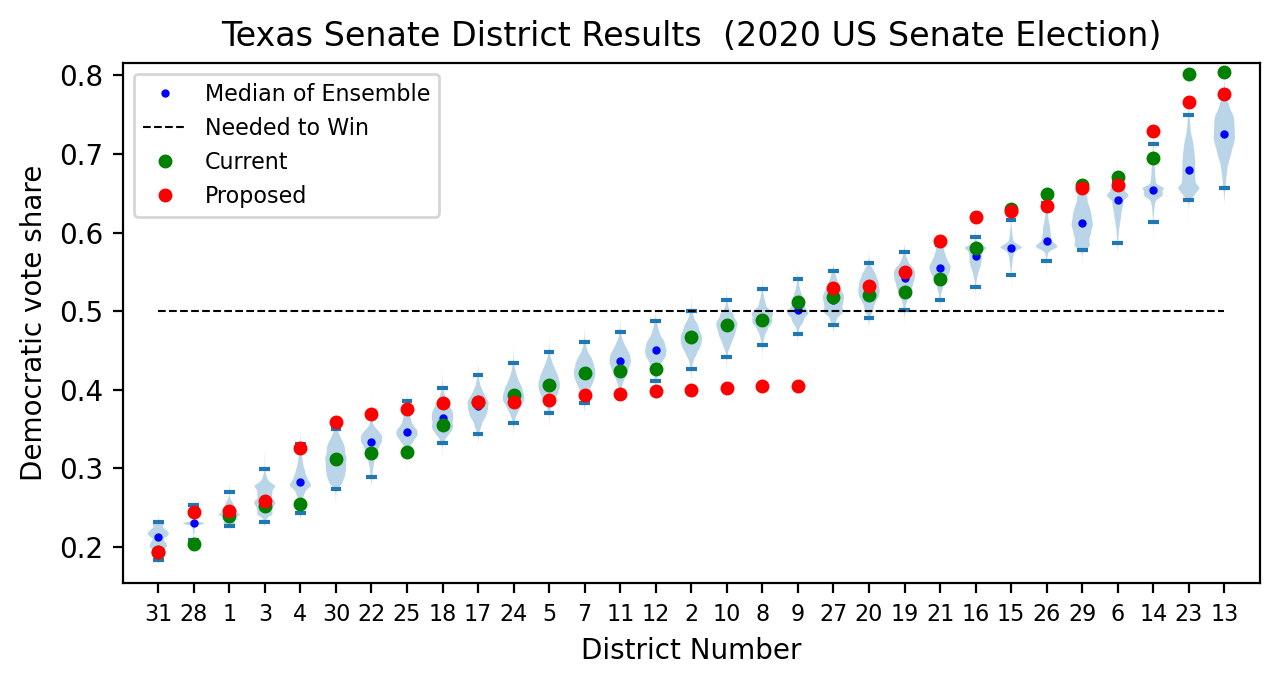

0.17802250302278533


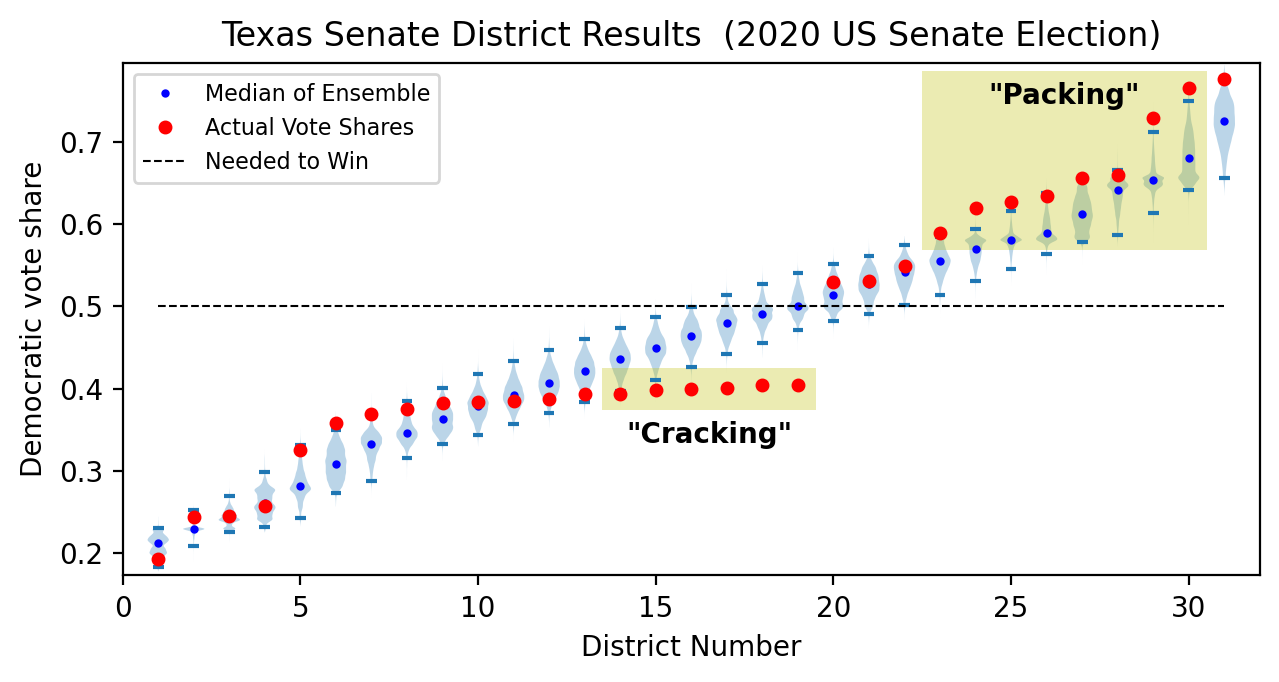

Vote Needed for Majority (D-R) -- Ensemble:   -0.0128
Seats at 50% Voteshare   (D-R) -- Ensemble:        0
Vote Needed for Majority (D-R) -- Actual:     0.1279
Seats at 50% Voteshare   (D-R) -- Actual:          6


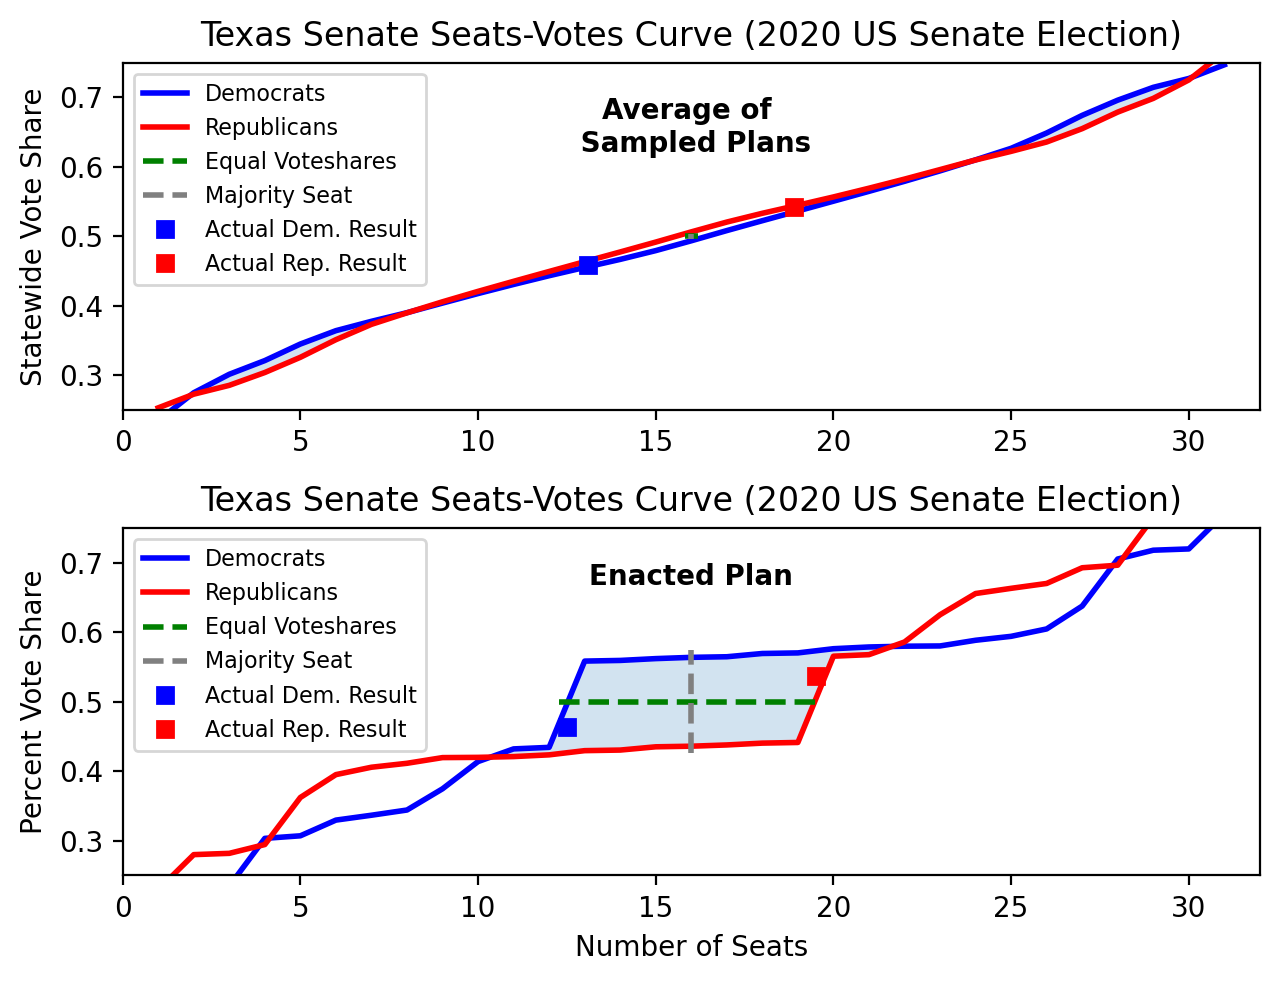

MM Enacted Plan Percentile =  100.0
[0.56395687 0.43604313]
-0.012478520652433822
PB Enacted Plan Percentile =  0.05216509442368101
[12. 19.]
1.0
611
16
-9.0


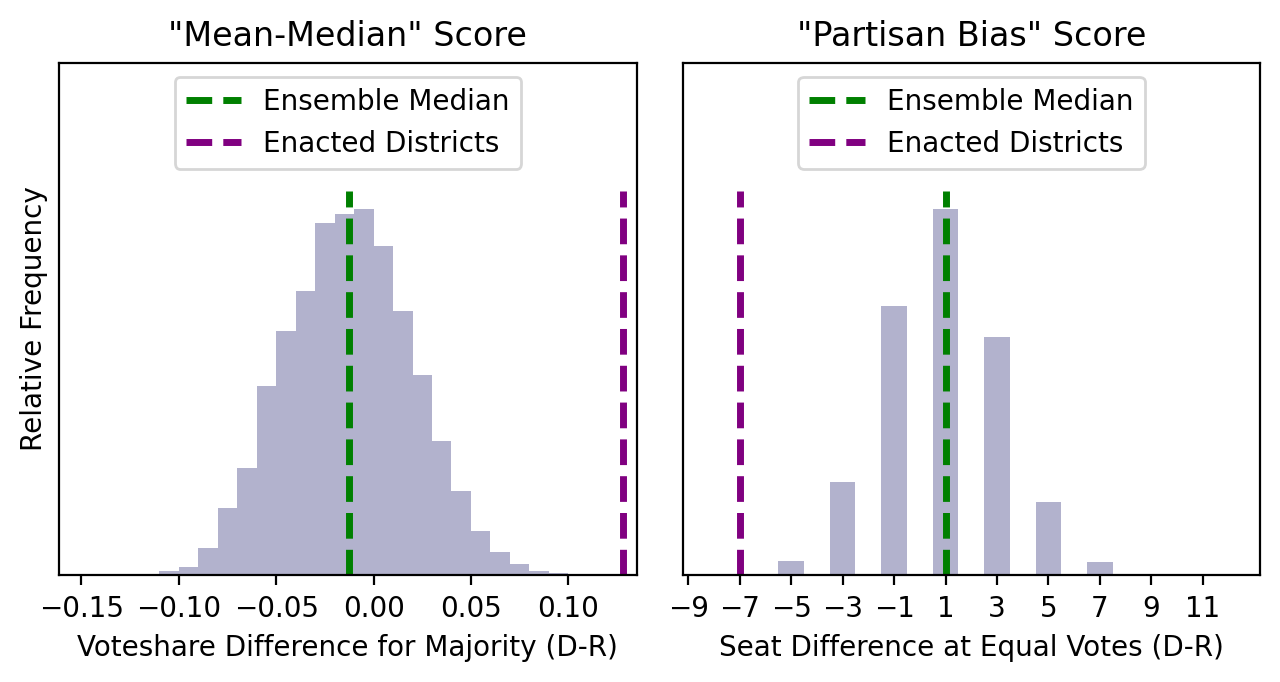

In [14]:
run()

In [15]:
#Just look at some statistics
currDList = np.array(plan_vectors[0].argsort())+1
propDList = np.array(plan_vectors[1].argsort())+1
currVV    = np.array(sorted(plan_vectors[0]))
propVV    = np.array(sorted(plan_vectors[1]))

allC = list(zip(currDList,currVV))

NameError: name 'plan_vectors' is not defined

In [ ]:
allP= list(zip(propDList,propVV))

In [ ]:
if False:
    list(zip(allC,allP))

In [ ]:
# Who currently holds the seats?
# Who is on the committee?
TXSenList = (('Alvarado',6,'D',1), ('Bettencourt',7,'R',1), ('Birdwell',22,'R',1), ('Johnson',16,'D',0), ('West',23,'D',1),\
            ('Blanco',29,'D',0),('Buckingham',24,'R',0),('Campbell',25,'R',1),('Creighton',4,'R',0),\
            ('Eckhardt',14,'D',0),('Gutierrez',19,'D',0),('Hall',2,'R',0),('Hancock',9,'R',1),\
            ('Hinojosa',20,'D',1),('Huffman',17,'R',1),('Hughes',1,'R',1),('Kolkorst',18,'R',0),\
            ('Lucio',27,'D',1),('Menendez',26,'D',0),('Miles',13,'D',0),('Nelson',12,'R',0),\
            ('Paxton',8,'R',1),('Perry',28,'R',1),('Powell',10,'D',0),('Schwertner',5,'R',0),\
            ('Seliger',31,'R',0),('Springer',30,'R',0),('Taylor',11,'R',0),('Whitmire',15,'D',1),\
            ('Zaffirini',21,'D',1))

In [ ]:
TXSenList